##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/video/video_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Video classification with a 3D convolutional neural network

This tutorial demonstrates training a 3D convolutional neural network (CNN) for video classification using the [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) action recognition dataset. A 3D CNN uses a three-dimensional filter to perform convolutions. The kernel is able to slide in three directions, whereas in a 2D CNN it can slide in two dimensions. The model is based on the work published in [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017).  In this tutorial, you will:

* Build an input pipeline
* Build a 3D convolutional neural network model with residual connections using Keras functional API
* Train the model
* Evaluate and test the model

This video classification tutorial is the second part in a series of TensorFlow video tutorials. Here are the other three tutorials:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video): This tutorial explains much of the code used in this document.
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): Get familiar with the MoViNet models that are available on TF Hub.
- [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): This tutorial explains how to use a pre-trained video classification model trained on a different dataset with the UCF-101 dataset.

## Setup

Begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip) to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files, [einops](https://github.com/arogozhnikov/einops/tree/master/docs) for performing more complex tensor operations, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) for embedding data in a Jupyter notebook.

In [2]:
!pip install remotezip tqdm opencv-python einops

  Using cached remotezip-0.10.0-py3-none-any.whl


  Using cached opencv_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.9 MB)


  Using cached einops-0.6.0-py3-none-any.whl (41 kB)


  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [3]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers


2022-12-14 07:30:14.661906: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-14 07:30:14.662014: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2022-12-14 07:30:14.662024: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Load and preprocess video data

The hidden cell below defines helper functions to download a slice of data from the UCF-101 dataset, and load it into a `tf.data.Dataset`. You can learn more about the specific preprocessing steps in the [Loading video data tutorial](../load_data/video.ipynb), which walks you through this code in more detail.

The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [4]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [5]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


  0%|          | 0/300 [00:00<?, ?it/s]

  1%|          | 2/300 [00:00<00:23, 12.92it/s]

  1%|▏         | 4/300 [00:00<00:22, 13.26it/s]

  2%|▏         | 6/300 [00:00<00:21, 13.48it/s]

  3%|▎         | 8/300 [00:00<00:22, 13.15it/s]

  3%|▎         | 10/300 [00:00<00:20, 14.19it/s]

  4%|▍         | 12/300 [00:00<00:19, 14.58it/s]

  5%|▍         | 14/300 [00:00<00:19, 14.44it/s]

  5%|▌         | 16/300 [00:01<00:20, 14.12it/s]

  6%|▌         | 18/300 [00:01<00:20, 13.66it/s]

  7%|▋         | 20/300 [00:01<00:20, 13.71it/s]

  7%|▋         | 22/300 [00:01<00:20, 13.75it/s]

  8%|▊         | 24/300 [00:01<00:20, 13.73it/s]

  9%|▊         | 26/300 [00:01<00:20, 13.33it/s]

  9%|▉         | 28/300 [00:02<00:20, 13.42it/s]

 10%|█         | 30/300 [00:02<00:18, 14.68it/s]

 11%|█         | 32/300 [00:02<00:18, 14.79it/s]

 11%|█▏        | 34/300 [00:02<00:19, 13.69it/s]

 12%|█▏        | 36/300 [00:02<00:19, 13.26it/s]

 13%|█▎        | 38/300 [00:02<00:19, 13.17it/s]

 13%|█▎        | 40/300 [00:02<00:18, 13.91it/s]

 14%|█▍        | 42/300 [00:03<00:18, 13.82it/s]

 15%|█▍        | 44/300 [00:03<00:18, 13.50it/s]

 15%|█▌        | 46/300 [00:03<00:18, 13.81it/s]

 16%|█▌        | 48/300 [00:03<00:17, 14.29it/s]

 17%|█▋        | 50/300 [00:03<00:16, 15.03it/s]

 17%|█▋        | 52/300 [00:03<00:15, 15.58it/s]

 18%|█▊        | 54/300 [00:03<00:15, 15.96it/s]

 19%|█▊        | 56/300 [00:03<00:16, 14.50it/s]

 19%|█▉        | 58/300 [00:04<00:15, 15.20it/s]

 20%|██        | 60/300 [00:04<00:16, 14.81it/s]

 21%|██        | 62/300 [00:04<00:18, 13.17it/s]

 21%|██▏       | 64/300 [00:04<00:16, 14.04it/s]

 22%|██▏       | 66/300 [00:04<00:17, 13.51it/s]

 23%|██▎       | 68/300 [00:04<00:17, 13.61it/s]

 23%|██▎       | 70/300 [00:05<00:17, 13.38it/s]

 24%|██▍       | 72/300 [00:05<00:18, 12.12it/s]

 25%|██▍       | 74/300 [00:05<00:18, 12.15it/s]

 25%|██▌       | 76/300 [00:05<00:17, 12.67it/s]

 26%|██▌       | 78/300 [00:05<00:16, 13.23it/s]

 27%|██▋       | 80/300 [00:05<00:17, 12.68it/s]

 27%|██▋       | 82/300 [00:05<00:17, 12.78it/s]

 28%|██▊       | 84/300 [00:06<00:16, 12.72it/s]

 29%|██▊       | 86/300 [00:06<00:17, 12.02it/s]

 29%|██▉       | 88/300 [00:06<00:16, 13.10it/s]

 30%|███       | 90/300 [00:06<00:15, 13.64it/s]

 31%|███       | 92/300 [00:06<00:15, 13.75it/s]

 31%|███▏      | 94/300 [00:06<00:15, 13.41it/s]

 32%|███▏      | 96/300 [00:07<00:15, 13.59it/s]

 33%|███▎      | 98/300 [00:07<00:13, 14.48it/s]

 33%|███▎      | 100/300 [00:07<00:13, 14.71it/s]

 34%|███▍      | 102/300 [00:07<00:12, 15.86it/s]

 35%|███▍      | 104/300 [00:07<00:12, 15.97it/s]

 35%|███▌      | 106/300 [00:07<00:12, 15.93it/s]

 36%|███▌      | 108/300 [00:07<00:12, 15.19it/s]

 37%|███▋      | 110/300 [00:07<00:12, 15.36it/s]

 37%|███▋      | 112/300 [00:08<00:12, 15.64it/s]

 38%|███▊      | 114/300 [00:08<00:12, 15.22it/s]

 39%|███▊      | 116/300 [00:08<00:11, 15.33it/s]

 39%|███▉      | 118/300 [00:08<00:12, 14.99it/s]

 40%|████      | 120/300 [00:08<00:11, 15.30it/s]

 41%|████      | 122/300 [00:08<00:11, 15.28it/s]

 41%|████▏     | 124/300 [00:08<00:11, 15.44it/s]

 42%|████▏     | 126/300 [00:08<00:11, 15.53it/s]

 43%|████▎     | 128/300 [00:09<00:11, 14.63it/s]

 43%|████▎     | 130/300 [00:09<00:11, 14.25it/s]

 44%|████▍     | 132/300 [00:09<00:11, 14.74it/s]

 45%|████▍     | 134/300 [00:09<00:11, 14.67it/s]

 45%|████▌     | 136/300 [00:09<00:12, 13.54it/s]

 46%|████▌     | 138/300 [00:09<00:12, 12.70it/s]

 47%|████▋     | 140/300 [00:09<00:12, 13.28it/s]

 47%|████▋     | 142/300 [00:10<00:11, 13.60it/s]

 48%|████▊     | 144/300 [00:10<00:10, 14.22it/s]

 49%|████▊     | 146/300 [00:10<00:10, 15.00it/s]

 49%|████▉     | 148/300 [00:10<00:09, 16.05it/s]

 50%|█████     | 150/300 [00:10<00:10, 14.49it/s]

 51%|█████     | 152/300 [00:10<00:10, 14.18it/s]

 51%|█████▏    | 154/300 [00:11<00:11, 12.63it/s]

 52%|█████▏    | 156/300 [00:11<00:11, 12.66it/s]

 53%|█████▎    | 158/300 [00:11<00:11, 12.64it/s]

 53%|█████▎    | 160/300 [00:11<00:11, 12.29it/s]

 54%|█████▍    | 162/300 [00:11<00:11, 12.11it/s]

 55%|█████▍    | 164/300 [00:11<00:11, 12.24it/s]

 55%|█████▌    | 166/300 [00:11<00:10, 12.96it/s]

 56%|█████▌    | 168/300 [00:12<00:10, 13.20it/s]

 57%|█████▋    | 170/300 [00:12<00:10, 12.49it/s]

 57%|█████▋    | 172/300 [00:12<00:10, 12.24it/s]

 58%|█████▊    | 174/300 [00:12<00:10, 12.12it/s]

 59%|█████▊    | 176/300 [00:12<00:10, 11.74it/s]

 59%|█████▉    | 178/300 [00:12<00:10, 12.04it/s]

 60%|██████    | 180/300 [00:13<00:10, 11.75it/s]

 61%|██████    | 182/300 [00:13<00:09, 12.93it/s]

 61%|██████▏   | 184/300 [00:13<00:08, 13.37it/s]

 62%|██████▏   | 186/300 [00:13<00:08, 13.02it/s]

 63%|██████▎   | 188/300 [00:13<00:08, 13.25it/s]

 63%|██████▎   | 190/300 [00:13<00:07, 14.02it/s]

 64%|██████▍   | 192/300 [00:13<00:07, 14.74it/s]

 65%|██████▍   | 194/300 [00:14<00:06, 15.25it/s]

 65%|██████▌   | 196/300 [00:14<00:06, 16.35it/s]

 66%|██████▌   | 198/300 [00:14<00:06, 15.90it/s]

 67%|██████▋   | 200/300 [00:14<00:06, 15.94it/s]

 67%|██████▋   | 202/300 [00:14<00:05, 16.34it/s]

 68%|██████▊   | 204/300 [00:14<00:06, 15.26it/s]

 69%|██████▊   | 206/300 [00:14<00:06, 14.76it/s]

 69%|██████▉   | 208/300 [00:14<00:06, 14.47it/s]

 70%|███████   | 210/300 [00:15<00:06, 14.82it/s]

 71%|███████   | 212/300 [00:15<00:06, 14.09it/s]

 71%|███████▏  | 214/300 [00:15<00:06, 13.51it/s]

 72%|███████▏  | 216/300 [00:15<00:06, 13.69it/s]

 73%|███████▎  | 218/300 [00:15<00:05, 14.09it/s]

 73%|███████▎  | 220/300 [00:15<00:05, 13.45it/s]

 74%|███████▍  | 222/300 [00:15<00:05, 14.66it/s]

 75%|███████▍  | 224/300 [00:16<00:05, 14.96it/s]

 75%|███████▌  | 226/300 [00:16<00:04, 15.42it/s]

 76%|███████▌  | 228/300 [00:16<00:04, 14.52it/s]

 77%|███████▋  | 230/300 [00:16<00:04, 14.47it/s]

 77%|███████▋  | 232/300 [00:16<00:04, 15.09it/s]

 78%|███████▊  | 234/300 [00:16<00:04, 14.91it/s]

 79%|███████▊  | 236/300 [00:16<00:04, 15.45it/s]

 79%|███████▉  | 238/300 [00:17<00:03, 15.65it/s]

 80%|████████  | 240/300 [00:17<00:03, 15.73it/s]

 81%|████████  | 242/300 [00:17<00:03, 15.86it/s]

 81%|████████▏ | 244/300 [00:17<00:03, 15.69it/s]

 82%|████████▏ | 246/300 [00:17<00:03, 15.31it/s]

 83%|████████▎ | 248/300 [00:17<00:03, 15.39it/s]

 83%|████████▎ | 250/300 [00:17<00:03, 15.52it/s]

 84%|████████▍ | 252/300 [00:17<00:03, 15.63it/s]

 85%|████████▍ | 254/300 [00:18<00:03, 14.74it/s]

 85%|████████▌ | 256/300 [00:18<00:02, 15.60it/s]

 86%|████████▌ | 258/300 [00:18<00:02, 15.54it/s]

 87%|████████▋ | 260/300 [00:18<00:02, 15.06it/s]

 87%|████████▋ | 262/300 [00:18<00:02, 14.05it/s]

 88%|████████▊ | 264/300 [00:18<00:02, 14.20it/s]

 89%|████████▊ | 266/300 [00:18<00:02, 13.71it/s]

 89%|████████▉ | 268/300 [00:19<00:02, 13.61it/s]

 90%|█████████ | 270/300 [00:19<00:02, 14.45it/s]

 91%|█████████ | 272/300 [00:19<00:02, 13.77it/s]

 91%|█████████▏| 274/300 [00:19<00:01, 14.05it/s]

 92%|█████████▏| 276/300 [00:19<00:01, 14.22it/s]

 93%|█████████▎| 278/300 [00:19<00:01, 14.17it/s]

 93%|█████████▎| 280/300 [00:19<00:01, 14.38it/s]

 94%|█████████▍| 282/300 [00:20<00:01, 14.60it/s]

 95%|█████████▍| 284/300 [00:20<00:01, 14.70it/s]

 95%|█████████▌| 286/300 [00:20<00:00, 14.52it/s]

 96%|█████████▌| 288/300 [00:20<00:00, 15.18it/s]

 97%|█████████▋| 290/300 [00:20<00:00, 14.75it/s]

 97%|█████████▋| 292/300 [00:20<00:00, 15.11it/s]

 98%|█████████▊| 294/300 [00:20<00:00, 15.39it/s]

 99%|█████████▊| 296/300 [00:20<00:00, 15.16it/s]

 99%|█████████▉| 298/300 [00:21<00:00, 15.32it/s]

100%|██████████| 300/300 [00:21<00:00, 16.14it/s]

100%|██████████| 300/300 [00:21<00:00, 14.16it/s]

val :


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:06, 15.23it/s]

  4%|▍         | 4/100 [00:00<00:07, 13.36it/s]

  6%|▌         | 6/100 [00:00<00:06, 14.78it/s]

  8%|▊         | 8/100 [00:00<00:05, 15.94it/s]

 10%|█         | 10/100 [00:00<00:05, 15.98it/s]

 12%|█▏        | 12/100 [00:00<00:05, 15.17it/s]

 14%|█▍        | 14/100 [00:00<00:05, 15.13it/s]

 16%|█▌        | 16/100 [00:01<00:05, 15.63it/s]

 18%|█▊        | 18/100 [00:01<00:05, 15.61it/s]

 20%|██        | 20/100 [00:01<00:05, 15.49it/s]

 22%|██▏       | 22/100 [00:01<00:05, 14.50it/s]

 24%|██▍       | 24/100 [00:01<00:05, 14.58it/s]

 26%|██▌       | 26/100 [00:01<00:05, 14.32it/s]

 28%|██▊       | 28/100 [00:01<00:04, 14.77it/s]

 30%|███       | 30/100 [00:02<00:05, 13.82it/s]

 32%|███▏      | 32/100 [00:02<00:05, 13.39it/s]

 34%|███▍      | 34/100 [00:02<00:04, 13.54it/s]

 36%|███▌      | 36/100 [00:02<00:04, 14.28it/s]

 38%|███▊      | 38/100 [00:02<00:04, 13.66it/s]

 40%|████      | 40/100 [00:02<00:04, 13.77it/s]

 42%|████▏     | 42/100 [00:02<00:04, 13.96it/s]

 44%|████▍     | 44/100 [00:03<00:04, 13.59it/s]

 46%|████▌     | 46/100 [00:03<00:03, 14.39it/s]

 48%|████▊     | 48/100 [00:03<00:03, 14.38it/s]

 50%|█████     | 50/100 [00:03<00:03, 14.16it/s]

 52%|█████▏    | 52/100 [00:03<00:03, 14.10it/s]

 54%|█████▍    | 54/100 [00:03<00:03, 14.50it/s]

 56%|█████▌    | 56/100 [00:03<00:03, 14.12it/s]

 58%|█████▊    | 58/100 [00:04<00:03, 13.30it/s]

 60%|██████    | 60/100 [00:04<00:03, 11.94it/s]

 62%|██████▏   | 62/100 [00:04<00:03, 11.96it/s]

 64%|██████▍   | 64/100 [00:04<00:02, 13.13it/s]

 66%|██████▌   | 66/100 [00:04<00:02, 13.48it/s]

 68%|██████▊   | 68/100 [00:04<00:02, 14.27it/s]

 70%|███████   | 70/100 [00:04<00:02, 13.64it/s]

 72%|███████▏  | 72/100 [00:05<00:02, 13.18it/s]

 74%|███████▍  | 74/100 [00:05<00:01, 13.44it/s]

 76%|███████▌  | 76/100 [00:05<00:01, 13.93it/s]

 78%|███████▊  | 78/100 [00:05<00:01, 14.49it/s]

 80%|████████  | 80/100 [00:05<00:01, 15.00it/s]

 82%|████████▏ | 82/100 [00:05<00:01, 15.10it/s]

 84%|████████▍ | 84/100 [00:05<00:01, 15.65it/s]

 86%|████████▌ | 86/100 [00:06<00:01, 13.73it/s]

 88%|████████▊ | 88/100 [00:06<00:00, 13.93it/s]

 90%|█████████ | 90/100 [00:06<00:00, 15.08it/s]

 92%|█████████▏| 92/100 [00:06<00:00, 15.38it/s]

 94%|█████████▍| 94/100 [00:06<00:00, 15.28it/s]

 96%|█████████▌| 96/100 [00:06<00:00, 13.76it/s]

 98%|█████████▊| 98/100 [00:06<00:00, 14.75it/s]

100%|██████████| 100/100 [00:07<00:00, 14.94it/s]

100%|██████████| 100/100 [00:07<00:00, 14.25it/s]

test :


  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:00<00:05, 19.03it/s]

  4%|▍         | 4/100 [00:00<00:05, 16.12it/s]

  6%|▌         | 6/100 [00:00<00:05, 16.04it/s]

  8%|▊         | 8/100 [00:00<00:05, 16.25it/s]

 10%|█         | 10/100 [00:00<00:05, 15.78it/s]

 12%|█▏        | 12/100 [00:00<00:06, 13.92it/s]

 14%|█▍        | 14/100 [00:00<00:05, 15.12it/s]

 16%|█▌        | 16/100 [00:01<00:05, 15.87it/s]

 18%|█▊        | 18/100 [00:01<00:05, 15.78it/s]

 20%|██        | 20/100 [00:01<00:05, 15.36it/s]

 22%|██▏       | 22/100 [00:01<00:05, 14.46it/s]

 24%|██▍       | 24/100 [00:01<00:05, 13.02it/s]

 26%|██▌       | 26/100 [00:01<00:05, 13.04it/s]

 28%|██▊       | 28/100 [00:01<00:05, 13.75it/s]

 30%|███       | 30/100 [00:02<00:04, 14.31it/s]

 32%|███▏      | 32/100 [00:02<00:04, 14.35it/s]

 34%|███▍      | 34/100 [00:02<00:04, 15.44it/s]

 36%|███▌      | 36/100 [00:02<00:04, 14.60it/s]

 38%|███▊      | 38/100 [00:02<00:04, 13.15it/s]

 40%|████      | 40/100 [00:02<00:04, 14.12it/s]

 42%|████▏     | 42/100 [00:02<00:04, 13.78it/s]

 44%|████▍     | 44/100 [00:03<00:03, 14.98it/s]

 46%|████▌     | 46/100 [00:03<00:03, 15.10it/s]

 48%|████▊     | 48/100 [00:03<00:03, 13.48it/s]

 50%|█████     | 50/100 [00:03<00:03, 12.77it/s]

 52%|█████▏    | 52/100 [00:03<00:03, 13.34it/s]

 54%|█████▍    | 54/100 [00:03<00:03, 13.56it/s]

 56%|█████▌    | 56/100 [00:03<00:03, 13.40it/s]

 58%|█████▊    | 58/100 [00:04<00:02, 14.05it/s]

 60%|██████    | 60/100 [00:04<00:02, 14.45it/s]

 62%|██████▏   | 62/100 [00:04<00:02, 14.65it/s]

 64%|██████▍   | 64/100 [00:04<00:02, 15.33it/s]

 66%|██████▌   | 66/100 [00:04<00:02, 15.75it/s]

 68%|██████▊   | 68/100 [00:04<00:02, 14.88it/s]

 70%|███████   | 70/100 [00:04<00:02, 14.36it/s]

 72%|███████▏  | 72/100 [00:04<00:01, 14.01it/s]

 74%|███████▍  | 74/100 [00:05<00:01, 13.39it/s]

 76%|███████▌  | 76/100 [00:05<00:01, 14.21it/s]

 78%|███████▊  | 78/100 [00:05<00:01, 14.30it/s]

 80%|████████  | 80/100 [00:05<00:01, 13.42it/s]

 82%|████████▏ | 82/100 [00:05<00:01, 14.14it/s]

 84%|████████▍ | 84/100 [00:05<00:01, 14.13it/s]

 86%|████████▌ | 86/100 [00:05<00:00, 14.42it/s]

 88%|████████▊ | 88/100 [00:06<00:00, 14.22it/s]

 90%|█████████ | 90/100 [00:06<00:00, 14.47it/s]

 92%|█████████▏| 92/100 [00:06<00:00, 14.55it/s]

 94%|█████████▍| 94/100 [00:06<00:00, 14.70it/s]

 96%|█████████▌| 96/100 [00:06<00:00, 15.03it/s]

 98%|█████████▊| 98/100 [00:06<00:00, 14.17it/s]

100%|██████████| 100/100 [00:06<00:00, 13.95it/s]

100%|██████████| 100/100 [00:06<00:00, 14.34it/s]

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [6]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

## Create the model

The following 3D convolutional neural network model is based off the paper [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017). The paper compares several versions of 3D ResNets. Instead of operating on a single image with dimensions `(height, width)`, like standard ResNets, these operate on video volume `(time, height, width)`. The most obvious approach to this problem would be replace each 2D convolution (`layers.Conv2D`) with a 3D convolution (`layers.Conv3D`).

This tutorial uses a (2 + 1)D convolution with [residual connections](https://arxiv.org/abs/1512.03385). The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this approach is that factorizing the convolutions into spatial and temporal dimensions saves parameters. 

For each output location a 3D convolution combines all the vectors from a 3D patch of the volume to create one vector in the output volume.

![3D convolutions](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

This operation is takes `time * height * width * channels` inputs and produces `channels` outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of `(3 x 3 x 3)` would need a weight-matrix with `27 * channels ** 2` entries. The reference paper found that a more effective & efficient approach was to factorize the convolution. Instead of a single 3D convolution to process the time and space dimensions, they proposed a \"(2+1)D\" convolution which processes the space and time dimensions separately. The figure below shows the factored spatial and temporal convolutions of a (2 + 1)D convolution.

![(2+1)D convolutions](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

The main advantage of this approach is that it reduces the number of parameters. In the (2 + 1)D convolution the spatial convolution takes in data of the shape `(1, width, height)`, while the temporal convolution takes in data of the shape `(time, 1, 1)`. For example, a (2 + 1)D convolution with kernel size `(3 x 3 x 3)` would need weight matrices of size `(9 * channels**2) + (3 * channels**2)`, less than half as many as the full 3D convolution. This tutorial implements (2 + 1)D ResNet18, where each convolution in the resnet is replaced by a (2+1)D convolution.

In [7]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [8]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

A ResNet model resnet model is made from a sequence of residual blocks.
A residual block has two branches. The main branch performs the calculatoion, but is difficult for gradients to flow through.
The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch.
Gradients flow easily through this branch.
Therefore, an easy path from the loss function to any of the residual block's main branch will be present.
This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom `Conv2Plus1D` layer instead of `layers.Conv2D`.

In [9]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The `Project` layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.  

In [10]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` to introduce a skip connection between the layers of the model.

In [11]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the model.

In [12]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Use the [Keras functional API](https://www.tensorflow.org/guide/keras/functional) to build the residual network.

In [13]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [14]:
frames, label = next(iter(train_ds))
model.build(frames)

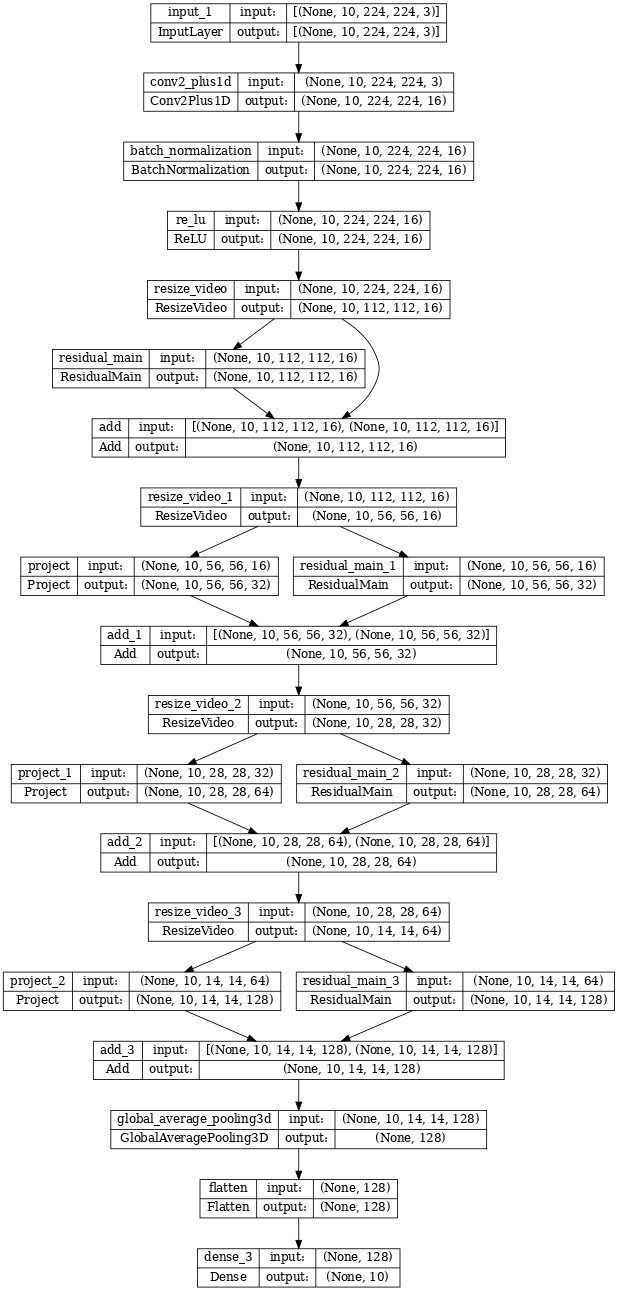

In [15]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

## Train the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the `metrics` argument to the view the accuracy of the model performance at every step.

In [16]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

Train the model for 50 epoches with the Keras `Model.fit` method.

Note: This example model is trained on fewer data points (300 training and 100 validation examples) to keep training time reasonable for this tutorial. Moreover, this example model may take over one hour to train.

In [17]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50


      1/Unknown - 7s 7s/step - loss: 3.4864 - accuracy: 0.2500

      2/Unknown - 8s 779ms/step - loss: 3.5697 - accuracy: 0.1875

      3/Unknown - 9s 1s/step - loss: 3.4654 - accuracy: 0.1667   

      4/Unknown - 10s 1s/step - loss: 3.3248 - accuracy: 0.1250

      5/Unknown - 12s 1s/step - loss: 3.2018 - accuracy: 0.1000

      6/Unknown - 13s 1s/step - loss: 3.0890 - accuracy: 0.1250

      7/Unknown - 14s 1s/step - loss: 3.0775 - accuracy: 0.1071

      8/Unknown - 15s 1s/step - loss: 3.0765 - accuracy: 0.0938

      9/Unknown - 16s 1s/step - loss: 3.0633 - accuracy: 0.0833

     10/Unknown - 18s 1s/step - loss: 3.0781 - accuracy: 0.1000

     11/Unknown - 19s 1s/step - loss: 2.9995 - accuracy: 0.1023

     12/Unknown - 20s 1s/step - loss: 2.9518 - accuracy: 0.1042

     13/Unknown - 21s 1s/step - loss: 3.0001 - accuracy: 0.1058

     14/Unknown - 23s 1s/step - loss: 2.9679 - accuracy: 0.0982

     15/Unknown - 24s 1s/step - loss: 2.9950 - accuracy: 0.0917

     16/Unknown - 25s 1s/step - loss: 2.9901 - accuracy: 0.0938

     17/Unknown - 26s 1s/step - loss: 2.9634 - accuracy: 0.0882

     18/Unknown - 28s 1s/step - loss: 2.9613 - accuracy: 0.0833

     19/Unknown - 29s 1s/step - loss: 2.9274 - accuracy: 0.0855

     20/Unknown - 30s 1s/step - loss: 2.9153 - accuracy: 0.0812

     21/Unknown - 31s 1s/step - loss: 2.8922 - accuracy: 0.0774

     22/Unknown - 33s 1s/step - loss: 2.8685 - accuracy: 0.0739

     23/Unknown - 34s 1s/step - loss: 2.8716 - accuracy: 0.0815

     24/Unknown - 35s 1s/step - loss: 2.8566 - accuracy: 0.0781

     25/Unknown - 37s 1s/step - loss: 2.8429 - accuracy: 0.0800

     26/Unknown - 38s 1s/step - loss: 2.8273 - accuracy: 0.0913

     27/Unknown - 39s 1s/step - loss: 2.8028 - accuracy: 0.0926

     28/Unknown - 41s 1s/step - loss: 2.7895 - accuracy: 0.0893

     29/Unknown - 42s 1s/step - loss: 2.7873 - accuracy: 0.0862

     30/Unknown - 43s 1s/step - loss: 2.7669 - accuracy: 0.0917

     31/Unknown - 44s 1s/step - loss: 2.7679 - accuracy: 0.0887

     32/Unknown - 46s 1s/step - loss: 2.7535 - accuracy: 0.0898

     33/Unknown - 47s 1s/step - loss: 2.7456 - accuracy: 0.0871

     34/Unknown - 48s 1s/step - loss: 2.7374 - accuracy: 0.0846

     35/Unknown - 50s 1s/step - loss: 2.7191 - accuracy: 0.0893

     36/Unknown - 51s 1s/step - loss: 2.7097 - accuracy: 0.0903

     37/Unknown - 52s 1s/step - loss: 2.6924 - accuracy: 0.0946

     38/Unknown - 53s 1s/step - loss: 2.6910 - accuracy: 0.0933

38/38 [==============================] - 67s 2s/step - loss: 2.6910 - accuracy: 0.0933 - val_loss: 2.4032 - val_accuracy: 0.1000


Epoch 2/50


 1/38 [..............................] - ETA: 45s - loss: 2.4414 - accuracy: 0.0000e+00

 2/38 [>.............................] - ETA: 51s - loss: 2.3095 - accuracy: 0.1250    

 3/38 [=>............................] - ETA: 47s - loss: 2.1993 - accuracy: 0.1250

 4/38 [==>...........................] - ETA: 44s - loss: 2.1911 - accuracy: 0.1875

 5/38 [==>...........................] - ETA: 42s - loss: 2.1967 - accuracy: 0.1500

 6/38 [===>..........................] - ETA: 40s - loss: 2.2581 - accuracy: 0.1458

 7/38 [====>.........................] - ETA: 38s - loss: 2.2797 - accuracy: 0.1429

 8/38 [=====>........................] - ETA: 37s - loss: 2.3629 - accuracy: 0.1250

 9/38 [======>.......................] - ETA: 36s - loss: 2.4446 - accuracy: 0.1111

10/38 [======>.......................] - ETA: 34s - loss: 2.4898 - accuracy: 0.1125

11/38 [=======>......................] - ETA: 33s - loss: 2.4495 - accuracy: 0.1136

12/38 [========>.....................] - ETA: 31s - loss: 2.4509 - accuracy: 0.1042

13/38 [=========>....................] - ETA: 30s - loss: 2.4384 - accuracy: 0.1154

14/38 [==========>...................] - ETA: 29s - loss: 2.4276 - accuracy: 0.1161

15/38 [==========>...................] - ETA: 28s - loss: 2.3980 - accuracy: 0.1167

16/38 [===========>..................] - ETA: 27s - loss: 2.3866 - accuracy: 0.1172

17/38 [============>.................] - ETA: 25s - loss: 2.3733 - accuracy: 0.1103

18/38 [=============>................] - ETA: 24s - loss: 2.3462 - accuracy: 0.1181

19/38 [==============>...............] - ETA: 23s - loss: 2.3618 - accuracy: 0.1184

20/38 [==============>...............] - ETA: 22s - loss: 2.3786 - accuracy: 0.1125

21/38 [===============>..............] - ETA: 21s - loss: 2.3696 - accuracy: 0.1131

22/38 [================>.............] - ETA: 19s - loss: 2.3714 - accuracy: 0.1250

23/38 [=================>............] - ETA: 18s - loss: 2.3556 - accuracy: 0.1304

24/38 [=================>............] - ETA: 17s - loss: 2.3454 - accuracy: 0.1354

25/38 [==================>...........] - ETA: 16s - loss: 2.3461 - accuracy: 0.1300

26/38 [===================>..........] - ETA: 14s - loss: 2.3355 - accuracy: 0.1346

27/38 [====================>.........] - ETA: 13s - loss: 2.3224 - accuracy: 0.1481

28/38 [=====================>........] - ETA: 12s - loss: 2.3197 - accuracy: 0.1429

29/38 [=====================>........] - ETA: 11s - loss: 2.3181 - accuracy: 0.1422

30/38 [======================>.......] - ETA: 10s - loss: 2.3148 - accuracy: 0.1500

31/38 [=======================>......] - ETA: 8s - loss: 2.3076 - accuracy: 0.1452 

32/38 [========================>.....] - ETA: 7s - loss: 2.3093 - accuracy: 0.1445

33/38 [=========================>....] - ETA: 6s - loss: 2.3004 - accuracy: 0.1553

34/38 [=========================>....] - ETA: 5s - loss: 2.2961 - accuracy: 0.1618

35/38 [==========================>...] - ETA: 3s - loss: 2.2901 - accuracy: 0.1607

36/38 [===========================>..] - ETA: 2s - loss: 2.2945 - accuracy: 0.1597

37/38 [============================>.] - ETA: 1s - loss: 2.2899 - accuracy: 0.1622

38/38 [==============================] - ETA: 0s - loss: 2.2876 - accuracy: 0.1600

38/38 [==============================] - 60s 2s/step - loss: 2.2876 - accuracy: 0.1600 - val_loss: 2.3824 - val_accuracy: 0.1400


Epoch 3/50


 1/38 [..............................] - ETA: 48s - loss: 1.9025 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 45s - loss: 1.8237 - accuracy: 0.3750

 3/38 [=>............................] - ETA: 45s - loss: 1.9646 - accuracy: 0.2917

 4/38 [==>...........................] - ETA: 43s - loss: 1.9729 - accuracy: 0.2812

 5/38 [==>...........................] - ETA: 41s - loss: 2.1067 - accuracy: 0.2250

 6/38 [===>..........................] - ETA: 40s - loss: 2.0762 - accuracy: 0.2083

 7/38 [====>.........................] - ETA: 39s - loss: 2.0466 - accuracy: 0.2500

 8/38 [=====>........................] - ETA: 38s - loss: 2.0916 - accuracy: 0.2188

 9/38 [======>.......................] - ETA: 37s - loss: 2.1022 - accuracy: 0.1944

10/38 [======>.......................] - ETA: 36s - loss: 2.0985 - accuracy: 0.2250

11/38 [=======>......................] - ETA: 34s - loss: 2.1293 - accuracy: 0.2045

12/38 [========>.....................] - ETA: 33s - loss: 2.1658 - accuracy: 0.1875

13/38 [=========>....................] - ETA: 32s - loss: 2.1670 - accuracy: 0.1827

14/38 [==========>...................] - ETA: 30s - loss: 2.1617 - accuracy: 0.1696

15/38 [==========>...................] - ETA: 29s - loss: 2.1604 - accuracy: 0.1583

16/38 [===========>..................] - ETA: 27s - loss: 2.1469 - accuracy: 0.1641

17/38 [============>.................] - ETA: 26s - loss: 2.1603 - accuracy: 0.1618

18/38 [=============>................] - ETA: 25s - loss: 2.1901 - accuracy: 0.1528

19/38 [==============>...............] - ETA: 24s - loss: 2.1961 - accuracy: 0.1513

20/38 [==============>...............] - ETA: 22s - loss: 2.1982 - accuracy: 0.1500

21/38 [===============>..............] - ETA: 21s - loss: 2.1905 - accuracy: 0.1488

22/38 [================>.............] - ETA: 20s - loss: 2.1819 - accuracy: 0.1534

23/38 [=================>............] - ETA: 18s - loss: 2.1792 - accuracy: 0.1467

24/38 [=================>............] - ETA: 17s - loss: 2.1660 - accuracy: 0.1562

25/38 [==================>...........] - ETA: 16s - loss: 2.1601 - accuracy: 0.1600

26/38 [===================>..........] - ETA: 14s - loss: 2.1530 - accuracy: 0.1635

27/38 [====================>.........] - ETA: 13s - loss: 2.1451 - accuracy: 0.1620

28/38 [=====================>........] - ETA: 12s - loss: 2.1453 - accuracy: 0.1652

29/38 [=====================>........] - ETA: 11s - loss: 2.1297 - accuracy: 0.1767

30/38 [======================>.......] - ETA: 9s - loss: 2.1368 - accuracy: 0.1750 

31/38 [=======================>......] - ETA: 8s - loss: 2.1521 - accuracy: 0.1734

32/38 [========================>.....] - ETA: 7s - loss: 2.1625 - accuracy: 0.1680

33/38 [=========================>....] - ETA: 6s - loss: 2.1575 - accuracy: 0.1705

34/38 [=========================>....] - ETA: 5s - loss: 2.1589 - accuracy: 0.1691

35/38 [==========================>...] - ETA: 3s - loss: 2.1450 - accuracy: 0.1786

36/38 [===========================>..] - ETA: 2s - loss: 2.1291 - accuracy: 0.1875

37/38 [============================>.] - ETA: 1s - loss: 2.1100 - accuracy: 0.1993

38/38 [==============================] - ETA: 0s - loss: 2.1127 - accuracy: 0.1967

38/38 [==============================] - 59s 2s/step - loss: 2.1127 - accuracy: 0.1967 - val_loss: 2.5570 - val_accuracy: 0.1700


Epoch 4/50


 1/38 [..............................] - ETA: 48s - loss: 2.4679 - accuracy: 0.1250

 2/38 [>.............................] - ETA: 47s - loss: 2.1856 - accuracy: 0.1250

 3/38 [=>............................] - ETA: 43s - loss: 2.2552 - accuracy: 0.1250

 4/38 [==>...........................] - ETA: 42s - loss: 2.1398 - accuracy: 0.1875

 5/38 [==>...........................] - ETA: 40s - loss: 2.1005 - accuracy: 0.2000

 6/38 [===>..........................] - ETA: 39s - loss: 2.0960 - accuracy: 0.2083

 7/38 [====>.........................] - ETA: 38s - loss: 2.0586 - accuracy: 0.2143

 8/38 [=====>........................] - ETA: 37s - loss: 2.0283 - accuracy: 0.2656

 9/38 [======>.......................] - ETA: 35s - loss: 2.0164 - accuracy: 0.2778

10/38 [======>.......................] - ETA: 34s - loss: 2.0369 - accuracy: 0.2750

11/38 [=======>......................] - ETA: 33s - loss: 2.0505 - accuracy: 0.2727

12/38 [========>.....................] - ETA: 32s - loss: 2.0830 - accuracy: 0.2812

13/38 [=========>....................] - ETA: 31s - loss: 2.0804 - accuracy: 0.2788

14/38 [==========>...................] - ETA: 30s - loss: 2.1060 - accuracy: 0.2679

15/38 [==========>...................] - ETA: 28s - loss: 2.0886 - accuracy: 0.2583

16/38 [===========>..................] - ETA: 27s - loss: 2.0870 - accuracy: 0.2578

17/38 [============>.................] - ETA: 25s - loss: 2.0682 - accuracy: 0.2647

18/38 [=============>................] - ETA: 24s - loss: 2.0683 - accuracy: 0.2639

19/38 [==============>...............] - ETA: 23s - loss: 2.0570 - accuracy: 0.2632

20/38 [==============>...............] - ETA: 22s - loss: 2.0696 - accuracy: 0.2562

21/38 [===============>..............] - ETA: 20s - loss: 2.0573 - accuracy: 0.2560

22/38 [================>.............] - ETA: 19s - loss: 2.0527 - accuracy: 0.2500

23/38 [=================>............] - ETA: 18s - loss: 2.0513 - accuracy: 0.2500

24/38 [=================>............] - ETA: 17s - loss: 2.0353 - accuracy: 0.2552

25/38 [==================>...........] - ETA: 16s - loss: 2.0268 - accuracy: 0.2550

26/38 [===================>..........] - ETA: 14s - loss: 2.0236 - accuracy: 0.2548

27/38 [====================>.........] - ETA: 13s - loss: 2.0222 - accuracy: 0.2593

28/38 [=====================>........] - ETA: 12s - loss: 2.0343 - accuracy: 0.2500

29/38 [=====================>........] - ETA: 11s - loss: 2.0420 - accuracy: 0.2543

30/38 [======================>.......] - ETA: 10s - loss: 2.0448 - accuracy: 0.2542

31/38 [=======================>......] - ETA: 8s - loss: 2.0435 - accuracy: 0.2581 

32/38 [========================>.....] - ETA: 7s - loss: 2.0575 - accuracy: 0.2539

33/38 [=========================>....] - ETA: 6s - loss: 2.0522 - accuracy: 0.2576

34/38 [=========================>....] - ETA: 4s - loss: 2.0536 - accuracy: 0.2500

35/38 [==========================>...] - ETA: 3s - loss: 2.0446 - accuracy: 0.2571

36/38 [===========================>..] - ETA: 2s - loss: 2.0443 - accuracy: 0.2569

37/38 [============================>.] - ETA: 1s - loss: 2.0485 - accuracy: 0.2568

38/38 [==============================] - ETA: 0s - loss: 2.0514 - accuracy: 0.2567

38/38 [==============================] - 59s 2s/step - loss: 2.0514 - accuracy: 0.2567 - val_loss: 2.1332 - val_accuracy: 0.2300


Epoch 5/50


 1/38 [..............................] - ETA: 50s - loss: 2.2537 - accuracy: 0.1250

 2/38 [>.............................] - ETA: 42s - loss: 2.2939 - accuracy: 0.2500

 3/38 [=>............................] - ETA: 42s - loss: 2.2628 - accuracy: 0.2917

 4/38 [==>...........................] - ETA: 41s - loss: 2.1930 - accuracy: 0.2500

 5/38 [==>...........................] - ETA: 40s - loss: 2.0699 - accuracy: 0.3000

 6/38 [===>..........................] - ETA: 40s - loss: 2.0465 - accuracy: 0.2917

 7/38 [====>.........................] - ETA: 39s - loss: 2.0538 - accuracy: 0.2857

 8/38 [=====>........................] - ETA: 37s - loss: 2.0056 - accuracy: 0.2969

 9/38 [======>.......................] - ETA: 37s - loss: 1.9562 - accuracy: 0.3194

10/38 [======>.......................] - ETA: 35s - loss: 1.9794 - accuracy: 0.3000

11/38 [=======>......................] - ETA: 34s - loss: 1.9609 - accuracy: 0.2955

12/38 [========>.....................] - ETA: 33s - loss: 1.9344 - accuracy: 0.3125

13/38 [=========>....................] - ETA: 32s - loss: 1.9443 - accuracy: 0.3077

14/38 [==========>...................] - ETA: 30s - loss: 1.9486 - accuracy: 0.2946

15/38 [==========>...................] - ETA: 29s - loss: 1.9425 - accuracy: 0.2917

16/38 [===========>..................] - ETA: 27s - loss: 1.9656 - accuracy: 0.2812

17/38 [============>.................] - ETA: 26s - loss: 1.9324 - accuracy: 0.3088

18/38 [=============>................] - ETA: 25s - loss: 1.9124 - accuracy: 0.3194

19/38 [==============>...............] - ETA: 24s - loss: 1.9062 - accuracy: 0.3289

20/38 [==============>...............] - ETA: 22s - loss: 1.8892 - accuracy: 0.3375

21/38 [===============>..............] - ETA: 21s - loss: 1.8885 - accuracy: 0.3452

22/38 [================>.............] - ETA: 20s - loss: 1.8833 - accuracy: 0.3466

23/38 [=================>............] - ETA: 18s - loss: 1.9092 - accuracy: 0.3370

24/38 [=================>............] - ETA: 17s - loss: 1.9109 - accuracy: 0.3438

25/38 [==================>...........] - ETA: 16s - loss: 1.8998 - accuracy: 0.3300

26/38 [===================>..........] - ETA: 15s - loss: 1.9084 - accuracy: 0.3173

27/38 [====================>.........] - ETA: 13s - loss: 1.9018 - accuracy: 0.3148

28/38 [=====================>........] - ETA: 12s - loss: 1.9069 - accuracy: 0.3036

29/38 [=====================>........] - ETA: 11s - loss: 1.9104 - accuracy: 0.3060

30/38 [======================>.......] - ETA: 9s - loss: 1.9051 - accuracy: 0.3125 

31/38 [=======================>......] - ETA: 8s - loss: 1.9050 - accuracy: 0.3024

32/38 [========================>.....] - ETA: 7s - loss: 1.9029 - accuracy: 0.3008

33/38 [=========================>....] - ETA: 6s - loss: 1.9086 - accuracy: 0.2992

34/38 [=========================>....] - ETA: 4s - loss: 1.9187 - accuracy: 0.2978

35/38 [==========================>...] - ETA: 3s - loss: 1.9161 - accuracy: 0.2964

36/38 [===========================>..] - ETA: 2s - loss: 1.9037 - accuracy: 0.3056

37/38 [============================>.] - ETA: 1s - loss: 1.9004 - accuracy: 0.3041

38/38 [==============================] - ETA: 0s - loss: 1.9105 - accuracy: 0.3000

38/38 [==============================] - 60s 2s/step - loss: 1.9105 - accuracy: 0.3000 - val_loss: 2.5550 - val_accuracy: 0.1700


Epoch 6/50


 1/38 [..............................] - ETA: 48s - loss: 2.0307 - accuracy: 0.3750

 2/38 [>.............................] - ETA: 47s - loss: 1.8785 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 45s - loss: 1.8912 - accuracy: 0.4167

 4/38 [==>...........................] - ETA: 42s - loss: 1.9345 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 41s - loss: 1.9196 - accuracy: 0.3750

 6/38 [===>..........................] - ETA: 40s - loss: 1.9883 - accuracy: 0.3542

 7/38 [====>.........................] - ETA: 39s - loss: 1.9245 - accuracy: 0.3750

 8/38 [=====>........................] - ETA: 37s - loss: 1.9025 - accuracy: 0.3750

 9/38 [======>.......................] - ETA: 36s - loss: 1.8606 - accuracy: 0.3889

10/38 [======>.......................] - ETA: 35s - loss: 1.8652 - accuracy: 0.3875

11/38 [=======>......................] - ETA: 34s - loss: 1.9041 - accuracy: 0.3864

12/38 [========>.....................] - ETA: 33s - loss: 1.9025 - accuracy: 0.3750

13/38 [=========>....................] - ETA: 31s - loss: 1.9102 - accuracy: 0.3654

14/38 [==========>...................] - ETA: 30s - loss: 1.9320 - accuracy: 0.3482

15/38 [==========>...................] - ETA: 28s - loss: 1.9159 - accuracy: 0.3417

16/38 [===========>..................] - ETA: 27s - loss: 1.9039 - accuracy: 0.3438

17/38 [============>.................] - ETA: 26s - loss: 1.8811 - accuracy: 0.3529

18/38 [=============>................] - ETA: 24s - loss: 1.8848 - accuracy: 0.3472

19/38 [==============>...............] - ETA: 23s - loss: 1.8710 - accuracy: 0.3421

20/38 [==============>...............] - ETA: 22s - loss: 1.8688 - accuracy: 0.3375

21/38 [===============>..............] - ETA: 21s - loss: 1.8995 - accuracy: 0.3214

22/38 [================>.............] - ETA: 19s - loss: 1.8863 - accuracy: 0.3239

23/38 [=================>............] - ETA: 18s - loss: 1.9127 - accuracy: 0.3207

24/38 [=================>............] - ETA: 17s - loss: 1.8866 - accuracy: 0.3281

25/38 [==================>...........] - ETA: 16s - loss: 1.8927 - accuracy: 0.3250

26/38 [===================>..........] - ETA: 14s - loss: 1.9022 - accuracy: 0.3173

27/38 [====================>.........] - ETA: 13s - loss: 1.9148 - accuracy: 0.3102

28/38 [=====================>........] - ETA: 12s - loss: 1.9166 - accuracy: 0.3125

29/38 [=====================>........] - ETA: 11s - loss: 1.9136 - accuracy: 0.3060

30/38 [======================>.......] - ETA: 9s - loss: 1.9052 - accuracy: 0.3125 

31/38 [=======================>......] - ETA: 8s - loss: 1.8899 - accuracy: 0.3185

32/38 [========================>.....] - ETA: 7s - loss: 1.9043 - accuracy: 0.3203

33/38 [=========================>....] - ETA: 6s - loss: 1.9211 - accuracy: 0.3144

34/38 [=========================>....] - ETA: 4s - loss: 1.9259 - accuracy: 0.3162

35/38 [==========================>...] - ETA: 3s - loss: 1.9179 - accuracy: 0.3214

36/38 [===========================>..] - ETA: 2s - loss: 1.9320 - accuracy: 0.3160

37/38 [============================>.] - ETA: 1s - loss: 1.9278 - accuracy: 0.3108

38/38 [==============================] - ETA: 0s - loss: 1.9300 - accuracy: 0.3100

38/38 [==============================] - 60s 2s/step - loss: 1.9300 - accuracy: 0.3100 - val_loss: 1.9895 - val_accuracy: 0.2400


Epoch 7/50


 1/38 [..............................] - ETA: 46s - loss: 2.1271 - accuracy: 0.3750

 2/38 [>.............................] - ETA: 47s - loss: 1.9400 - accuracy: 0.3750

 3/38 [=>............................] - ETA: 46s - loss: 1.9870 - accuracy: 0.2917

 4/38 [==>...........................] - ETA: 43s - loss: 2.1894 - accuracy: 0.2188

 5/38 [==>...........................] - ETA: 41s - loss: 2.1845 - accuracy: 0.2250

 6/38 [===>..........................] - ETA: 40s - loss: 2.1065 - accuracy: 0.2708

 7/38 [====>.........................] - ETA: 39s - loss: 2.0479 - accuracy: 0.2857

 8/38 [=====>........................] - ETA: 38s - loss: 2.0204 - accuracy: 0.2969

 9/38 [======>.......................] - ETA: 37s - loss: 1.9515 - accuracy: 0.3472

10/38 [======>.......................] - ETA: 36s - loss: 1.9446 - accuracy: 0.3375

11/38 [=======>......................] - ETA: 34s - loss: 1.9263 - accuracy: 0.3295

12/38 [========>.....................] - ETA: 33s - loss: 1.8946 - accuracy: 0.3438

13/38 [=========>....................] - ETA: 32s - loss: 1.8717 - accuracy: 0.3654

14/38 [==========>...................] - ETA: 30s - loss: 1.8783 - accuracy: 0.3571

15/38 [==========>...................] - ETA: 29s - loss: 1.8684 - accuracy: 0.3500

16/38 [===========>..................] - ETA: 28s - loss: 1.8425 - accuracy: 0.3672

17/38 [============>.................] - ETA: 26s - loss: 1.8759 - accuracy: 0.3603

18/38 [=============>................] - ETA: 25s - loss: 1.8593 - accuracy: 0.3611

19/38 [==============>...............] - ETA: 24s - loss: 1.8888 - accuracy: 0.3487

20/38 [==============>...............] - ETA: 22s - loss: 1.8861 - accuracy: 0.3375

21/38 [===============>..............] - ETA: 21s - loss: 1.8885 - accuracy: 0.3274

22/38 [================>.............] - ETA: 20s - loss: 1.8817 - accuracy: 0.3352

23/38 [=================>............] - ETA: 18s - loss: 1.8575 - accuracy: 0.3478

24/38 [=================>............] - ETA: 17s - loss: 1.8416 - accuracy: 0.3438

25/38 [==================>...........] - ETA: 16s - loss: 1.8507 - accuracy: 0.3400

26/38 [===================>..........] - ETA: 15s - loss: 1.8505 - accuracy: 0.3365

27/38 [====================>.........] - ETA: 13s - loss: 1.8562 - accuracy: 0.3287

28/38 [=====================>........] - ETA: 12s - loss: 1.8598 - accuracy: 0.3304

29/38 [=====================>........] - ETA: 11s - loss: 1.8750 - accuracy: 0.3233

30/38 [======================>.......] - ETA: 9s - loss: 1.8693 - accuracy: 0.3250 

31/38 [=======================>......] - ETA: 8s - loss: 1.8928 - accuracy: 0.3185

32/38 [========================>.....] - ETA: 7s - loss: 1.8943 - accuracy: 0.3164

33/38 [=========================>....] - ETA: 6s - loss: 1.9047 - accuracy: 0.3220

34/38 [=========================>....] - ETA: 4s - loss: 1.8906 - accuracy: 0.3272

35/38 [==========================>...] - ETA: 3s - loss: 1.8895 - accuracy: 0.3250

36/38 [===========================>..] - ETA: 2s - loss: 1.8814 - accuracy: 0.3299

37/38 [============================>.] - ETA: 1s - loss: 1.8961 - accuracy: 0.3243

38/38 [==============================] - ETA: 0s - loss: 1.8974 - accuracy: 0.3200

38/38 [==============================] - 59s 2s/step - loss: 1.8974 - accuracy: 0.3200 - val_loss: 2.0703 - val_accuracy: 0.2000


Epoch 8/50


 1/38 [..............................] - ETA: 45s - loss: 2.1633 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 47s - loss: 2.0191 - accuracy: 0.1875

 3/38 [=>............................] - ETA: 46s - loss: 1.9589 - accuracy: 0.1667

 4/38 [==>...........................] - ETA: 44s - loss: 1.8542 - accuracy: 0.2812

 5/38 [==>...........................] - ETA: 42s - loss: 1.8899 - accuracy: 0.3000

 6/38 [===>..........................] - ETA: 40s - loss: 1.8604 - accuracy: 0.2917

 7/38 [====>.........................] - ETA: 39s - loss: 1.8681 - accuracy: 0.2857

 8/38 [=====>........................] - ETA: 37s - loss: 1.8367 - accuracy: 0.3125

 9/38 [======>.......................] - ETA: 36s - loss: 1.7806 - accuracy: 0.3333

10/38 [======>.......................] - ETA: 34s - loss: 1.7613 - accuracy: 0.3375

11/38 [=======>......................] - ETA: 33s - loss: 1.7267 - accuracy: 0.3523

12/38 [========>.....................] - ETA: 32s - loss: 1.7099 - accuracy: 0.3646

13/38 [=========>....................] - ETA: 30s - loss: 1.7037 - accuracy: 0.3654

14/38 [==========>...................] - ETA: 29s - loss: 1.7357 - accuracy: 0.3482

15/38 [==========>...................] - ETA: 28s - loss: 1.7262 - accuracy: 0.3417

16/38 [===========>..................] - ETA: 27s - loss: 1.7386 - accuracy: 0.3516

17/38 [============>.................] - ETA: 26s - loss: 1.7428 - accuracy: 0.3382

18/38 [=============>................] - ETA: 24s - loss: 1.7448 - accuracy: 0.3403

19/38 [==============>...............] - ETA: 23s - loss: 1.7403 - accuracy: 0.3421

20/38 [==============>...............] - ETA: 22s - loss: 1.7480 - accuracy: 0.3438

21/38 [===============>..............] - ETA: 21s - loss: 1.7527 - accuracy: 0.3333

22/38 [================>.............] - ETA: 20s - loss: 1.7471 - accuracy: 0.3466

23/38 [=================>............] - ETA: 18s - loss: 1.7571 - accuracy: 0.3370

24/38 [=================>............] - ETA: 17s - loss: 1.7386 - accuracy: 0.3490

25/38 [==================>...........] - ETA: 16s - loss: 1.7482 - accuracy: 0.3400

26/38 [===================>..........] - ETA: 15s - loss: 1.7454 - accuracy: 0.3317

27/38 [====================>.........] - ETA: 13s - loss: 1.7506 - accuracy: 0.3380

28/38 [=====================>........] - ETA: 12s - loss: 1.7495 - accuracy: 0.3438

29/38 [=====================>........] - ETA: 11s - loss: 1.7450 - accuracy: 0.3534

30/38 [======================>.......] - ETA: 9s - loss: 1.7501 - accuracy: 0.3542 

31/38 [=======================>......] - ETA: 8s - loss: 1.7427 - accuracy: 0.3629

32/38 [========================>.....] - ETA: 7s - loss: 1.7372 - accuracy: 0.3672

33/38 [=========================>....] - ETA: 6s - loss: 1.7390 - accuracy: 0.3636

34/38 [=========================>....] - ETA: 4s - loss: 1.7368 - accuracy: 0.3603

35/38 [==========================>...] - ETA: 3s - loss: 1.7375 - accuracy: 0.3679

36/38 [===========================>..] - ETA: 2s - loss: 1.7501 - accuracy: 0.3646

37/38 [============================>.] - ETA: 1s - loss: 1.7526 - accuracy: 0.3615

38/38 [==============================] - ETA: 0s - loss: 1.7580 - accuracy: 0.3600

38/38 [==============================] - 59s 2s/step - loss: 1.7580 - accuracy: 0.3600 - val_loss: 2.0278 - val_accuracy: 0.3300


Epoch 9/50


 1/38 [..............................] - ETA: 53s - loss: 1.8543 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 40s - loss: 1.7582 - accuracy: 0.3750

 3/38 [=>............................] - ETA: 40s - loss: 1.7299 - accuracy: 0.2917

 4/38 [==>...........................] - ETA: 43s - loss: 1.6441 - accuracy: 0.3438

 5/38 [==>...........................] - ETA: 41s - loss: 1.6566 - accuracy: 0.3250

 6/38 [===>..........................] - ETA: 39s - loss: 1.5959 - accuracy: 0.3958

 7/38 [====>.........................] - ETA: 37s - loss: 1.6415 - accuracy: 0.4107

 8/38 [=====>........................] - ETA: 37s - loss: 1.6491 - accuracy: 0.3906

 9/38 [======>.......................] - ETA: 35s - loss: 1.6198 - accuracy: 0.3889

10/38 [======>.......................] - ETA: 34s - loss: 1.6145 - accuracy: 0.3750

11/38 [=======>......................] - ETA: 33s - loss: 1.5817 - accuracy: 0.3977

12/38 [========>.....................] - ETA: 32s - loss: 1.5783 - accuracy: 0.4167

13/38 [=========>....................] - ETA: 31s - loss: 1.5430 - accuracy: 0.4327

14/38 [==========>...................] - ETA: 29s - loss: 1.5611 - accuracy: 0.4286

15/38 [==========>...................] - ETA: 28s - loss: 1.5560 - accuracy: 0.4250

16/38 [===========>..................] - ETA: 27s - loss: 1.5803 - accuracy: 0.4141

17/38 [============>.................] - ETA: 26s - loss: 1.5542 - accuracy: 0.4338

18/38 [=============>................] - ETA: 24s - loss: 1.5608 - accuracy: 0.4236

19/38 [==============>...............] - ETA: 23s - loss: 1.5747 - accuracy: 0.4211

20/38 [==============>...............] - ETA: 22s - loss: 1.5344 - accuracy: 0.4437

21/38 [===============>..............] - ETA: 21s - loss: 1.5408 - accuracy: 0.4286

22/38 [================>.............] - ETA: 19s - loss: 1.5483 - accuracy: 0.4205

23/38 [=================>............] - ETA: 18s - loss: 1.5770 - accuracy: 0.4130

24/38 [=================>............] - ETA: 17s - loss: 1.5890 - accuracy: 0.4167

25/38 [==================>...........] - ETA: 16s - loss: 1.5974 - accuracy: 0.4100

26/38 [===================>..........] - ETA: 14s - loss: 1.6222 - accuracy: 0.3990

27/38 [====================>.........] - ETA: 13s - loss: 1.6373 - accuracy: 0.3889

28/38 [=====================>........] - ETA: 12s - loss: 1.6451 - accuracy: 0.3929

29/38 [=====================>........] - ETA: 11s - loss: 1.6476 - accuracy: 0.3922

30/38 [======================>.......] - ETA: 9s - loss: 1.6324 - accuracy: 0.3958 

31/38 [=======================>......] - ETA: 8s - loss: 1.6344 - accuracy: 0.3992

32/38 [========================>.....] - ETA: 7s - loss: 1.6354 - accuracy: 0.4023

33/38 [=========================>....] - ETA: 6s - loss: 1.6584 - accuracy: 0.3939

34/38 [=========================>....] - ETA: 4s - loss: 1.6664 - accuracy: 0.3934

35/38 [==========================>...] - ETA: 3s - loss: 1.6622 - accuracy: 0.3929

36/38 [===========================>..] - ETA: 2s - loss: 1.6826 - accuracy: 0.3958

37/38 [============================>.] - ETA: 1s - loss: 1.6813 - accuracy: 0.3953

38/38 [==============================] - ETA: 0s - loss: 1.6865 - accuracy: 0.3967

38/38 [==============================] - 59s 2s/step - loss: 1.6865 - accuracy: 0.3967 - val_loss: 2.0552 - val_accuracy: 0.2500


Epoch 10/50


 1/38 [..............................] - ETA: 50s - loss: 1.5553 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 49s - loss: 1.4164 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 46s - loss: 1.3635 - accuracy: 0.5417

 4/38 [==>...........................] - ETA: 43s - loss: 1.5039 - accuracy: 0.4688

 5/38 [==>...........................] - ETA: 41s - loss: 1.5166 - accuracy: 0.4250

 6/38 [===>..........................] - ETA: 40s - loss: 1.6588 - accuracy: 0.3542

 7/38 [====>.........................] - ETA: 39s - loss: 1.7280 - accuracy: 0.3214

 8/38 [=====>........................] - ETA: 37s - loss: 1.6658 - accuracy: 0.3281

 9/38 [======>.......................] - ETA: 36s - loss: 1.6770 - accuracy: 0.3333

10/38 [======>.......................] - ETA: 34s - loss: 1.6184 - accuracy: 0.3625

11/38 [=======>......................] - ETA: 34s - loss: 1.6209 - accuracy: 0.3864

12/38 [========>.....................] - ETA: 32s - loss: 1.5776 - accuracy: 0.4062

13/38 [=========>....................] - ETA: 31s - loss: 1.6141 - accuracy: 0.3846

14/38 [==========>...................] - ETA: 30s - loss: 1.5822 - accuracy: 0.4018

15/38 [==========>...................] - ETA: 28s - loss: 1.5629 - accuracy: 0.4083

16/38 [===========>..................] - ETA: 27s - loss: 1.5562 - accuracy: 0.4141

17/38 [============>.................] - ETA: 26s - loss: 1.5342 - accuracy: 0.4338

18/38 [=============>................] - ETA: 25s - loss: 1.5286 - accuracy: 0.4306

19/38 [==============>...............] - ETA: 24s - loss: 1.5057 - accuracy: 0.4474

20/38 [==============>...............] - ETA: 22s - loss: 1.5216 - accuracy: 0.4313

21/38 [===============>..............] - ETA: 21s - loss: 1.5256 - accuracy: 0.4286

22/38 [================>.............] - ETA: 20s - loss: 1.5342 - accuracy: 0.4318

23/38 [=================>............] - ETA: 18s - loss: 1.5313 - accuracy: 0.4185

24/38 [=================>............] - ETA: 17s - loss: 1.5148 - accuracy: 0.4323

25/38 [==================>...........] - ETA: 16s - loss: 1.5154 - accuracy: 0.4250

26/38 [===================>..........] - ETA: 15s - loss: 1.5408 - accuracy: 0.4231

27/38 [====================>.........] - ETA: 13s - loss: 1.5309 - accuracy: 0.4213

28/38 [=====================>........] - ETA: 12s - loss: 1.5406 - accuracy: 0.4152

29/38 [=====================>........] - ETA: 11s - loss: 1.5590 - accuracy: 0.4138

30/38 [======================>.......] - ETA: 10s - loss: 1.5776 - accuracy: 0.4083

31/38 [=======================>......] - ETA: 8s - loss: 1.5816 - accuracy: 0.4113 

32/38 [========================>.....] - ETA: 7s - loss: 1.5972 - accuracy: 0.4023

33/38 [=========================>....] - ETA: 6s - loss: 1.5911 - accuracy: 0.4091

34/38 [=========================>....] - ETA: 5s - loss: 1.6111 - accuracy: 0.3971

35/38 [==========================>...] - ETA: 3s - loss: 1.6026 - accuracy: 0.3964

36/38 [===========================>..] - ETA: 2s - loss: 1.6367 - accuracy: 0.3889

37/38 [============================>.] - ETA: 1s - loss: 1.6270 - accuracy: 0.3919

38/38 [==============================] - ETA: 0s - loss: 1.6346 - accuracy: 0.3933

38/38 [==============================] - 59s 2s/step - loss: 1.6346 - accuracy: 0.3933 - val_loss: 2.3173 - val_accuracy: 0.2000


Epoch 11/50


 1/38 [..............................] - ETA: 48s - loss: 2.0231 - accuracy: 0.3750

 2/38 [>.............................] - ETA: 44s - loss: 1.4703 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 43s - loss: 1.6124 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 42s - loss: 1.5470 - accuracy: 0.5312

 5/38 [==>...........................] - ETA: 40s - loss: 1.5413 - accuracy: 0.4750

 6/38 [===>..........................] - ETA: 39s - loss: 1.5110 - accuracy: 0.4792

 7/38 [====>.........................] - ETA: 38s - loss: 1.4827 - accuracy: 0.4821

 8/38 [=====>........................] - ETA: 37s - loss: 1.4850 - accuracy: 0.4844

 9/38 [======>.......................] - ETA: 36s - loss: 1.4628 - accuracy: 0.4861

10/38 [======>.......................] - ETA: 34s - loss: 1.4639 - accuracy: 0.4750

11/38 [=======>......................] - ETA: 33s - loss: 1.4738 - accuracy: 0.4773

12/38 [========>.....................] - ETA: 32s - loss: 1.4725 - accuracy: 0.4688

13/38 [=========>....................] - ETA: 31s - loss: 1.4778 - accuracy: 0.4519

14/38 [==========>...................] - ETA: 30s - loss: 1.5438 - accuracy: 0.4196

15/38 [==========>...................] - ETA: 28s - loss: 1.5504 - accuracy: 0.4083

16/38 [===========>..................] - ETA: 27s - loss: 1.5633 - accuracy: 0.4062

17/38 [============>.................] - ETA: 26s - loss: 1.5821 - accuracy: 0.4044

18/38 [=============>................] - ETA: 25s - loss: 1.5888 - accuracy: 0.4028

19/38 [==============>...............] - ETA: 23s - loss: 1.5891 - accuracy: 0.4079

20/38 [==============>...............] - ETA: 22s - loss: 1.5884 - accuracy: 0.4000

21/38 [===============>..............] - ETA: 21s - loss: 1.5995 - accuracy: 0.3869

22/38 [================>.............] - ETA: 20s - loss: 1.6046 - accuracy: 0.3864

23/38 [=================>............] - ETA: 18s - loss: 1.6045 - accuracy: 0.3913

24/38 [=================>............] - ETA: 17s - loss: 1.6089 - accuracy: 0.3854

25/38 [==================>...........] - ETA: 16s - loss: 1.6077 - accuracy: 0.3850

26/38 [===================>..........] - ETA: 15s - loss: 1.5909 - accuracy: 0.3846

27/38 [====================>.........] - ETA: 13s - loss: 1.5936 - accuracy: 0.3843

28/38 [=====================>........] - ETA: 12s - loss: 1.5873 - accuracy: 0.3884

29/38 [=====================>........] - ETA: 11s - loss: 1.5937 - accuracy: 0.3922

30/38 [======================>.......] - ETA: 10s - loss: 1.5826 - accuracy: 0.4000

31/38 [=======================>......] - ETA: 8s - loss: 1.5813 - accuracy: 0.4032 

32/38 [========================>.....] - ETA: 7s - loss: 1.5810 - accuracy: 0.3984

33/38 [=========================>....] - ETA: 6s - loss: 1.5798 - accuracy: 0.3939

34/38 [=========================>....] - ETA: 5s - loss: 1.5724 - accuracy: 0.4044

35/38 [==========================>...] - ETA: 3s - loss: 1.5577 - accuracy: 0.4143

36/38 [===========================>..] - ETA: 2s - loss: 1.5466 - accuracy: 0.4236

37/38 [============================>.] - ETA: 1s - loss: 1.5439 - accuracy: 0.4291

38/38 [==============================] - ETA: 0s - loss: 1.5438 - accuracy: 0.4267

38/38 [==============================] - 59s 2s/step - loss: 1.5438 - accuracy: 0.4267 - val_loss: 1.8474 - val_accuracy: 0.3600


Epoch 12/50


 1/38 [..............................] - ETA: 49s - loss: 1.4476 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 41s - loss: 1.3087 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 41s - loss: 1.2974 - accuracy: 0.3750

 4/38 [==>...........................] - ETA: 42s - loss: 1.3391 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 40s - loss: 1.2917 - accuracy: 0.4000

 6/38 [===>..........................] - ETA: 39s - loss: 1.3639 - accuracy: 0.3958

 7/38 [====>.........................] - ETA: 37s - loss: 1.3766 - accuracy: 0.3929

 8/38 [=====>........................] - ETA: 36s - loss: 1.4014 - accuracy: 0.3906

 9/38 [======>.......................] - ETA: 35s - loss: 1.3663 - accuracy: 0.4028

10/38 [======>.......................] - ETA: 33s - loss: 1.3483 - accuracy: 0.4125

11/38 [=======>......................] - ETA: 33s - loss: 1.3685 - accuracy: 0.4205

12/38 [========>.....................] - ETA: 31s - loss: 1.4206 - accuracy: 0.4062

13/38 [=========>....................] - ETA: 30s - loss: 1.4363 - accuracy: 0.3942

14/38 [==========>...................] - ETA: 29s - loss: 1.4546 - accuracy: 0.3839

15/38 [==========>...................] - ETA: 28s - loss: 1.4392 - accuracy: 0.3750

16/38 [===========>..................] - ETA: 27s - loss: 1.4097 - accuracy: 0.3906

17/38 [============>.................] - ETA: 26s - loss: 1.4253 - accuracy: 0.3897

18/38 [=============>................] - ETA: 24s - loss: 1.4148 - accuracy: 0.3958

19/38 [==============>...............] - ETA: 23s - loss: 1.4502 - accuracy: 0.3816

20/38 [==============>...............] - ETA: 22s - loss: 1.4545 - accuracy: 0.4000

21/38 [===============>..............] - ETA: 21s - loss: 1.4390 - accuracy: 0.4048

22/38 [================>.............] - ETA: 19s - loss: 1.4579 - accuracy: 0.4034

23/38 [=================>............] - ETA: 18s - loss: 1.4570 - accuracy: 0.4130

24/38 [=================>............] - ETA: 17s - loss: 1.4639 - accuracy: 0.4167

25/38 [==================>...........] - ETA: 16s - loss: 1.4617 - accuracy: 0.4200

26/38 [===================>..........] - ETA: 14s - loss: 1.4746 - accuracy: 0.4231

27/38 [====================>.........] - ETA: 13s - loss: 1.4632 - accuracy: 0.4306

28/38 [=====================>........] - ETA: 12s - loss: 1.4726 - accuracy: 0.4286

29/38 [=====================>........] - ETA: 11s - loss: 1.4617 - accuracy: 0.4267

30/38 [======================>.......] - ETA: 9s - loss: 1.4737 - accuracy: 0.4250 

31/38 [=======================>......] - ETA: 8s - loss: 1.4722 - accuracy: 0.4234

32/38 [========================>.....] - ETA: 7s - loss: 1.4890 - accuracy: 0.4141

33/38 [=========================>....] - ETA: 6s - loss: 1.4868 - accuracy: 0.4205

34/38 [=========================>....] - ETA: 4s - loss: 1.4992 - accuracy: 0.4228

35/38 [==========================>...] - ETA: 3s - loss: 1.5098 - accuracy: 0.4179

36/38 [===========================>..] - ETA: 2s - loss: 1.5215 - accuracy: 0.4132

37/38 [============================>.] - ETA: 1s - loss: 1.5364 - accuracy: 0.4054

38/38 [==============================] - ETA: 0s - loss: 1.5406 - accuracy: 0.4033

38/38 [==============================] - 59s 2s/step - loss: 1.5406 - accuracy: 0.4033 - val_loss: 1.8034 - val_accuracy: 0.3300


Epoch 13/50


 1/38 [..............................] - ETA: 47s - loss: 1.1634 - accuracy: 0.3750

 2/38 [>.............................] - ETA: 45s - loss: 1.1119 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 43s - loss: 1.3117 - accuracy: 0.5000

 4/38 [==>...........................] - ETA: 42s - loss: 1.4757 - accuracy: 0.4062

 5/38 [==>...........................] - ETA: 39s - loss: 1.4505 - accuracy: 0.4250

 6/38 [===>..........................] - ETA: 39s - loss: 1.4284 - accuracy: 0.4167

 7/38 [====>.........................] - ETA: 38s - loss: 1.4329 - accuracy: 0.4286

 8/38 [=====>........................] - ETA: 37s - loss: 1.5435 - accuracy: 0.4062

 9/38 [======>.......................] - ETA: 36s - loss: 1.5438 - accuracy: 0.4028

10/38 [======>.......................] - ETA: 34s - loss: 1.5608 - accuracy: 0.4000

11/38 [=======>......................] - ETA: 33s - loss: 1.5348 - accuracy: 0.4091

12/38 [========>.....................] - ETA: 32s - loss: 1.5142 - accuracy: 0.4062

13/38 [=========>....................] - ETA: 31s - loss: 1.4991 - accuracy: 0.4038

14/38 [==========>...................] - ETA: 30s - loss: 1.4758 - accuracy: 0.4196

15/38 [==========>...................] - ETA: 28s - loss: 1.4725 - accuracy: 0.4167

16/38 [===========>..................] - ETA: 27s - loss: 1.4850 - accuracy: 0.4141

17/38 [============>.................] - ETA: 26s - loss: 1.4701 - accuracy: 0.4191

18/38 [=============>................] - ETA: 25s - loss: 1.4421 - accuracy: 0.4375

19/38 [==============>...............] - ETA: 23s - loss: 1.4494 - accuracy: 0.4474

20/38 [==============>...............] - ETA: 22s - loss: 1.4475 - accuracy: 0.4563

21/38 [===============>..............] - ETA: 21s - loss: 1.4696 - accuracy: 0.4524

22/38 [================>.............] - ETA: 20s - loss: 1.4587 - accuracy: 0.4602

23/38 [=================>............] - ETA: 18s - loss: 1.4511 - accuracy: 0.4728

24/38 [=================>............] - ETA: 17s - loss: 1.4700 - accuracy: 0.4635

25/38 [==================>...........] - ETA: 16s - loss: 1.4679 - accuracy: 0.4650

26/38 [===================>..........] - ETA: 14s - loss: 1.4834 - accuracy: 0.4615

27/38 [====================>.........] - ETA: 13s - loss: 1.4942 - accuracy: 0.4537

28/38 [=====================>........] - ETA: 12s - loss: 1.4942 - accuracy: 0.4509

29/38 [=====================>........] - ETA: 11s - loss: 1.5001 - accuracy: 0.4440

30/38 [======================>.......] - ETA: 9s - loss: 1.4867 - accuracy: 0.4542 

31/38 [=======================>......] - ETA: 8s - loss: 1.4783 - accuracy: 0.4516

32/38 [========================>.....] - ETA: 7s - loss: 1.4711 - accuracy: 0.4531

33/38 [=========================>....] - ETA: 6s - loss: 1.4557 - accuracy: 0.4583

34/38 [=========================>....] - ETA: 4s - loss: 1.4596 - accuracy: 0.4485

35/38 [==========================>...] - ETA: 3s - loss: 1.4576 - accuracy: 0.4500

36/38 [===========================>..] - ETA: 2s - loss: 1.4787 - accuracy: 0.4479

37/38 [============================>.] - ETA: 1s - loss: 1.4700 - accuracy: 0.4527

38/38 [==============================] - ETA: 0s - loss: 1.4712 - accuracy: 0.4500

38/38 [==============================] - 59s 2s/step - loss: 1.4712 - accuracy: 0.4500 - val_loss: 1.7637 - val_accuracy: 0.4300


Epoch 14/50


 1/38 [..............................] - ETA: 46s - loss: 1.3846 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 39s - loss: 1.5344 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 43s - loss: 1.4382 - accuracy: 0.5417

 4/38 [==>...........................] - ETA: 43s - loss: 1.5421 - accuracy: 0.4688

 5/38 [==>...........................] - ETA: 42s - loss: 1.4570 - accuracy: 0.5000

 6/38 [===>..........................] - ETA: 41s - loss: 1.4411 - accuracy: 0.5208

 7/38 [====>.........................] - ETA: 40s - loss: 1.3862 - accuracy: 0.5536

 8/38 [=====>........................] - ETA: 38s - loss: 1.3729 - accuracy: 0.5625

 9/38 [======>.......................] - ETA: 37s - loss: 1.4033 - accuracy: 0.5417

10/38 [======>.......................] - ETA: 35s - loss: 1.4218 - accuracy: 0.5375

11/38 [=======>......................] - ETA: 34s - loss: 1.4674 - accuracy: 0.5000

12/38 [========>.....................] - ETA: 32s - loss: 1.4307 - accuracy: 0.5208

13/38 [=========>....................] - ETA: 31s - loss: 1.4332 - accuracy: 0.5000

14/38 [==========>...................] - ETA: 30s - loss: 1.4239 - accuracy: 0.5089

15/38 [==========>...................] - ETA: 28s - loss: 1.3999 - accuracy: 0.5167

16/38 [===========>..................] - ETA: 27s - loss: 1.3920 - accuracy: 0.5078

17/38 [============>.................] - ETA: 26s - loss: 1.3954 - accuracy: 0.5147

18/38 [=============>................] - ETA: 24s - loss: 1.3807 - accuracy: 0.5139

19/38 [==============>...............] - ETA: 23s - loss: 1.3924 - accuracy: 0.5066

20/38 [==============>...............] - ETA: 22s - loss: 1.4045 - accuracy: 0.5125

21/38 [===============>..............] - ETA: 21s - loss: 1.4074 - accuracy: 0.5060

22/38 [================>.............] - ETA: 19s - loss: 1.4106 - accuracy: 0.5114

23/38 [=================>............] - ETA: 18s - loss: 1.4038 - accuracy: 0.5163

24/38 [=================>............] - ETA: 17s - loss: 1.4079 - accuracy: 0.5104

25/38 [==================>...........] - ETA: 15s - loss: 1.4112 - accuracy: 0.5200

26/38 [===================>..........] - ETA: 14s - loss: 1.3994 - accuracy: 0.5144

27/38 [====================>.........] - ETA: 13s - loss: 1.3767 - accuracy: 0.5278

28/38 [=====================>........] - ETA: 12s - loss: 1.3930 - accuracy: 0.5134

29/38 [=====================>........] - ETA: 11s - loss: 1.3706 - accuracy: 0.5259

30/38 [======================>.......] - ETA: 9s - loss: 1.3804 - accuracy: 0.5167 

31/38 [=======================>......] - ETA: 8s - loss: 1.3607 - accuracy: 0.5282

32/38 [========================>.....] - ETA: 7s - loss: 1.3736 - accuracy: 0.5156

33/38 [=========================>....] - ETA: 6s - loss: 1.3655 - accuracy: 0.5189

34/38 [=========================>....] - ETA: 4s - loss: 1.3728 - accuracy: 0.5184

35/38 [==========================>...] - ETA: 3s - loss: 1.3769 - accuracy: 0.5250

36/38 [===========================>..] - ETA: 2s - loss: 1.3684 - accuracy: 0.5278

37/38 [============================>.] - ETA: 1s - loss: 1.3734 - accuracy: 0.5203

38/38 [==============================] - ETA: 0s - loss: 1.3794 - accuracy: 0.5133

38/38 [==============================] - 59s 2s/step - loss: 1.3794 - accuracy: 0.5133 - val_loss: 1.6439 - val_accuracy: 0.4100


Epoch 15/50


 1/38 [..............................] - ETA: 47s - loss: 0.9804 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 50s - loss: 0.8658 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 47s - loss: 1.0116 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 46s - loss: 1.0418 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 42s - loss: 1.2024 - accuracy: 0.6250

 6/38 [===>..........................] - ETA: 41s - loss: 1.2338 - accuracy: 0.5833

 7/38 [====>.........................] - ETA: 39s - loss: 1.2268 - accuracy: 0.5893

 8/38 [=====>........................] - ETA: 38s - loss: 1.3516 - accuracy: 0.5469

 9/38 [======>.......................] - ETA: 36s - loss: 1.4074 - accuracy: 0.5139

10/38 [======>.......................] - ETA: 35s - loss: 1.4098 - accuracy: 0.5375

11/38 [=======>......................] - ETA: 33s - loss: 1.4589 - accuracy: 0.5114

12/38 [========>.....................] - ETA: 32s - loss: 1.5044 - accuracy: 0.4792

13/38 [=========>....................] - ETA: 31s - loss: 1.4523 - accuracy: 0.5096

14/38 [==========>...................] - ETA: 30s - loss: 1.4650 - accuracy: 0.4911

15/38 [==========>...................] - ETA: 28s - loss: 1.4686 - accuracy: 0.4750

16/38 [===========>..................] - ETA: 27s - loss: 1.4871 - accuracy: 0.4609

17/38 [============>.................] - ETA: 26s - loss: 1.4882 - accuracy: 0.4632

18/38 [=============>................] - ETA: 25s - loss: 1.4859 - accuracy: 0.4722

19/38 [==============>...............] - ETA: 23s - loss: 1.4605 - accuracy: 0.4803

20/38 [==============>...............] - ETA: 22s - loss: 1.4531 - accuracy: 0.4750

21/38 [===============>..............] - ETA: 21s - loss: 1.4443 - accuracy: 0.4762

22/38 [================>.............] - ETA: 19s - loss: 1.4273 - accuracy: 0.4830

23/38 [=================>............] - ETA: 18s - loss: 1.4112 - accuracy: 0.4837

24/38 [=================>............] - ETA: 17s - loss: 1.3949 - accuracy: 0.4896

25/38 [==================>...........] - ETA: 16s - loss: 1.3775 - accuracy: 0.4950

26/38 [===================>..........] - ETA: 14s - loss: 1.3641 - accuracy: 0.5000

27/38 [====================>.........] - ETA: 13s - loss: 1.3465 - accuracy: 0.5046

28/38 [=====================>........] - ETA: 12s - loss: 1.3467 - accuracy: 0.5000

29/38 [=====================>........] - ETA: 11s - loss: 1.3519 - accuracy: 0.4957

30/38 [======================>.......] - ETA: 9s - loss: 1.3521 - accuracy: 0.4958 

31/38 [=======================>......] - ETA: 8s - loss: 1.3368 - accuracy: 0.5081

32/38 [========================>.....] - ETA: 7s - loss: 1.3355 - accuracy: 0.5117

33/38 [=========================>....] - ETA: 6s - loss: 1.3357 - accuracy: 0.5152

34/38 [=========================>....] - ETA: 4s - loss: 1.3375 - accuracy: 0.5184

35/38 [==========================>...] - ETA: 3s - loss: 1.3419 - accuracy: 0.5143

36/38 [===========================>..] - ETA: 2s - loss: 1.3560 - accuracy: 0.5104

37/38 [============================>.] - ETA: 1s - loss: 1.3617 - accuracy: 0.5068

38/38 [==============================] - ETA: 0s - loss: 1.3684 - accuracy: 0.5000

38/38 [==============================] - 59s 2s/step - loss: 1.3684 - accuracy: 0.5000 - val_loss: 1.9569 - val_accuracy: 0.3900


Epoch 16/50


 1/38 [..............................] - ETA: 47s - loss: 1.3856 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 48s - loss: 1.4460 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 43s - loss: 1.5524 - accuracy: 0.3750

 4/38 [==>...........................] - ETA: 41s - loss: 1.3882 - accuracy: 0.5312

 5/38 [==>...........................] - ETA: 41s - loss: 1.3157 - accuracy: 0.5750

 6/38 [===>..........................] - ETA: 40s - loss: 1.3106 - accuracy: 0.6042

 7/38 [====>.........................] - ETA: 38s - loss: 1.3135 - accuracy: 0.5714

 8/38 [=====>........................] - ETA: 37s - loss: 1.3244 - accuracy: 0.5625

 9/38 [======>.......................] - ETA: 36s - loss: 1.3395 - accuracy: 0.5417

10/38 [======>.......................] - ETA: 34s - loss: 1.3614 - accuracy: 0.5375

11/38 [=======>......................] - ETA: 33s - loss: 1.3476 - accuracy: 0.5455

12/38 [========>.....................] - ETA: 32s - loss: 1.3157 - accuracy: 0.5417

13/38 [=========>....................] - ETA: 31s - loss: 1.3170 - accuracy: 0.5481

14/38 [==========>...................] - ETA: 30s - loss: 1.3028 - accuracy: 0.5536

15/38 [==========>...................] - ETA: 28s - loss: 1.2989 - accuracy: 0.5500

16/38 [===========>..................] - ETA: 27s - loss: 1.2948 - accuracy: 0.5547

17/38 [============>.................] - ETA: 25s - loss: 1.3026 - accuracy: 0.5441

18/38 [=============>................] - ETA: 24s - loss: 1.3121 - accuracy: 0.5417

19/38 [==============>...............] - ETA: 23s - loss: 1.3025 - accuracy: 0.5395

20/38 [==============>...............] - ETA: 22s - loss: 1.2879 - accuracy: 0.5437

21/38 [===============>..............] - ETA: 21s - loss: 1.2714 - accuracy: 0.5476

22/38 [================>.............] - ETA: 19s - loss: 1.2878 - accuracy: 0.5398

23/38 [=================>............] - ETA: 18s - loss: 1.2812 - accuracy: 0.5435

24/38 [=================>............] - ETA: 17s - loss: 1.2808 - accuracy: 0.5469

25/38 [==================>...........] - ETA: 16s - loss: 1.3113 - accuracy: 0.5450

26/38 [===================>..........] - ETA: 14s - loss: 1.3209 - accuracy: 0.5433

27/38 [====================>.........] - ETA: 13s - loss: 1.3164 - accuracy: 0.5463

28/38 [=====================>........] - ETA: 12s - loss: 1.3263 - accuracy: 0.5446

29/38 [=====================>........] - ETA: 11s - loss: 1.3208 - accuracy: 0.5431

30/38 [======================>.......] - ETA: 9s - loss: 1.3031 - accuracy: 0.5542 

31/38 [=======================>......] - ETA: 8s - loss: 1.2998 - accuracy: 0.5524

32/38 [========================>.....] - ETA: 7s - loss: 1.3041 - accuracy: 0.5469

33/38 [=========================>....] - ETA: 6s - loss: 1.2966 - accuracy: 0.5530

34/38 [=========================>....] - ETA: 5s - loss: 1.2962 - accuracy: 0.5515

35/38 [==========================>...] - ETA: 3s - loss: 1.2939 - accuracy: 0.5536

36/38 [===========================>..] - ETA: 2s - loss: 1.2838 - accuracy: 0.5625

37/38 [============================>.] - ETA: 1s - loss: 1.2862 - accuracy: 0.5574

38/38 [==============================] - ETA: 0s - loss: 1.2818 - accuracy: 0.5600

38/38 [==============================] - 59s 2s/step - loss: 1.2818 - accuracy: 0.5600 - val_loss: 1.5745 - val_accuracy: 0.4600


Epoch 17/50


 1/38 [..............................] - ETA: 44s - loss: 1.1696 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 46s - loss: 1.0855 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 42s - loss: 1.1733 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 42s - loss: 1.2188 - accuracy: 0.5000

 5/38 [==>...........................] - ETA: 41s - loss: 1.3497 - accuracy: 0.4250

 6/38 [===>..........................] - ETA: 40s - loss: 1.2807 - accuracy: 0.5000

 7/38 [====>.........................] - ETA: 40s - loss: 1.2520 - accuracy: 0.5179

 8/38 [=====>........................] - ETA: 38s - loss: 1.3094 - accuracy: 0.5000

 9/38 [======>.......................] - ETA: 37s - loss: 1.2765 - accuracy: 0.5139

10/38 [======>.......................] - ETA: 35s - loss: 1.2984 - accuracy: 0.5125

11/38 [=======>......................] - ETA: 33s - loss: 1.2967 - accuracy: 0.5227

12/38 [========>.....................] - ETA: 32s - loss: 1.3133 - accuracy: 0.5208

13/38 [=========>....................] - ETA: 31s - loss: 1.2853 - accuracy: 0.5288

14/38 [==========>...................] - ETA: 30s - loss: 1.2598 - accuracy: 0.5268

15/38 [==========>...................] - ETA: 29s - loss: 1.2477 - accuracy: 0.5417

16/38 [===========>..................] - ETA: 27s - loss: 1.2297 - accuracy: 0.5469

17/38 [============>.................] - ETA: 26s - loss: 1.2327 - accuracy: 0.5441

18/38 [=============>................] - ETA: 25s - loss: 1.2840 - accuracy: 0.5208

19/38 [==============>...............] - ETA: 23s - loss: 1.2654 - accuracy: 0.5263

20/38 [==============>...............] - ETA: 22s - loss: 1.2605 - accuracy: 0.5312

21/38 [===============>..............] - ETA: 21s - loss: 1.2716 - accuracy: 0.5238

22/38 [================>.............] - ETA: 20s - loss: 1.2961 - accuracy: 0.5170

23/38 [=================>............] - ETA: 18s - loss: 1.3117 - accuracy: 0.5109

24/38 [=================>............] - ETA: 17s - loss: 1.3066 - accuracy: 0.5156

25/38 [==================>...........] - ETA: 16s - loss: 1.2913 - accuracy: 0.5250

26/38 [===================>..........] - ETA: 14s - loss: 1.2946 - accuracy: 0.5240

27/38 [====================>.........] - ETA: 13s - loss: 1.2796 - accuracy: 0.5231

28/38 [=====================>........] - ETA: 12s - loss: 1.2733 - accuracy: 0.5223

29/38 [=====================>........] - ETA: 11s - loss: 1.2851 - accuracy: 0.5216

30/38 [======================>.......] - ETA: 10s - loss: 1.2678 - accuracy: 0.5375

31/38 [=======================>......] - ETA: 8s - loss: 1.2711 - accuracy: 0.5403 

32/38 [========================>.....] - ETA: 7s - loss: 1.2727 - accuracy: 0.5391

33/38 [=========================>....] - ETA: 6s - loss: 1.2637 - accuracy: 0.5455

34/38 [=========================>....] - ETA: 5s - loss: 1.2551 - accuracy: 0.5441

35/38 [==========================>...] - ETA: 3s - loss: 1.2600 - accuracy: 0.5464

36/38 [===========================>..] - ETA: 2s - loss: 1.2588 - accuracy: 0.5486

37/38 [============================>.] - ETA: 1s - loss: 1.2610 - accuracy: 0.5507

38/38 [==============================] - ETA: 0s - loss: 1.2587 - accuracy: 0.5500

38/38 [==============================] - 59s 2s/step - loss: 1.2587 - accuracy: 0.5500 - val_loss: 1.6354 - val_accuracy: 0.4300


Epoch 18/50


 1/38 [..............................] - ETA: 46s - loss: 0.8514 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 45s - loss: 1.1022 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 42s - loss: 1.0464 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 42s - loss: 1.0178 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 41s - loss: 1.2018 - accuracy: 0.6000

 6/38 [===>..........................] - ETA: 39s - loss: 1.1532 - accuracy: 0.6042

 7/38 [====>.........................] - ETA: 38s - loss: 1.1817 - accuracy: 0.6071

 8/38 [=====>........................] - ETA: 38s - loss: 1.2450 - accuracy: 0.5781

 9/38 [======>.......................] - ETA: 37s - loss: 1.2172 - accuracy: 0.5833

10/38 [======>.......................] - ETA: 35s - loss: 1.2046 - accuracy: 0.5750

11/38 [=======>......................] - ETA: 34s - loss: 1.2642 - accuracy: 0.5455

12/38 [========>.....................] - ETA: 33s - loss: 1.2833 - accuracy: 0.5417

13/38 [=========>....................] - ETA: 31s - loss: 1.2994 - accuracy: 0.5192

14/38 [==========>...................] - ETA: 30s - loss: 1.2599 - accuracy: 0.5446

15/38 [==========>...................] - ETA: 29s - loss: 1.2346 - accuracy: 0.5583

16/38 [===========>..................] - ETA: 27s - loss: 1.2132 - accuracy: 0.5625

17/38 [============>.................] - ETA: 26s - loss: 1.1910 - accuracy: 0.5735

18/38 [=============>................] - ETA: 24s - loss: 1.2325 - accuracy: 0.5556

19/38 [==============>...............] - ETA: 23s - loss: 1.2175 - accuracy: 0.5592

20/38 [==============>...............] - ETA: 22s - loss: 1.2061 - accuracy: 0.5750

21/38 [===============>..............] - ETA: 21s - loss: 1.2122 - accuracy: 0.5774

22/38 [================>.............] - ETA: 19s - loss: 1.2129 - accuracy: 0.5682

23/38 [=================>............] - ETA: 18s - loss: 1.1999 - accuracy: 0.5598

24/38 [=================>............] - ETA: 17s - loss: 1.1908 - accuracy: 0.5573

25/38 [==================>...........] - ETA: 16s - loss: 1.1997 - accuracy: 0.5600

26/38 [===================>..........] - ETA: 14s - loss: 1.2094 - accuracy: 0.5529

27/38 [====================>.........] - ETA: 13s - loss: 1.2054 - accuracy: 0.5509

28/38 [=====================>........] - ETA: 12s - loss: 1.2030 - accuracy: 0.5491

29/38 [=====================>........] - ETA: 11s - loss: 1.1908 - accuracy: 0.5603

30/38 [======================>.......] - ETA: 9s - loss: 1.1840 - accuracy: 0.5625 

31/38 [=======================>......] - ETA: 8s - loss: 1.1984 - accuracy: 0.5565

32/38 [========================>.....] - ETA: 7s - loss: 1.1911 - accuracy: 0.5547

33/38 [=========================>....] - ETA: 6s - loss: 1.1870 - accuracy: 0.5530

34/38 [=========================>....] - ETA: 4s - loss: 1.1962 - accuracy: 0.5478

35/38 [==========================>...] - ETA: 3s - loss: 1.1919 - accuracy: 0.5536

36/38 [===========================>..] - ETA: 2s - loss: 1.1949 - accuracy: 0.5451

37/38 [============================>.] - ETA: 1s - loss: 1.1956 - accuracy: 0.5473

38/38 [==============================] - ETA: 0s - loss: 1.1980 - accuracy: 0.5467

38/38 [==============================] - 59s 2s/step - loss: 1.1980 - accuracy: 0.5467 - val_loss: 1.4723 - val_accuracy: 0.5200


Epoch 19/50


 1/38 [..............................] - ETA: 46s - loss: 0.6921 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 46s - loss: 0.9291 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 45s - loss: 1.0703 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 42s - loss: 1.0106 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 40s - loss: 1.0111 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 40s - loss: 1.0003 - accuracy: 0.6667

 7/38 [====>.........................] - ETA: 38s - loss: 1.0019 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 38s - loss: 1.0415 - accuracy: 0.6406

 9/38 [======>.......................] - ETA: 37s - loss: 1.0240 - accuracy: 0.6389

10/38 [======>.......................] - ETA: 35s - loss: 1.0189 - accuracy: 0.6500

11/38 [=======>......................] - ETA: 35s - loss: 1.0003 - accuracy: 0.6705

12/38 [========>.....................] - ETA: 33s - loss: 1.0663 - accuracy: 0.6250

13/38 [=========>....................] - ETA: 32s - loss: 1.0178 - accuracy: 0.6538

14/38 [==========>...................] - ETA: 30s - loss: 1.0140 - accuracy: 0.6518

15/38 [==========>...................] - ETA: 29s - loss: 1.0436 - accuracy: 0.6500

16/38 [===========>..................] - ETA: 27s - loss: 1.0917 - accuracy: 0.6250

17/38 [============>.................] - ETA: 26s - loss: 1.1467 - accuracy: 0.6029

18/38 [=============>................] - ETA: 25s - loss: 1.1285 - accuracy: 0.6042

19/38 [==============>...............] - ETA: 24s - loss: 1.1148 - accuracy: 0.6118

20/38 [==============>...............] - ETA: 22s - loss: 1.1209 - accuracy: 0.6125

21/38 [===============>..............] - ETA: 21s - loss: 1.1506 - accuracy: 0.6012

22/38 [================>.............] - ETA: 20s - loss: 1.1377 - accuracy: 0.6080

23/38 [=================>............] - ETA: 18s - loss: 1.1443 - accuracy: 0.6033

24/38 [=================>............] - ETA: 17s - loss: 1.1428 - accuracy: 0.5990

25/38 [==================>...........] - ETA: 16s - loss: 1.1278 - accuracy: 0.6050

26/38 [===================>..........] - ETA: 15s - loss: 1.1238 - accuracy: 0.6106

27/38 [====================>.........] - ETA: 13s - loss: 1.1180 - accuracy: 0.6157

28/38 [=====================>........] - ETA: 12s - loss: 1.1275 - accuracy: 0.6161

29/38 [=====================>........] - ETA: 11s - loss: 1.1221 - accuracy: 0.6164

30/38 [======================>.......] - ETA: 10s - loss: 1.1171 - accuracy: 0.6208

31/38 [=======================>......] - ETA: 8s - loss: 1.1189 - accuracy: 0.6169 

32/38 [========================>.....] - ETA: 7s - loss: 1.1205 - accuracy: 0.6211

33/38 [=========================>....] - ETA: 6s - loss: 1.1279 - accuracy: 0.6136

34/38 [=========================>....] - ETA: 4s - loss: 1.1343 - accuracy: 0.6103

35/38 [==========================>...] - ETA: 3s - loss: 1.1351 - accuracy: 0.6107

36/38 [===========================>..] - ETA: 2s - loss: 1.1325 - accuracy: 0.6042

37/38 [============================>.] - ETA: 1s - loss: 1.1596 - accuracy: 0.5946

38/38 [==============================] - ETA: 0s - loss: 1.1573 - accuracy: 0.5933

38/38 [==============================] - 59s 2s/step - loss: 1.1573 - accuracy: 0.5933 - val_loss: 1.5213 - val_accuracy: 0.5000


Epoch 20/50


 1/38 [..............................] - ETA: 54s - loss: 0.6255 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 46s - loss: 0.6268 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 45s - loss: 0.6633 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 44s - loss: 0.6885 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 42s - loss: 0.6910 - accuracy: 0.7250

 6/38 [===>..........................] - ETA: 40s - loss: 0.6952 - accuracy: 0.7083

 7/38 [====>.........................] - ETA: 40s - loss: 0.7351 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 38s - loss: 0.7606 - accuracy: 0.6875

 9/38 [======>.......................] - ETA: 37s - loss: 0.7962 - accuracy: 0.6667

10/38 [======>.......................] - ETA: 36s - loss: 0.8311 - accuracy: 0.6500

11/38 [=======>......................] - ETA: 35s - loss: 0.8602 - accuracy: 0.6477

12/38 [========>.....................] - ETA: 33s - loss: 0.8634 - accuracy: 0.6458

13/38 [=========>....................] - ETA: 32s - loss: 0.8542 - accuracy: 0.6538

14/38 [==========>...................] - ETA: 30s - loss: 0.8908 - accuracy: 0.6518

15/38 [==========>...................] - ETA: 29s - loss: 0.9339 - accuracy: 0.6417

16/38 [===========>..................] - ETA: 28s - loss: 0.9491 - accuracy: 0.6328

17/38 [============>.................] - ETA: 26s - loss: 0.9945 - accuracy: 0.6103

18/38 [=============>................] - ETA: 25s - loss: 1.0073 - accuracy: 0.6042

19/38 [==============>...............] - ETA: 24s - loss: 1.0192 - accuracy: 0.6053

20/38 [==============>...............] - ETA: 22s - loss: 1.0202 - accuracy: 0.6000

21/38 [===============>..............] - ETA: 21s - loss: 1.0155 - accuracy: 0.6071

22/38 [================>.............] - ETA: 20s - loss: 1.0405 - accuracy: 0.6023

23/38 [=================>............] - ETA: 18s - loss: 1.0695 - accuracy: 0.5978

24/38 [=================>............] - ETA: 17s - loss: 1.0626 - accuracy: 0.6094

25/38 [==================>...........] - ETA: 16s - loss: 1.0666 - accuracy: 0.6100

26/38 [===================>..........] - ETA: 15s - loss: 1.0851 - accuracy: 0.5962

27/38 [====================>.........] - ETA: 13s - loss: 1.0954 - accuracy: 0.5926

28/38 [=====================>........] - ETA: 12s - loss: 1.1174 - accuracy: 0.5938

29/38 [=====================>........] - ETA: 11s - loss: 1.1301 - accuracy: 0.5819

30/38 [======================>.......] - ETA: 10s - loss: 1.1273 - accuracy: 0.5833

31/38 [=======================>......] - ETA: 8s - loss: 1.1492 - accuracy: 0.5766 

32/38 [========================>.....] - ETA: 7s - loss: 1.1519 - accuracy: 0.5820

33/38 [=========================>....] - ETA: 6s - loss: 1.1443 - accuracy: 0.5833

34/38 [=========================>....] - ETA: 5s - loss: 1.1476 - accuracy: 0.5809

35/38 [==========================>...] - ETA: 3s - loss: 1.1481 - accuracy: 0.5857

36/38 [===========================>..] - ETA: 2s - loss: 1.1495 - accuracy: 0.5903

37/38 [============================>.] - ETA: 1s - loss: 1.1536 - accuracy: 0.5946

38/38 [==============================] - ETA: 0s - loss: 1.1495 - accuracy: 0.5967

38/38 [==============================] - 59s 2s/step - loss: 1.1495 - accuracy: 0.5967 - val_loss: 1.4992 - val_accuracy: 0.4900


Epoch 21/50


 1/38 [..............................] - ETA: 48s - loss: 1.1149 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 46s - loss: 1.0286 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 43s - loss: 1.4330 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 41s - loss: 1.5273 - accuracy: 0.4375

 5/38 [==>...........................] - ETA: 39s - loss: 1.3791 - accuracy: 0.5000

 6/38 [===>..........................] - ETA: 39s - loss: 1.3496 - accuracy: 0.5208

 7/38 [====>.........................] - ETA: 38s - loss: 1.3216 - accuracy: 0.5357

 8/38 [=====>........................] - ETA: 37s - loss: 1.2202 - accuracy: 0.5781

 9/38 [======>.......................] - ETA: 36s - loss: 1.1671 - accuracy: 0.5972

10/38 [======>.......................] - ETA: 34s - loss: 1.1430 - accuracy: 0.6000

11/38 [=======>......................] - ETA: 33s - loss: 1.1340 - accuracy: 0.6136

12/38 [========>.....................] - ETA: 32s - loss: 1.2152 - accuracy: 0.5833

13/38 [=========>....................] - ETA: 31s - loss: 1.2190 - accuracy: 0.5769

14/38 [==========>...................] - ETA: 29s - loss: 1.1795 - accuracy: 0.5804

15/38 [==========>...................] - ETA: 28s - loss: 1.1629 - accuracy: 0.6000

16/38 [===========>..................] - ETA: 27s - loss: 1.1766 - accuracy: 0.5859

17/38 [============>.................] - ETA: 25s - loss: 1.1843 - accuracy: 0.5809

18/38 [=============>................] - ETA: 24s - loss: 1.1694 - accuracy: 0.5833

19/38 [==============>...............] - ETA: 23s - loss: 1.1642 - accuracy: 0.5789

20/38 [==============>...............] - ETA: 22s - loss: 1.1931 - accuracy: 0.5562

21/38 [===============>..............] - ETA: 21s - loss: 1.1889 - accuracy: 0.5595

22/38 [================>.............] - ETA: 20s - loss: 1.1814 - accuracy: 0.5739

23/38 [=================>............] - ETA: 18s - loss: 1.1693 - accuracy: 0.5870

24/38 [=================>............] - ETA: 17s - loss: 1.1806 - accuracy: 0.5729

25/38 [==================>...........] - ETA: 16s - loss: 1.1780 - accuracy: 0.5650

26/38 [===================>..........] - ETA: 15s - loss: 1.1571 - accuracy: 0.5769

27/38 [====================>.........] - ETA: 13s - loss: 1.1469 - accuracy: 0.5833

28/38 [=====================>........] - ETA: 12s - loss: 1.1388 - accuracy: 0.5893

29/38 [=====================>........] - ETA: 11s - loss: 1.1424 - accuracy: 0.5905

30/38 [======================>.......] - ETA: 10s - loss: 1.1458 - accuracy: 0.5917

31/38 [=======================>......] - ETA: 8s - loss: 1.1513 - accuracy: 0.5887 

32/38 [========================>.....] - ETA: 7s - loss: 1.1401 - accuracy: 0.5938

33/38 [=========================>....] - ETA: 6s - loss: 1.1534 - accuracy: 0.5909

34/38 [=========================>....] - ETA: 4s - loss: 1.1575 - accuracy: 0.5882

35/38 [==========================>...] - ETA: 3s - loss: 1.1782 - accuracy: 0.5857

36/38 [===========================>..] - ETA: 2s - loss: 1.1825 - accuracy: 0.5799

37/38 [============================>.] - ETA: 1s - loss: 1.1720 - accuracy: 0.5845

38/38 [==============================] - ETA: 0s - loss: 1.1761 - accuracy: 0.5867

38/38 [==============================] - 59s 2s/step - loss: 1.1761 - accuracy: 0.5867 - val_loss: 1.3638 - val_accuracy: 0.5400


Epoch 22/50


 1/38 [..............................] - ETA: 48s - loss: 0.7028 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 42s - loss: 0.8774 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 42s - loss: 1.0688 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 41s - loss: 1.0936 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 41s - loss: 0.9897 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 41s - loss: 1.0213 - accuracy: 0.6667

 7/38 [====>.........................] - ETA: 39s - loss: 1.0485 - accuracy: 0.6429

 8/38 [=====>........................] - ETA: 38s - loss: 1.0973 - accuracy: 0.6250

 9/38 [======>.......................] - ETA: 36s - loss: 1.0868 - accuracy: 0.6250

10/38 [======>.......................] - ETA: 34s - loss: 1.0265 - accuracy: 0.6625

11/38 [=======>......................] - ETA: 33s - loss: 1.0535 - accuracy: 0.6705

12/38 [========>.....................] - ETA: 32s - loss: 1.0580 - accuracy: 0.6771

13/38 [=========>....................] - ETA: 31s - loss: 1.0332 - accuracy: 0.6827

14/38 [==========>...................] - ETA: 29s - loss: 1.0083 - accuracy: 0.6964

15/38 [==========>...................] - ETA: 28s - loss: 0.9921 - accuracy: 0.7083

16/38 [===========>..................] - ETA: 27s - loss: 0.9970 - accuracy: 0.7031

17/38 [============>.................] - ETA: 26s - loss: 1.0047 - accuracy: 0.6912

18/38 [=============>................] - ETA: 24s - loss: 1.0037 - accuracy: 0.6875

19/38 [==============>...............] - ETA: 23s - loss: 1.0146 - accuracy: 0.6776

20/38 [==============>...............] - ETA: 22s - loss: 1.0130 - accuracy: 0.6812

21/38 [===============>..............] - ETA: 20s - loss: 1.0008 - accuracy: 0.6845

22/38 [================>.............] - ETA: 19s - loss: 1.0116 - accuracy: 0.6761

23/38 [=================>............] - ETA: 18s - loss: 1.0064 - accuracy: 0.6793

24/38 [=================>............] - ETA: 17s - loss: 1.0056 - accuracy: 0.6875

25/38 [==================>...........] - ETA: 16s - loss: 0.9972 - accuracy: 0.6950

26/38 [===================>..........] - ETA: 14s - loss: 1.0217 - accuracy: 0.6875

27/38 [====================>.........] - ETA: 13s - loss: 1.0064 - accuracy: 0.6944

28/38 [=====================>........] - ETA: 12s - loss: 0.9925 - accuracy: 0.6920

29/38 [=====================>........] - ETA: 11s - loss: 0.9908 - accuracy: 0.6940

30/38 [======================>.......] - ETA: 9s - loss: 1.0211 - accuracy: 0.6875 

31/38 [=======================>......] - ETA: 8s - loss: 1.0353 - accuracy: 0.6774

32/38 [========================>.....] - ETA: 7s - loss: 1.0385 - accuracy: 0.6797

33/38 [=========================>....] - ETA: 6s - loss: 1.0335 - accuracy: 0.6818

34/38 [=========================>....] - ETA: 5s - loss: 1.0474 - accuracy: 0.6765

35/38 [==========================>...] - ETA: 3s - loss: 1.0723 - accuracy: 0.6679

36/38 [===========================>..] - ETA: 2s - loss: 1.0846 - accuracy: 0.6632

37/38 [============================>.] - ETA: 1s - loss: 1.0989 - accuracy: 0.6588

38/38 [==============================] - ETA: 0s - loss: 1.1120 - accuracy: 0.6533

38/38 [==============================] - 59s 2s/step - loss: 1.1120 - accuracy: 0.6533 - val_loss: 1.5363 - val_accuracy: 0.4900


Epoch 23/50


 1/38 [..............................] - ETA: 52s - loss: 1.5210 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 46s - loss: 0.9854 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 45s - loss: 1.0178 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 43s - loss: 1.0314 - accuracy: 0.5938

 5/38 [==>...........................] - ETA: 43s - loss: 1.0432 - accuracy: 0.6000

 6/38 [===>..........................] - ETA: 42s - loss: 1.1774 - accuracy: 0.5625

 7/38 [====>.........................] - ETA: 40s - loss: 1.1380 - accuracy: 0.5893

 8/38 [=====>........................] - ETA: 38s - loss: 1.1204 - accuracy: 0.5781

 9/38 [======>.......................] - ETA: 37s - loss: 1.1665 - accuracy: 0.5694

10/38 [======>.......................] - ETA: 36s - loss: 1.2054 - accuracy: 0.5750

11/38 [=======>......................] - ETA: 35s - loss: 1.2162 - accuracy: 0.5795

12/38 [========>.....................] - ETA: 33s - loss: 1.1947 - accuracy: 0.5833

13/38 [=========>....................] - ETA: 32s - loss: 1.1885 - accuracy: 0.5865

14/38 [==========>...................] - ETA: 30s - loss: 1.2080 - accuracy: 0.5714

15/38 [==========>...................] - ETA: 29s - loss: 1.2142 - accuracy: 0.5750

16/38 [===========>..................] - ETA: 28s - loss: 1.1953 - accuracy: 0.5938

17/38 [============>.................] - ETA: 26s - loss: 1.1803 - accuracy: 0.6029

18/38 [=============>................] - ETA: 25s - loss: 1.1806 - accuracy: 0.5903

19/38 [==============>...............] - ETA: 23s - loss: 1.1712 - accuracy: 0.5987

20/38 [==============>...............] - ETA: 22s - loss: 1.1507 - accuracy: 0.6062

21/38 [===============>..............] - ETA: 21s - loss: 1.1432 - accuracy: 0.6071

22/38 [================>.............] - ETA: 20s - loss: 1.1345 - accuracy: 0.6023

23/38 [=================>............] - ETA: 18s - loss: 1.1212 - accuracy: 0.6141

24/38 [=================>............] - ETA: 17s - loss: 1.1455 - accuracy: 0.5990

25/38 [==================>...........] - ETA: 16s - loss: 1.1242 - accuracy: 0.6100

26/38 [===================>..........] - ETA: 15s - loss: 1.1156 - accuracy: 0.6106

27/38 [====================>.........] - ETA: 13s - loss: 1.0964 - accuracy: 0.6250

28/38 [=====================>........] - ETA: 12s - loss: 1.0837 - accuracy: 0.6295

29/38 [=====================>........] - ETA: 11s - loss: 1.0750 - accuracy: 0.6293

30/38 [======================>.......] - ETA: 10s - loss: 1.0593 - accuracy: 0.6375

31/38 [=======================>......] - ETA: 8s - loss: 1.0626 - accuracy: 0.6331 

32/38 [========================>.....] - ETA: 7s - loss: 1.0566 - accuracy: 0.6328

33/38 [=========================>....] - ETA: 6s - loss: 1.0579 - accuracy: 0.6326

34/38 [=========================>....] - ETA: 5s - loss: 1.0650 - accuracy: 0.6250

35/38 [==========================>...] - ETA: 3s - loss: 1.0561 - accuracy: 0.6321

36/38 [===========================>..] - ETA: 2s - loss: 1.0617 - accuracy: 0.6319

37/38 [============================>.] - ETA: 1s - loss: 1.0476 - accuracy: 0.6351

38/38 [==============================] - ETA: 0s - loss: 1.0416 - accuracy: 0.6400

38/38 [==============================] - 59s 2s/step - loss: 1.0416 - accuracy: 0.6400 - val_loss: 1.4297 - val_accuracy: 0.5400


Epoch 24/50


 1/38 [..............................] - ETA: 47s - loss: 0.9510 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 45s - loss: 0.8542 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 43s - loss: 0.8269 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 42s - loss: 0.8537 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 42s - loss: 0.8266 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 41s - loss: 0.9055 - accuracy: 0.6250

 7/38 [====>.........................] - ETA: 39s - loss: 0.8980 - accuracy: 0.6429

 8/38 [=====>........................] - ETA: 38s - loss: 0.9516 - accuracy: 0.6094

 9/38 [======>.......................] - ETA: 37s - loss: 0.9499 - accuracy: 0.6111

10/38 [======>.......................] - ETA: 35s - loss: 0.9676 - accuracy: 0.6000

11/38 [=======>......................] - ETA: 34s - loss: 0.9614 - accuracy: 0.6136

12/38 [========>.....................] - ETA: 33s - loss: 0.9726 - accuracy: 0.5938

13/38 [=========>....................] - ETA: 31s - loss: 1.0241 - accuracy: 0.5865

14/38 [==========>...................] - ETA: 30s - loss: 1.0035 - accuracy: 0.5982

15/38 [==========>...................] - ETA: 29s - loss: 0.9862 - accuracy: 0.6083

16/38 [===========>..................] - ETA: 28s - loss: 0.9857 - accuracy: 0.6172

17/38 [============>.................] - ETA: 26s - loss: 0.9657 - accuracy: 0.6250

18/38 [=============>................] - ETA: 25s - loss: 0.9718 - accuracy: 0.6319

19/38 [==============>...............] - ETA: 23s - loss: 0.9976 - accuracy: 0.6250

20/38 [==============>...............] - ETA: 22s - loss: 0.9914 - accuracy: 0.6250

21/38 [===============>..............] - ETA: 21s - loss: 0.9891 - accuracy: 0.6250

22/38 [================>.............] - ETA: 19s - loss: 0.9792 - accuracy: 0.6307

23/38 [=================>............] - ETA: 18s - loss: 0.9707 - accuracy: 0.6359

24/38 [=================>............] - ETA: 17s - loss: 0.9601 - accuracy: 0.6458

25/38 [==================>...........] - ETA: 16s - loss: 0.9457 - accuracy: 0.6500

26/38 [===================>..........] - ETA: 14s - loss: 0.9500 - accuracy: 0.6538

27/38 [====================>.........] - ETA: 13s - loss: 0.9541 - accuracy: 0.6574

28/38 [=====================>........] - ETA: 12s - loss: 0.9553 - accuracy: 0.6562

29/38 [=====================>........] - ETA: 11s - loss: 0.9541 - accuracy: 0.6595

30/38 [======================>.......] - ETA: 9s - loss: 0.9474 - accuracy: 0.6625 

31/38 [=======================>......] - ETA: 8s - loss: 0.9557 - accuracy: 0.6613

32/38 [========================>.....] - ETA: 7s - loss: 0.9538 - accuracy: 0.6641

33/38 [=========================>....] - ETA: 6s - loss: 0.9450 - accuracy: 0.6705

34/38 [=========================>....] - ETA: 4s - loss: 0.9365 - accuracy: 0.6801

35/38 [==========================>...] - ETA: 3s - loss: 0.9297 - accuracy: 0.6821

36/38 [===========================>..] - ETA: 2s - loss: 0.9221 - accuracy: 0.6875

37/38 [============================>.] - ETA: 1s - loss: 0.9315 - accuracy: 0.6892

38/38 [==============================] - ETA: 0s - loss: 0.9349 - accuracy: 0.6867

38/38 [==============================] - 59s 2s/step - loss: 0.9349 - accuracy: 0.6867 - val_loss: 1.3263 - val_accuracy: 0.5500


Epoch 25/50


 1/38 [..............................] - ETA: 41s - loss: 0.7876 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 46s - loss: 0.7994 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 44s - loss: 0.8147 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 43s - loss: 0.7241 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 42s - loss: 0.8731 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 40s - loss: 0.9015 - accuracy: 0.7500

 7/38 [====>.........................] - ETA: 39s - loss: 0.9501 - accuracy: 0.6964

 8/38 [=====>........................] - ETA: 38s - loss: 0.9257 - accuracy: 0.6875

 9/38 [======>.......................] - ETA: 36s - loss: 0.9771 - accuracy: 0.6250

10/38 [======>.......................] - ETA: 36s - loss: 0.9595 - accuracy: 0.6375

11/38 [=======>......................] - ETA: 34s - loss: 0.9717 - accuracy: 0.6364

12/38 [========>.....................] - ETA: 33s - loss: 0.9424 - accuracy: 0.6562

13/38 [=========>....................] - ETA: 32s - loss: 0.9595 - accuracy: 0.6346

14/38 [==========>...................] - ETA: 30s - loss: 1.0004 - accuracy: 0.6161

15/38 [==========>...................] - ETA: 29s - loss: 0.9796 - accuracy: 0.6250

16/38 [===========>..................] - ETA: 28s - loss: 0.9475 - accuracy: 0.6406

17/38 [============>.................] - ETA: 26s - loss: 0.9554 - accuracy: 0.6324

18/38 [=============>................] - ETA: 25s - loss: 0.9689 - accuracy: 0.6319

19/38 [==============>...............] - ETA: 24s - loss: 0.9647 - accuracy: 0.6316

20/38 [==============>...............] - ETA: 22s - loss: 0.9812 - accuracy: 0.6313

21/38 [===============>..............] - ETA: 21s - loss: 0.9878 - accuracy: 0.6310

22/38 [================>.............] - ETA: 20s - loss: 0.9962 - accuracy: 0.6193

23/38 [=================>............] - ETA: 18s - loss: 0.9962 - accuracy: 0.6250

24/38 [=================>............] - ETA: 17s - loss: 1.0043 - accuracy: 0.6198

25/38 [==================>...........] - ETA: 16s - loss: 0.9835 - accuracy: 0.6300

26/38 [===================>..........] - ETA: 15s - loss: 1.0198 - accuracy: 0.6154

27/38 [====================>.........] - ETA: 13s - loss: 1.0091 - accuracy: 0.6204

28/38 [=====================>........] - ETA: 12s - loss: 1.0060 - accuracy: 0.6205

29/38 [=====================>........] - ETA: 11s - loss: 1.0198 - accuracy: 0.6121

30/38 [======================>.......] - ETA: 10s - loss: 1.0367 - accuracy: 0.6083

31/38 [=======================>......] - ETA: 8s - loss: 1.0331 - accuracy: 0.6129 

32/38 [========================>.....] - ETA: 7s - loss: 1.0359 - accuracy: 0.6094

33/38 [=========================>....] - ETA: 6s - loss: 1.0360 - accuracy: 0.6098

34/38 [=========================>....] - ETA: 5s - loss: 1.0381 - accuracy: 0.6066

35/38 [==========================>...] - ETA: 3s - loss: 1.0298 - accuracy: 0.6107

36/38 [===========================>..] - ETA: 2s - loss: 1.0315 - accuracy: 0.6111

37/38 [============================>.] - ETA: 1s - loss: 1.0323 - accuracy: 0.6115

38/38 [==============================] - ETA: 0s - loss: 1.0290 - accuracy: 0.6100

38/38 [==============================] - 59s 2s/step - loss: 1.0290 - accuracy: 0.6100 - val_loss: 1.4904 - val_accuracy: 0.5100


Epoch 26/50


 1/38 [..............................] - ETA: 47s - loss: 0.4719 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 39s - loss: 0.9240 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 40s - loss: 1.0358 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 41s - loss: 1.0671 - accuracy: 0.5938

 5/38 [==>...........................] - ETA: 39s - loss: 1.0406 - accuracy: 0.6250

 6/38 [===>..........................] - ETA: 38s - loss: 0.9794 - accuracy: 0.6250

 7/38 [====>.........................] - ETA: 36s - loss: 0.9426 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 35s - loss: 0.9549 - accuracy: 0.6406

 9/38 [======>.......................] - ETA: 35s - loss: 0.9494 - accuracy: 0.6528

10/38 [======>.......................] - ETA: 34s - loss: 0.9180 - accuracy: 0.6750

11/38 [=======>......................] - ETA: 33s - loss: 0.9362 - accuracy: 0.6591

12/38 [========>.....................] - ETA: 32s - loss: 0.9737 - accuracy: 0.6354

13/38 [=========>....................] - ETA: 30s - loss: 0.9808 - accuracy: 0.6250

14/38 [==========>...................] - ETA: 29s - loss: 0.9830 - accuracy: 0.6250

15/38 [==========>...................] - ETA: 28s - loss: 1.0044 - accuracy: 0.6000

16/38 [===========>..................] - ETA: 27s - loss: 1.0044 - accuracy: 0.5938

17/38 [============>.................] - ETA: 25s - loss: 1.0091 - accuracy: 0.5882

18/38 [=============>................] - ETA: 24s - loss: 0.9822 - accuracy: 0.6042

19/38 [==============>...............] - ETA: 23s - loss: 0.9583 - accuracy: 0.6184

20/38 [==============>...............] - ETA: 22s - loss: 0.9310 - accuracy: 0.6375

21/38 [===============>..............] - ETA: 20s - loss: 0.9207 - accuracy: 0.6369

22/38 [================>.............] - ETA: 19s - loss: 0.9475 - accuracy: 0.6420

23/38 [=================>............] - ETA: 18s - loss: 0.9696 - accuracy: 0.6359

24/38 [=================>............] - ETA: 17s - loss: 0.9653 - accuracy: 0.6354

25/38 [==================>...........] - ETA: 16s - loss: 0.9725 - accuracy: 0.6300

26/38 [===================>..........] - ETA: 14s - loss: 0.9718 - accuracy: 0.6250

27/38 [====================>.........] - ETA: 13s - loss: 0.9765 - accuracy: 0.6296

28/38 [=====================>........] - ETA: 12s - loss: 0.9675 - accuracy: 0.6384

29/38 [=====================>........] - ETA: 11s - loss: 0.9674 - accuracy: 0.6422

30/38 [======================>.......] - ETA: 9s - loss: 0.9666 - accuracy: 0.6417 

31/38 [=======================>......] - ETA: 8s - loss: 0.9681 - accuracy: 0.6452

32/38 [========================>.....] - ETA: 7s - loss: 0.9682 - accuracy: 0.6484

33/38 [=========================>....] - ETA: 6s - loss: 0.9608 - accuracy: 0.6553

34/38 [=========================>....] - ETA: 4s - loss: 0.9599 - accuracy: 0.6544

35/38 [==========================>...] - ETA: 3s - loss: 0.9553 - accuracy: 0.6571

36/38 [===========================>..] - ETA: 2s - loss: 0.9557 - accuracy: 0.6562

37/38 [============================>.] - ETA: 1s - loss: 0.9622 - accuracy: 0.6520

38/38 [==============================] - ETA: 0s - loss: 0.9590 - accuracy: 0.6533

38/38 [==============================] - 59s 2s/step - loss: 0.9590 - accuracy: 0.6533 - val_loss: 1.3231 - val_accuracy: 0.5400


Epoch 27/50


 1/38 [..............................] - ETA: 47s - loss: 0.9506 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 51s - loss: 0.8026 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 49s - loss: 0.9022 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 45s - loss: 0.9415 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 44s - loss: 0.9276 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 42s - loss: 0.9338 - accuracy: 0.6458

 7/38 [====>.........................] - ETA: 40s - loss: 0.9046 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 38s - loss: 0.8454 - accuracy: 0.6875

 9/38 [======>.......................] - ETA: 37s - loss: 0.8244 - accuracy: 0.6806

10/38 [======>.......................] - ETA: 36s - loss: 0.7906 - accuracy: 0.7000

11/38 [=======>......................] - ETA: 34s - loss: 0.8029 - accuracy: 0.6818

12/38 [========>.....................] - ETA: 33s - loss: 0.7959 - accuracy: 0.6771

13/38 [=========>....................] - ETA: 31s - loss: 0.7800 - accuracy: 0.6923

14/38 [==========>...................] - ETA: 30s - loss: 0.8053 - accuracy: 0.6875

15/38 [==========>...................] - ETA: 29s - loss: 0.8386 - accuracy: 0.6667

16/38 [===========>..................] - ETA: 28s - loss: 0.8219 - accuracy: 0.6875

17/38 [============>.................] - ETA: 26s - loss: 0.8212 - accuracy: 0.6838

18/38 [=============>................] - ETA: 25s - loss: 0.8351 - accuracy: 0.6806

19/38 [==============>...............] - ETA: 24s - loss: 0.8351 - accuracy: 0.6842

20/38 [==============>...............] - ETA: 22s - loss: 0.8530 - accuracy: 0.6812

21/38 [===============>..............] - ETA: 21s - loss: 0.8636 - accuracy: 0.6786

22/38 [================>.............] - ETA: 20s - loss: 0.8787 - accuracy: 0.6818

23/38 [=================>............] - ETA: 18s - loss: 0.9143 - accuracy: 0.6739

24/38 [=================>............] - ETA: 17s - loss: 0.9228 - accuracy: 0.6771

25/38 [==================>...........] - ETA: 16s - loss: 0.9210 - accuracy: 0.6750

26/38 [===================>..........] - ETA: 15s - loss: 0.8975 - accuracy: 0.6875

27/38 [====================>.........] - ETA: 13s - loss: 0.8985 - accuracy: 0.6852

28/38 [=====================>........] - ETA: 12s - loss: 0.8954 - accuracy: 0.6830

29/38 [=====================>........] - ETA: 11s - loss: 0.9045 - accuracy: 0.6810

30/38 [======================>.......] - ETA: 9s - loss: 0.8966 - accuracy: 0.6833 

31/38 [=======================>......] - ETA: 8s - loss: 0.8909 - accuracy: 0.6855

32/38 [========================>.....] - ETA: 7s - loss: 0.8891 - accuracy: 0.6914

33/38 [=========================>....] - ETA: 6s - loss: 0.8820 - accuracy: 0.6970

34/38 [=========================>....] - ETA: 5s - loss: 0.8807 - accuracy: 0.7022

35/38 [==========================>...] - ETA: 3s - loss: 0.8886 - accuracy: 0.6964

36/38 [===========================>..] - ETA: 2s - loss: 0.8811 - accuracy: 0.7014

37/38 [============================>.] - ETA: 1s - loss: 0.8757 - accuracy: 0.7027

38/38 [==============================] - ETA: 0s - loss: 0.8716 - accuracy: 0.7067

38/38 [==============================] - 60s 2s/step - loss: 0.8716 - accuracy: 0.7067 - val_loss: 1.2673 - val_accuracy: 0.6100


Epoch 28/50


 1/38 [..............................] - ETA: 51s - loss: 1.3014 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 40s - loss: 0.8148 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 40s - loss: 0.7594 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 41s - loss: 0.7562 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 39s - loss: 0.8660 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 38s - loss: 0.8293 - accuracy: 0.6667

 7/38 [====>.........................] - ETA: 37s - loss: 0.7844 - accuracy: 0.7143

 8/38 [=====>........................] - ETA: 36s - loss: 0.7966 - accuracy: 0.7031

 9/38 [======>.......................] - ETA: 35s - loss: 0.7998 - accuracy: 0.7083

10/38 [======>.......................] - ETA: 34s - loss: 0.8007 - accuracy: 0.7250

11/38 [=======>......................] - ETA: 32s - loss: 0.8228 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 31s - loss: 0.8243 - accuracy: 0.7188

13/38 [=========>....................] - ETA: 30s - loss: 0.8037 - accuracy: 0.7212

14/38 [==========>...................] - ETA: 28s - loss: 0.7955 - accuracy: 0.7321

15/38 [==========>...................] - ETA: 27s - loss: 0.7918 - accuracy: 0.7333

16/38 [===========>..................] - ETA: 26s - loss: 0.7918 - accuracy: 0.7266

17/38 [============>.................] - ETA: 25s - loss: 0.7777 - accuracy: 0.7353

18/38 [=============>................] - ETA: 24s - loss: 0.7693 - accuracy: 0.7361

19/38 [==============>...............] - ETA: 23s - loss: 0.7598 - accuracy: 0.7434

20/38 [==============>...............] - ETA: 21s - loss: 0.7729 - accuracy: 0.7375

21/38 [===============>..............] - ETA: 20s - loss: 0.7862 - accuracy: 0.7321

22/38 [================>.............] - ETA: 19s - loss: 0.7866 - accuracy: 0.7216

23/38 [=================>............] - ETA: 18s - loss: 0.7897 - accuracy: 0.7228

24/38 [=================>............] - ETA: 17s - loss: 0.7775 - accuracy: 0.7292

25/38 [==================>...........] - ETA: 15s - loss: 0.7912 - accuracy: 0.7200

26/38 [===================>..........] - ETA: 14s - loss: 0.7873 - accuracy: 0.7212

27/38 [====================>.........] - ETA: 13s - loss: 0.7814 - accuracy: 0.7222

28/38 [=====================>........] - ETA: 12s - loss: 0.7738 - accuracy: 0.7277

29/38 [=====================>........] - ETA: 11s - loss: 0.7817 - accuracy: 0.7198

30/38 [======================>.......] - ETA: 9s - loss: 0.7710 - accuracy: 0.7292 

31/38 [=======================>......] - ETA: 8s - loss: 0.7683 - accuracy: 0.7298

32/38 [========================>.....] - ETA: 7s - loss: 0.7695 - accuracy: 0.7266

33/38 [=========================>....] - ETA: 6s - loss: 0.7906 - accuracy: 0.7197

34/38 [=========================>....] - ETA: 4s - loss: 0.7936 - accuracy: 0.7169

35/38 [==========================>...] - ETA: 3s - loss: 0.7966 - accuracy: 0.7214

36/38 [===========================>..] - ETA: 2s - loss: 0.8062 - accuracy: 0.7118

37/38 [============================>.] - ETA: 1s - loss: 0.8243 - accuracy: 0.7027

38/38 [==============================] - ETA: 0s - loss: 0.8357 - accuracy: 0.7033

38/38 [==============================] - 59s 2s/step - loss: 0.8357 - accuracy: 0.7033 - val_loss: 1.3768 - val_accuracy: 0.4900


Epoch 29/50


 1/38 [..............................] - ETA: 50s - loss: 1.2474 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 45s - loss: 1.3242 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 44s - loss: 1.1443 - accuracy: 0.5417

 4/38 [==>...........................] - ETA: 40s - loss: 1.1993 - accuracy: 0.5312

 5/38 [==>...........................] - ETA: 41s - loss: 1.2626 - accuracy: 0.5000

 6/38 [===>..........................] - ETA: 39s - loss: 1.2505 - accuracy: 0.5208

 7/38 [====>.........................] - ETA: 38s - loss: 1.1753 - accuracy: 0.5536

 8/38 [=====>........................] - ETA: 37s - loss: 1.1303 - accuracy: 0.5781

 9/38 [======>.......................] - ETA: 36s - loss: 1.0755 - accuracy: 0.6111

10/38 [======>.......................] - ETA: 34s - loss: 1.1768 - accuracy: 0.5625

11/38 [=======>......................] - ETA: 33s - loss: 1.1686 - accuracy: 0.5682

12/38 [========>.....................] - ETA: 32s - loss: 1.1317 - accuracy: 0.5833

13/38 [=========>....................] - ETA: 31s - loss: 1.0988 - accuracy: 0.5865

14/38 [==========>...................] - ETA: 30s - loss: 1.0701 - accuracy: 0.5893

15/38 [==========>...................] - ETA: 28s - loss: 1.0720 - accuracy: 0.5833

16/38 [===========>..................] - ETA: 27s - loss: 1.0839 - accuracy: 0.5703

17/38 [============>.................] - ETA: 26s - loss: 1.0786 - accuracy: 0.5735

18/38 [=============>................] - ETA: 25s - loss: 1.0697 - accuracy: 0.5764

19/38 [==============>...............] - ETA: 23s - loss: 1.0565 - accuracy: 0.5789

20/38 [==============>...............] - ETA: 22s - loss: 1.0588 - accuracy: 0.5750

21/38 [===============>..............] - ETA: 21s - loss: 1.0554 - accuracy: 0.5833

22/38 [================>.............] - ETA: 20s - loss: 1.0672 - accuracy: 0.5795

23/38 [=================>............] - ETA: 18s - loss: 1.0531 - accuracy: 0.5924

24/38 [=================>............] - ETA: 17s - loss: 1.0428 - accuracy: 0.5938

25/38 [==================>...........] - ETA: 16s - loss: 1.0398 - accuracy: 0.6000

26/38 [===================>..........] - ETA: 15s - loss: 1.0393 - accuracy: 0.6058

27/38 [====================>.........] - ETA: 13s - loss: 1.0372 - accuracy: 0.6019

28/38 [=====================>........] - ETA: 12s - loss: 1.0271 - accuracy: 0.6071

29/38 [=====================>........] - ETA: 11s - loss: 1.0285 - accuracy: 0.5991

30/38 [======================>.......] - ETA: 9s - loss: 1.0494 - accuracy: 0.6000 

31/38 [=======================>......] - ETA: 8s - loss: 1.0599 - accuracy: 0.5927

32/38 [========================>.....] - ETA: 7s - loss: 1.1001 - accuracy: 0.5859

33/38 [=========================>....] - ETA: 6s - loss: 1.0954 - accuracy: 0.5871

34/38 [=========================>....] - ETA: 4s - loss: 1.0923 - accuracy: 0.5882

35/38 [==========================>...] - ETA: 3s - loss: 1.0867 - accuracy: 0.5893

36/38 [===========================>..] - ETA: 2s - loss: 1.0974 - accuracy: 0.5833

37/38 [============================>.] - ETA: 1s - loss: 1.1075 - accuracy: 0.5845

38/38 [==============================] - ETA: 0s - loss: 1.1099 - accuracy: 0.5800

38/38 [==============================] - 59s 2s/step - loss: 1.1099 - accuracy: 0.5800 - val_loss: 1.3324 - val_accuracy: 0.5500


Epoch 30/50


 1/38 [..............................] - ETA: 51s - loss: 1.1225 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 47s - loss: 0.9704 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 47s - loss: 0.8566 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 46s - loss: 1.0431 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 44s - loss: 1.1008 - accuracy: 0.5250

 6/38 [===>..........................] - ETA: 42s - loss: 1.0156 - accuracy: 0.6042

 7/38 [====>.........................] - ETA: 40s - loss: 0.9588 - accuracy: 0.6429

 8/38 [=====>........................] - ETA: 38s - loss: 0.9445 - accuracy: 0.6719

 9/38 [======>.......................] - ETA: 37s - loss: 0.9598 - accuracy: 0.6528

10/38 [======>.......................] - ETA: 35s - loss: 0.9292 - accuracy: 0.6750

11/38 [=======>......................] - ETA: 34s - loss: 0.9166 - accuracy: 0.6818

12/38 [========>.....................] - ETA: 33s - loss: 0.8779 - accuracy: 0.7083

13/38 [=========>....................] - ETA: 31s - loss: 0.8483 - accuracy: 0.7308

14/38 [==========>...................] - ETA: 30s - loss: 0.8982 - accuracy: 0.7054

15/38 [==========>...................] - ETA: 29s - loss: 0.9060 - accuracy: 0.7000

16/38 [===========>..................] - ETA: 27s - loss: 0.8785 - accuracy: 0.7031

17/38 [============>.................] - ETA: 26s - loss: 0.8657 - accuracy: 0.7059

18/38 [=============>................] - ETA: 25s - loss: 0.8420 - accuracy: 0.7153

19/38 [==============>...............] - ETA: 23s - loss: 0.8493 - accuracy: 0.7039

20/38 [==============>...............] - ETA: 22s - loss: 0.8527 - accuracy: 0.7000

21/38 [===============>..............] - ETA: 21s - loss: 0.8524 - accuracy: 0.7083

22/38 [================>.............] - ETA: 20s - loss: 0.8394 - accuracy: 0.7102

23/38 [=================>............] - ETA: 18s - loss: 0.8536 - accuracy: 0.7065

24/38 [=================>............] - ETA: 17s - loss: 0.8684 - accuracy: 0.6979

25/38 [==================>...........] - ETA: 16s - loss: 0.8485 - accuracy: 0.7100

26/38 [===================>..........] - ETA: 14s - loss: 0.8469 - accuracy: 0.7163

27/38 [====================>.........] - ETA: 13s - loss: 0.8370 - accuracy: 0.7269

28/38 [=====================>........] - ETA: 12s - loss: 0.8485 - accuracy: 0.7232

29/38 [=====================>........] - ETA: 11s - loss: 0.8707 - accuracy: 0.7198

30/38 [======================>.......] - ETA: 9s - loss: 0.8764 - accuracy: 0.7083 

31/38 [=======================>......] - ETA: 8s - loss: 0.9052 - accuracy: 0.6935

32/38 [========================>.....] - ETA: 7s - loss: 0.9155 - accuracy: 0.6836

33/38 [=========================>....] - ETA: 6s - loss: 0.9049 - accuracy: 0.6856

34/38 [=========================>....] - ETA: 4s - loss: 0.9071 - accuracy: 0.6838

35/38 [==========================>...] - ETA: 3s - loss: 0.8980 - accuracy: 0.6893

36/38 [===========================>..] - ETA: 2s - loss: 0.8991 - accuracy: 0.6875

37/38 [============================>.] - ETA: 1s - loss: 0.8983 - accuracy: 0.6858

38/38 [==============================] - ETA: 0s - loss: 0.8929 - accuracy: 0.6867

38/38 [==============================] - 59s 2s/step - loss: 0.8929 - accuracy: 0.6867 - val_loss: 1.2439 - val_accuracy: 0.5500


Epoch 31/50


 1/38 [..............................] - ETA: 47s - loss: 0.7287 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 48s - loss: 0.7310 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 45s - loss: 0.8459 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 41s - loss: 0.8161 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 39s - loss: 0.7411 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 38s - loss: 0.8516 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 37s - loss: 0.8803 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 35s - loss: 0.8027 - accuracy: 0.7031

 9/38 [======>.......................] - ETA: 34s - loss: 0.7889 - accuracy: 0.7083

10/38 [======>.......................] - ETA: 33s - loss: 0.8347 - accuracy: 0.6625

11/38 [=======>......................] - ETA: 32s - loss: 0.8262 - accuracy: 0.6705

12/38 [========>.....................] - ETA: 30s - loss: 0.8132 - accuracy: 0.6875

13/38 [=========>....................] - ETA: 30s - loss: 0.7926 - accuracy: 0.7019

14/38 [==========>...................] - ETA: 28s - loss: 0.8139 - accuracy: 0.7054

15/38 [==========>...................] - ETA: 27s - loss: 0.8371 - accuracy: 0.6917

16/38 [===========>..................] - ETA: 26s - loss: 0.8461 - accuracy: 0.6875

17/38 [============>.................] - ETA: 25s - loss: 0.8504 - accuracy: 0.6912

18/38 [=============>................] - ETA: 24s - loss: 0.8449 - accuracy: 0.6875

19/38 [==============>...............] - ETA: 23s - loss: 0.8446 - accuracy: 0.6908

20/38 [==============>...............] - ETA: 22s - loss: 0.8360 - accuracy: 0.6938

21/38 [===============>..............] - ETA: 20s - loss: 0.8330 - accuracy: 0.6964

22/38 [================>.............] - ETA: 19s - loss: 0.8331 - accuracy: 0.6989

23/38 [=================>............] - ETA: 18s - loss: 0.8225 - accuracy: 0.7011

24/38 [=================>............] - ETA: 17s - loss: 0.8444 - accuracy: 0.6927

25/38 [==================>...........] - ETA: 15s - loss: 0.8500 - accuracy: 0.6900

26/38 [===================>..........] - ETA: 14s - loss: 0.8425 - accuracy: 0.6971

27/38 [====================>.........] - ETA: 13s - loss: 0.8529 - accuracy: 0.6944

28/38 [=====================>........] - ETA: 12s - loss: 0.8747 - accuracy: 0.6920

29/38 [=====================>........] - ETA: 11s - loss: 0.8697 - accuracy: 0.6897

30/38 [======================>.......] - ETA: 9s - loss: 0.8749 - accuracy: 0.6792 

31/38 [=======================>......] - ETA: 8s - loss: 0.8776 - accuracy: 0.6694

32/38 [========================>.....] - ETA: 7s - loss: 0.8750 - accuracy: 0.6758

33/38 [=========================>....] - ETA: 6s - loss: 0.8647 - accuracy: 0.6818

34/38 [=========================>....] - ETA: 4s - loss: 0.8683 - accuracy: 0.6801

35/38 [==========================>...] - ETA: 3s - loss: 0.8742 - accuracy: 0.6750

36/38 [===========================>..] - ETA: 2s - loss: 0.8773 - accuracy: 0.6736

37/38 [============================>.] - ETA: 1s - loss: 0.8807 - accuracy: 0.6723

38/38 [==============================] - ETA: 0s - loss: 0.8979 - accuracy: 0.6733

38/38 [==============================] - 59s 2s/step - loss: 0.8979 - accuracy: 0.6733 - val_loss: 1.2630 - val_accuracy: 0.6000


Epoch 32/50


 1/38 [..............................] - ETA: 45s - loss: 0.6987 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 47s - loss: 0.7773 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 45s - loss: 0.7883 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 44s - loss: 0.6795 - accuracy: 0.7812

 5/38 [==>...........................] - ETA: 41s - loss: 0.7194 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 40s - loss: 0.7009 - accuracy: 0.7708

 7/38 [====>.........................] - ETA: 39s - loss: 0.7321 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 37s - loss: 0.7666 - accuracy: 0.7500

 9/38 [======>.......................] - ETA: 35s - loss: 0.7605 - accuracy: 0.7500

10/38 [======>.......................] - ETA: 34s - loss: 0.7521 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 33s - loss: 0.7353 - accuracy: 0.7614

12/38 [========>.....................] - ETA: 32s - loss: 0.7535 - accuracy: 0.7500

13/38 [=========>....................] - ETA: 31s - loss: 0.7412 - accuracy: 0.7596

14/38 [==========>...................] - ETA: 30s - loss: 0.7672 - accuracy: 0.7500

15/38 [==========>...................] - ETA: 28s - loss: 0.7817 - accuracy: 0.7500

16/38 [===========>..................] - ETA: 27s - loss: 0.7849 - accuracy: 0.7500

17/38 [============>.................] - ETA: 26s - loss: 0.7787 - accuracy: 0.7500

18/38 [=============>................] - ETA: 25s - loss: 0.7789 - accuracy: 0.7500

19/38 [==============>...............] - ETA: 24s - loss: 0.7857 - accuracy: 0.7500

20/38 [==============>...............] - ETA: 22s - loss: 0.8066 - accuracy: 0.7500

21/38 [===============>..............] - ETA: 21s - loss: 0.8178 - accuracy: 0.7440

22/38 [================>.............] - ETA: 20s - loss: 0.7992 - accuracy: 0.7557

23/38 [=================>............] - ETA: 19s - loss: 0.8027 - accuracy: 0.7500

24/38 [=================>............] - ETA: 17s - loss: 0.8112 - accuracy: 0.7396

25/38 [==================>...........] - ETA: 16s - loss: 0.8284 - accuracy: 0.7300

26/38 [===================>..........] - ETA: 15s - loss: 0.8384 - accuracy: 0.7260

27/38 [====================>.........] - ETA: 13s - loss: 0.8397 - accuracy: 0.7269

28/38 [=====================>........] - ETA: 12s - loss: 0.8430 - accuracy: 0.7232

29/38 [=====================>........] - ETA: 11s - loss: 0.8345 - accuracy: 0.7284

30/38 [======================>.......] - ETA: 10s - loss: 0.8457 - accuracy: 0.7208

31/38 [=======================>......] - ETA: 8s - loss: 0.8473 - accuracy: 0.7177 

32/38 [========================>.....] - ETA: 7s - loss: 0.8403 - accuracy: 0.7227

33/38 [=========================>....] - ETA: 6s - loss: 0.8289 - accuracy: 0.7273

34/38 [=========================>....] - ETA: 5s - loss: 0.8461 - accuracy: 0.7169

35/38 [==========================>...] - ETA: 3s - loss: 0.8425 - accuracy: 0.7179

36/38 [===========================>..] - ETA: 2s - loss: 0.8311 - accuracy: 0.7222

37/38 [============================>.] - ETA: 1s - loss: 0.8208 - accuracy: 0.7264

38/38 [==============================] - ETA: 0s - loss: 0.8306 - accuracy: 0.7200

38/38 [==============================] - 60s 2s/step - loss: 0.8306 - accuracy: 0.7200 - val_loss: 1.5106 - val_accuracy: 0.4400


Epoch 33/50


 1/38 [..............................] - ETA: 47s - loss: 1.0692 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 44s - loss: 1.3824 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 44s - loss: 1.0780 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 42s - loss: 0.9888 - accuracy: 0.5938

 5/38 [==>...........................] - ETA: 42s - loss: 0.9000 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 40s - loss: 0.8601 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 39s - loss: 0.8894 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 38s - loss: 0.8760 - accuracy: 0.6719

 9/38 [======>.......................] - ETA: 36s - loss: 0.8608 - accuracy: 0.6806

10/38 [======>.......................] - ETA: 35s - loss: 0.8357 - accuracy: 0.7000

11/38 [=======>......................] - ETA: 33s - loss: 0.8455 - accuracy: 0.6932

12/38 [========>.....................] - ETA: 32s - loss: 0.8366 - accuracy: 0.6979

13/38 [=========>....................] - ETA: 31s - loss: 0.8421 - accuracy: 0.7019

14/38 [==========>...................] - ETA: 30s - loss: 0.8347 - accuracy: 0.6964

15/38 [==========>...................] - ETA: 28s - loss: 0.8178 - accuracy: 0.7000

16/38 [===========>..................] - ETA: 27s - loss: 0.8069 - accuracy: 0.7031

17/38 [============>.................] - ETA: 26s - loss: 0.8324 - accuracy: 0.6985

18/38 [=============>................] - ETA: 24s - loss: 0.8087 - accuracy: 0.7014

19/38 [==============>...............] - ETA: 23s - loss: 0.7750 - accuracy: 0.7171

20/38 [==============>...............] - ETA: 22s - loss: 0.7787 - accuracy: 0.7125

21/38 [===============>..............] - ETA: 21s - loss: 0.7620 - accuracy: 0.7202

22/38 [================>.............] - ETA: 19s - loss: 0.7735 - accuracy: 0.7216

23/38 [=================>............] - ETA: 18s - loss: 0.7916 - accuracy: 0.7174

24/38 [=================>............] - ETA: 17s - loss: 0.7984 - accuracy: 0.7188

25/38 [==================>...........] - ETA: 16s - loss: 0.8045 - accuracy: 0.7200

26/38 [===================>..........] - ETA: 14s - loss: 0.8050 - accuracy: 0.7163

27/38 [====================>.........] - ETA: 13s - loss: 0.8171 - accuracy: 0.7176

28/38 [=====================>........] - ETA: 12s - loss: 0.8250 - accuracy: 0.7098

29/38 [=====================>........] - ETA: 11s - loss: 0.8208 - accuracy: 0.7112

30/38 [======================>.......] - ETA: 9s - loss: 0.8251 - accuracy: 0.7083 

31/38 [=======================>......] - ETA: 8s - loss: 0.8169 - accuracy: 0.7097

32/38 [========================>.....] - ETA: 7s - loss: 0.8228 - accuracy: 0.7031

33/38 [=========================>....] - ETA: 6s - loss: 0.8221 - accuracy: 0.7083

34/38 [=========================>....] - ETA: 4s - loss: 0.8130 - accuracy: 0.7096

35/38 [==========================>...] - ETA: 3s - loss: 0.8066 - accuracy: 0.7107

36/38 [===========================>..] - ETA: 2s - loss: 0.8104 - accuracy: 0.7083

37/38 [============================>.] - ETA: 1s - loss: 0.8070 - accuracy: 0.7128

38/38 [==============================] - ETA: 0s - loss: 0.8108 - accuracy: 0.7133

38/38 [==============================] - 59s 2s/step - loss: 0.8108 - accuracy: 0.7133 - val_loss: 1.2429 - val_accuracy: 0.6200


Epoch 34/50


 1/38 [..............................] - ETA: 46s - loss: 0.9397 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 40s - loss: 0.7911 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 41s - loss: 0.7034 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 40s - loss: 0.8392 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 38s - loss: 0.7710 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 37s - loss: 0.7772 - accuracy: 0.7500

 7/38 [====>.........................] - ETA: 37s - loss: 0.7389 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 36s - loss: 0.7520 - accuracy: 0.7500

 9/38 [======>.......................] - ETA: 35s - loss: 0.7388 - accuracy: 0.7500

10/38 [======>.......................] - ETA: 34s - loss: 0.7743 - accuracy: 0.7500

11/38 [=======>......................] - ETA: 33s - loss: 0.7779 - accuracy: 0.7500

12/38 [========>.....................] - ETA: 31s - loss: 0.7750 - accuracy: 0.7500

13/38 [=========>....................] - ETA: 30s - loss: 0.8009 - accuracy: 0.7404

14/38 [==========>...................] - ETA: 29s - loss: 0.8352 - accuracy: 0.7232

15/38 [==========>...................] - ETA: 28s - loss: 0.8389 - accuracy: 0.7167

16/38 [===========>..................] - ETA: 27s - loss: 0.8469 - accuracy: 0.7188

17/38 [============>.................] - ETA: 25s - loss: 0.8307 - accuracy: 0.7279

18/38 [=============>................] - ETA: 24s - loss: 0.8031 - accuracy: 0.7361

19/38 [==============>...............] - ETA: 23s - loss: 0.7994 - accuracy: 0.7303

20/38 [==============>...............] - ETA: 22s - loss: 0.8172 - accuracy: 0.7312

21/38 [===============>..............] - ETA: 20s - loss: 0.8237 - accuracy: 0.7262

22/38 [================>.............] - ETA: 19s - loss: 0.8228 - accuracy: 0.7216

23/38 [=================>............] - ETA: 18s - loss: 0.8145 - accuracy: 0.7337

24/38 [=================>............] - ETA: 17s - loss: 0.8062 - accuracy: 0.7344

25/38 [==================>...........] - ETA: 16s - loss: 0.7981 - accuracy: 0.7450

26/38 [===================>..........] - ETA: 14s - loss: 0.7918 - accuracy: 0.7404

27/38 [====================>.........] - ETA: 13s - loss: 0.7811 - accuracy: 0.7454

28/38 [=====================>........] - ETA: 12s - loss: 0.7747 - accuracy: 0.7455

29/38 [=====================>........] - ETA: 11s - loss: 0.7679 - accuracy: 0.7457

30/38 [======================>.......] - ETA: 9s - loss: 0.7619 - accuracy: 0.7458 

31/38 [=======================>......] - ETA: 8s - loss: 0.7662 - accuracy: 0.7419

32/38 [========================>.....] - ETA: 7s - loss: 0.7726 - accuracy: 0.7422

33/38 [=========================>....] - ETA: 6s - loss: 0.7842 - accuracy: 0.7424

34/38 [=========================>....] - ETA: 4s - loss: 0.7874 - accuracy: 0.7353

35/38 [==========================>...] - ETA: 3s - loss: 0.7729 - accuracy: 0.7429

36/38 [===========================>..] - ETA: 2s - loss: 0.7732 - accuracy: 0.7396

37/38 [============================>.] - ETA: 1s - loss: 0.7800 - accuracy: 0.7432

38/38 [==============================] - ETA: 0s - loss: 0.7742 - accuracy: 0.7433

38/38 [==============================] - 59s 2s/step - loss: 0.7742 - accuracy: 0.7433 - val_loss: 1.0776 - val_accuracy: 0.6600


Epoch 35/50


 1/38 [..............................] - ETA: 43s - loss: 1.3368 - accuracy: 0.3750

 2/38 [>.............................] - ETA: 40s - loss: 1.1146 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 41s - loss: 0.8656 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 41s - loss: 0.7962 - accuracy: 0.7500

 5/38 [==>...........................] - ETA: 41s - loss: 0.8834 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 41s - loss: 0.8359 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 40s - loss: 0.9113 - accuracy: 0.6786

 8/38 [=====>........................] - ETA: 39s - loss: 0.9040 - accuracy: 0.7031

 9/38 [======>.......................] - ETA: 37s - loss: 0.8414 - accuracy: 0.7361

10/38 [======>.......................] - ETA: 36s - loss: 0.8214 - accuracy: 0.7500

11/38 [=======>......................] - ETA: 35s - loss: 0.8179 - accuracy: 0.7614

12/38 [========>.....................] - ETA: 33s - loss: 0.8114 - accuracy: 0.7604

13/38 [=========>....................] - ETA: 31s - loss: 0.7824 - accuracy: 0.7788

14/38 [==========>...................] - ETA: 30s - loss: 0.7714 - accuracy: 0.7857

15/38 [==========>...................] - ETA: 28s - loss: 0.7780 - accuracy: 0.7750

16/38 [===========>..................] - ETA: 27s - loss: 0.7711 - accuracy: 0.7734

17/38 [============>.................] - ETA: 26s - loss: 0.7718 - accuracy: 0.7647

18/38 [=============>................] - ETA: 25s - loss: 0.7708 - accuracy: 0.7639

19/38 [==============>...............] - ETA: 23s - loss: 0.7588 - accuracy: 0.7697

20/38 [==============>...............] - ETA: 22s - loss: 0.7669 - accuracy: 0.7625

21/38 [===============>..............] - ETA: 21s - loss: 0.7683 - accuracy: 0.7560

22/38 [================>.............] - ETA: 20s - loss: 0.7639 - accuracy: 0.7557

23/38 [=================>............] - ETA: 18s - loss: 0.7599 - accuracy: 0.7500

24/38 [=================>............] - ETA: 17s - loss: 0.7579 - accuracy: 0.7500

25/38 [==================>...........] - ETA: 16s - loss: 0.7640 - accuracy: 0.7500

26/38 [===================>..........] - ETA: 14s - loss: 0.7650 - accuracy: 0.7404

27/38 [====================>.........] - ETA: 13s - loss: 0.7655 - accuracy: 0.7361

28/38 [=====================>........] - ETA: 12s - loss: 0.7647 - accuracy: 0.7366

29/38 [=====================>........] - ETA: 11s - loss: 0.7588 - accuracy: 0.7371

30/38 [======================>.......] - ETA: 10s - loss: 0.7459 - accuracy: 0.7417

31/38 [=======================>......] - ETA: 8s - loss: 0.7441 - accuracy: 0.7379 

32/38 [========================>.....] - ETA: 7s - loss: 0.7449 - accuracy: 0.7422

33/38 [=========================>....] - ETA: 6s - loss: 0.7349 - accuracy: 0.7462

34/38 [=========================>....] - ETA: 4s - loss: 0.7330 - accuracy: 0.7426

35/38 [==========================>...] - ETA: 3s - loss: 0.7228 - accuracy: 0.7500

36/38 [===========================>..] - ETA: 2s - loss: 0.7258 - accuracy: 0.7465

37/38 [============================>.] - ETA: 1s - loss: 0.7335 - accuracy: 0.7432

38/38 [==============================] - ETA: 0s - loss: 0.7377 - accuracy: 0.7400

38/38 [==============================] - 60s 2s/step - loss: 0.7377 - accuracy: 0.7400 - val_loss: 1.2758 - val_accuracy: 0.5500


Epoch 36/50


 1/38 [..............................] - ETA: 51s - loss: 0.5576 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 41s - loss: 1.0243 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 42s - loss: 0.9128 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 41s - loss: 0.8534 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 42s - loss: 0.7452 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 41s - loss: 0.7243 - accuracy: 0.7500

 7/38 [====>.........................] - ETA: 39s - loss: 0.7222 - accuracy: 0.7679

 8/38 [=====>........................] - ETA: 38s - loss: 0.7030 - accuracy: 0.7812

 9/38 [======>.......................] - ETA: 36s - loss: 0.8386 - accuracy: 0.7500

10/38 [======>.......................] - ETA: 35s - loss: 0.8235 - accuracy: 0.7500

11/38 [=======>......................] - ETA: 34s - loss: 0.8216 - accuracy: 0.7500

12/38 [========>.....................] - ETA: 33s - loss: 0.8711 - accuracy: 0.7188

13/38 [=========>....................] - ETA: 31s - loss: 0.8573 - accuracy: 0.7212

14/38 [==========>...................] - ETA: 30s - loss: 0.8410 - accuracy: 0.7321

15/38 [==========>...................] - ETA: 29s - loss: 0.8503 - accuracy: 0.7417

16/38 [===========>..................] - ETA: 28s - loss: 0.8240 - accuracy: 0.7578

17/38 [============>.................] - ETA: 26s - loss: 0.8110 - accuracy: 0.7647

18/38 [=============>................] - ETA: 25s - loss: 0.7987 - accuracy: 0.7708

19/38 [==============>...............] - ETA: 24s - loss: 0.8043 - accuracy: 0.7632

20/38 [==============>...............] - ETA: 22s - loss: 0.7966 - accuracy: 0.7688

21/38 [===============>..............] - ETA: 21s - loss: 0.7881 - accuracy: 0.7738

22/38 [================>.............] - ETA: 20s - loss: 0.7863 - accuracy: 0.7727

23/38 [=================>............] - ETA: 19s - loss: 0.7865 - accuracy: 0.7609

24/38 [=================>............] - ETA: 17s - loss: 0.7811 - accuracy: 0.7552

25/38 [==================>...........] - ETA: 16s - loss: 0.7715 - accuracy: 0.7600

26/38 [===================>..........] - ETA: 15s - loss: 0.7829 - accuracy: 0.7548

27/38 [====================>.........] - ETA: 13s - loss: 0.7769 - accuracy: 0.7500

28/38 [=====================>........] - ETA: 12s - loss: 0.7839 - accuracy: 0.7411

29/38 [=====================>........] - ETA: 11s - loss: 0.7920 - accuracy: 0.7414

30/38 [======================>.......] - ETA: 10s - loss: 0.7969 - accuracy: 0.7417

31/38 [=======================>......] - ETA: 8s - loss: 0.7943 - accuracy: 0.7379 

32/38 [========================>.....] - ETA: 7s - loss: 0.7862 - accuracy: 0.7461

33/38 [=========================>....] - ETA: 6s - loss: 0.7820 - accuracy: 0.7500

34/38 [=========================>....] - ETA: 5s - loss: 0.7833 - accuracy: 0.7500

35/38 [==========================>...] - ETA: 3s - loss: 0.7704 - accuracy: 0.7571

36/38 [===========================>..] - ETA: 2s - loss: 0.7624 - accuracy: 0.7604

37/38 [============================>.] - ETA: 1s - loss: 0.7561 - accuracy: 0.7568

38/38 [==============================] - ETA: 0s - loss: 0.7562 - accuracy: 0.7533

38/38 [==============================] - 59s 2s/step - loss: 0.7562 - accuracy: 0.7533 - val_loss: 1.1484 - val_accuracy: 0.6500


Epoch 37/50


 1/38 [..............................] - ETA: 49s - loss: 0.9424 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 49s - loss: 0.6584 - accuracy: 0.9375

 3/38 [=>............................] - ETA: 47s - loss: 0.7437 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 44s - loss: 0.6765 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 42s - loss: 0.6425 - accuracy: 0.8750

 6/38 [===>..........................] - ETA: 40s - loss: 0.6699 - accuracy: 0.8542

 7/38 [====>.........................] - ETA: 39s - loss: 0.6697 - accuracy: 0.8393

 8/38 [=====>........................] - ETA: 37s - loss: 0.6442 - accuracy: 0.8438

 9/38 [======>.......................] - ETA: 36s - loss: 0.6299 - accuracy: 0.8333

10/38 [======>.......................] - ETA: 34s - loss: 0.6384 - accuracy: 0.8375

11/38 [=======>......................] - ETA: 33s - loss: 0.6283 - accuracy: 0.8295

12/38 [========>.....................] - ETA: 32s - loss: 0.6368 - accuracy: 0.8229

13/38 [=========>....................] - ETA: 31s - loss: 0.6304 - accuracy: 0.8269

14/38 [==========>...................] - ETA: 29s - loss: 0.6642 - accuracy: 0.8125

15/38 [==========>...................] - ETA: 28s - loss: 0.6485 - accuracy: 0.8250

16/38 [===========>..................] - ETA: 27s - loss: 0.6404 - accuracy: 0.8281

17/38 [============>.................] - ETA: 26s - loss: 0.6744 - accuracy: 0.8088

18/38 [=============>................] - ETA: 24s - loss: 0.6666 - accuracy: 0.8125

19/38 [==============>...............] - ETA: 23s - loss: 0.6741 - accuracy: 0.8026

20/38 [==============>...............] - ETA: 22s - loss: 0.6829 - accuracy: 0.7875

21/38 [===============>..............] - ETA: 21s - loss: 0.6921 - accuracy: 0.7798

22/38 [================>.............] - ETA: 20s - loss: 0.6922 - accuracy: 0.7784

23/38 [=================>............] - ETA: 18s - loss: 0.6880 - accuracy: 0.7826

24/38 [=================>............] - ETA: 17s - loss: 0.6810 - accuracy: 0.7917

25/38 [==================>...........] - ETA: 16s - loss: 0.6924 - accuracy: 0.7800

26/38 [===================>..........] - ETA: 15s - loss: 0.6894 - accuracy: 0.7740

27/38 [====================>.........] - ETA: 13s - loss: 0.6718 - accuracy: 0.7824

28/38 [=====================>........] - ETA: 12s - loss: 0.6594 - accuracy: 0.7902

29/38 [=====================>........] - ETA: 11s - loss: 0.6542 - accuracy: 0.7931

30/38 [======================>.......] - ETA: 9s - loss: 0.6584 - accuracy: 0.7875 

31/38 [=======================>......] - ETA: 8s - loss: 0.6656 - accuracy: 0.7823

32/38 [========================>.....] - ETA: 7s - loss: 0.6606 - accuracy: 0.7812

33/38 [=========================>....] - ETA: 6s - loss: 0.6648 - accuracy: 0.7765

34/38 [=========================>....] - ETA: 4s - loss: 0.6820 - accuracy: 0.7721

35/38 [==========================>...] - ETA: 3s - loss: 0.6880 - accuracy: 0.7643

36/38 [===========================>..] - ETA: 2s - loss: 0.6861 - accuracy: 0.7639

37/38 [============================>.] - ETA: 1s - loss: 0.6836 - accuracy: 0.7635

38/38 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.7633

38/38 [==============================] - 59s 2s/step - loss: 0.6821 - accuracy: 0.7633 - val_loss: 1.1337 - val_accuracy: 0.6000


Epoch 38/50


 1/38 [..............................] - ETA: 49s - loss: 0.3284 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 46s - loss: 0.3510 - accuracy: 1.0000

 3/38 [=>............................] - ETA: 44s - loss: 0.4913 - accuracy: 0.9583

 4/38 [==>...........................] - ETA: 42s - loss: 0.6436 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 40s - loss: 0.6773 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 39s - loss: 0.6858 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 37s - loss: 0.7148 - accuracy: 0.7679

 8/38 [=====>........................] - ETA: 36s - loss: 0.6909 - accuracy: 0.7969

 9/38 [======>.......................] - ETA: 35s - loss: 0.6705 - accuracy: 0.7917

10/38 [======>.......................] - ETA: 34s - loss: 0.7080 - accuracy: 0.7750

11/38 [=======>......................] - ETA: 32s - loss: 0.6812 - accuracy: 0.7955

12/38 [========>.....................] - ETA: 32s - loss: 0.6865 - accuracy: 0.7917

13/38 [=========>....................] - ETA: 30s - loss: 0.7085 - accuracy: 0.7788

14/38 [==========>...................] - ETA: 29s - loss: 0.6900 - accuracy: 0.7946

15/38 [==========>...................] - ETA: 28s - loss: 0.6694 - accuracy: 0.8000

16/38 [===========>..................] - ETA: 26s - loss: 0.6471 - accuracy: 0.8125

17/38 [============>.................] - ETA: 25s - loss: 0.6514 - accuracy: 0.8162

18/38 [=============>................] - ETA: 24s - loss: 0.6410 - accuracy: 0.8194

19/38 [==============>...............] - ETA: 23s - loss: 0.6584 - accuracy: 0.8026

20/38 [==============>...............] - ETA: 22s - loss: 0.6865 - accuracy: 0.7875

21/38 [===============>..............] - ETA: 20s - loss: 0.6754 - accuracy: 0.7917

22/38 [================>.............] - ETA: 19s - loss: 0.6716 - accuracy: 0.7898

23/38 [=================>............] - ETA: 18s - loss: 0.6791 - accuracy: 0.7880

24/38 [=================>............] - ETA: 17s - loss: 0.6714 - accuracy: 0.7865

25/38 [==================>...........] - ETA: 15s - loss: 0.6721 - accuracy: 0.7800

26/38 [===================>..........] - ETA: 14s - loss: 0.6595 - accuracy: 0.7837

27/38 [====================>.........] - ETA: 13s - loss: 0.6620 - accuracy: 0.7870

28/38 [=====================>........] - ETA: 12s - loss: 0.6763 - accuracy: 0.7768

29/38 [=====================>........] - ETA: 11s - loss: 0.6950 - accuracy: 0.7716

30/38 [======================>.......] - ETA: 9s - loss: 0.6868 - accuracy: 0.7750 

31/38 [=======================>......] - ETA: 8s - loss: 0.6881 - accuracy: 0.7742

32/38 [========================>.....] - ETA: 7s - loss: 0.6888 - accuracy: 0.7695

33/38 [=========================>....] - ETA: 6s - loss: 0.6877 - accuracy: 0.7689

34/38 [=========================>....] - ETA: 4s - loss: 0.6801 - accuracy: 0.7721

35/38 [==========================>...] - ETA: 3s - loss: 0.6902 - accuracy: 0.7679

36/38 [===========================>..] - ETA: 2s - loss: 0.6947 - accuracy: 0.7639

37/38 [============================>.] - ETA: 1s - loss: 0.7050 - accuracy: 0.7635

38/38 [==============================] - ETA: 0s - loss: 0.7108 - accuracy: 0.7600

38/38 [==============================] - 59s 2s/step - loss: 0.7108 - accuracy: 0.7600 - val_loss: 1.1641 - val_accuracy: 0.6200


Epoch 39/50


 1/38 [..............................] - ETA: 40s - loss: 0.6640 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 42s - loss: 0.5962 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 41s - loss: 0.5397 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 42s - loss: 0.4941 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 41s - loss: 0.5603 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 41s - loss: 0.5578 - accuracy: 0.7500

 7/38 [====>.........................] - ETA: 39s - loss: 0.5151 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 38s - loss: 0.5446 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 36s - loss: 0.5957 - accuracy: 0.7500

10/38 [======>.......................] - ETA: 34s - loss: 0.5947 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 33s - loss: 0.6024 - accuracy: 0.7614

12/38 [========>.....................] - ETA: 32s - loss: 0.5960 - accuracy: 0.7708

13/38 [=========>....................] - ETA: 30s - loss: 0.5901 - accuracy: 0.7788

14/38 [==========>...................] - ETA: 29s - loss: 0.6188 - accuracy: 0.7589

15/38 [==========>...................] - ETA: 28s - loss: 0.6007 - accuracy: 0.7750

16/38 [===========>..................] - ETA: 27s - loss: 0.6280 - accuracy: 0.7578

17/38 [============>.................] - ETA: 25s - loss: 0.6626 - accuracy: 0.7500

18/38 [=============>................] - ETA: 24s - loss: 0.6497 - accuracy: 0.7569

19/38 [==============>...............] - ETA: 23s - loss: 0.6711 - accuracy: 0.7368

20/38 [==============>...............] - ETA: 22s - loss: 0.6717 - accuracy: 0.7312

21/38 [===============>..............] - ETA: 21s - loss: 0.6714 - accuracy: 0.7262

22/38 [================>.............] - ETA: 19s - loss: 0.6877 - accuracy: 0.7273

23/38 [=================>............] - ETA: 18s - loss: 0.6948 - accuracy: 0.7228

24/38 [=================>............] - ETA: 17s - loss: 0.6943 - accuracy: 0.7188

25/38 [==================>...........] - ETA: 16s - loss: 0.6916 - accuracy: 0.7200

26/38 [===================>..........] - ETA: 15s - loss: 0.6790 - accuracy: 0.7212

27/38 [====================>.........] - ETA: 13s - loss: 0.7008 - accuracy: 0.7130

28/38 [=====================>........] - ETA: 12s - loss: 0.6921 - accuracy: 0.7188

29/38 [=====================>........] - ETA: 11s - loss: 0.6990 - accuracy: 0.7198

30/38 [======================>.......] - ETA: 10s - loss: 0.6982 - accuracy: 0.7208

31/38 [=======================>......] - ETA: 8s - loss: 0.6947 - accuracy: 0.7218 

32/38 [========================>.....] - ETA: 7s - loss: 0.6879 - accuracy: 0.7305

33/38 [=========================>....] - ETA: 6s - loss: 0.6885 - accuracy: 0.7311

34/38 [=========================>....] - ETA: 4s - loss: 0.6795 - accuracy: 0.7353

35/38 [==========================>...] - ETA: 3s - loss: 0.6796 - accuracy: 0.7357

36/38 [===========================>..] - ETA: 2s - loss: 0.6689 - accuracy: 0.7431

37/38 [============================>.] - ETA: 1s - loss: 0.6729 - accuracy: 0.7432

38/38 [==============================] - ETA: 0s - loss: 0.6786 - accuracy: 0.7433

38/38 [==============================] - 59s 2s/step - loss: 0.6786 - accuracy: 0.7433 - val_loss: 1.2527 - val_accuracy: 0.5600


Epoch 40/50


 1/38 [..............................] - ETA: 46s - loss: 1.1790 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 49s - loss: 0.8548 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 47s - loss: 0.7089 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 44s - loss: 0.7963 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 43s - loss: 0.7645 - accuracy: 0.7250

 6/38 [===>..........................] - ETA: 42s - loss: 0.7459 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 40s - loss: 0.7212 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 38s - loss: 0.7003 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 37s - loss: 0.7550 - accuracy: 0.7361

10/38 [======>.......................] - ETA: 35s - loss: 0.7702 - accuracy: 0.7375

11/38 [=======>......................] - ETA: 34s - loss: 0.8039 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 32s - loss: 0.8288 - accuracy: 0.7188

13/38 [=========>....................] - ETA: 31s - loss: 0.8211 - accuracy: 0.7212

14/38 [==========>...................] - ETA: 30s - loss: 0.8008 - accuracy: 0.7232

15/38 [==========>...................] - ETA: 29s - loss: 0.7840 - accuracy: 0.7167

16/38 [===========>..................] - ETA: 27s - loss: 0.7933 - accuracy: 0.7109

17/38 [============>.................] - ETA: 26s - loss: 0.8110 - accuracy: 0.7132

18/38 [=============>................] - ETA: 24s - loss: 0.7868 - accuracy: 0.7222

19/38 [==============>...............] - ETA: 23s - loss: 0.8134 - accuracy: 0.7039

20/38 [==============>...............] - ETA: 22s - loss: 0.7838 - accuracy: 0.7188

21/38 [===============>..............] - ETA: 21s - loss: 0.8005 - accuracy: 0.7083

22/38 [================>.............] - ETA: 19s - loss: 0.7862 - accuracy: 0.7159

23/38 [=================>............] - ETA: 18s - loss: 0.7816 - accuracy: 0.7174

24/38 [=================>............] - ETA: 17s - loss: 0.7880 - accuracy: 0.7083

25/38 [==================>...........] - ETA: 16s - loss: 0.7911 - accuracy: 0.7050

26/38 [===================>..........] - ETA: 14s - loss: 0.7882 - accuracy: 0.6971

27/38 [====================>.........] - ETA: 13s - loss: 0.7789 - accuracy: 0.7037

28/38 [=====================>........] - ETA: 12s - loss: 0.7718 - accuracy: 0.7054

29/38 [=====================>........] - ETA: 11s - loss: 0.7576 - accuracy: 0.7112

30/38 [======================>.......] - ETA: 9s - loss: 0.7457 - accuracy: 0.7167 

31/38 [=======================>......] - ETA: 8s - loss: 0.7484 - accuracy: 0.7177

32/38 [========================>.....] - ETA: 7s - loss: 0.7522 - accuracy: 0.7109

33/38 [=========================>....] - ETA: 6s - loss: 0.7455 - accuracy: 0.7159

34/38 [=========================>....] - ETA: 4s - loss: 0.7352 - accuracy: 0.7243

35/38 [==========================>...] - ETA: 3s - loss: 0.7241 - accuracy: 0.7321

36/38 [===========================>..] - ETA: 2s - loss: 0.7386 - accuracy: 0.7257

37/38 [============================>.] - ETA: 1s - loss: 0.7362 - accuracy: 0.7297

38/38 [==============================] - ETA: 0s - loss: 0.7314 - accuracy: 0.7333

38/38 [==============================] - 59s 2s/step - loss: 0.7314 - accuracy: 0.7333 - val_loss: 1.2181 - val_accuracy: 0.5500


Epoch 41/50


 1/38 [..............................] - ETA: 48s - loss: 0.4092 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 48s - loss: 0.7547 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 43s - loss: 0.8360 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 43s - loss: 0.8042 - accuracy: 0.7812

 5/38 [==>...........................] - ETA: 41s - loss: 0.8428 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 40s - loss: 0.8410 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 38s - loss: 0.7775 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 37s - loss: 0.7425 - accuracy: 0.7812

 9/38 [======>.......................] - ETA: 35s - loss: 0.7927 - accuracy: 0.7361

10/38 [======>.......................] - ETA: 34s - loss: 0.7760 - accuracy: 0.7375

11/38 [=======>......................] - ETA: 33s - loss: 0.7725 - accuracy: 0.7159

12/38 [========>.....................] - ETA: 31s - loss: 0.7922 - accuracy: 0.7083

13/38 [=========>....................] - ETA: 30s - loss: 0.7586 - accuracy: 0.7212

14/38 [==========>...................] - ETA: 29s - loss: 0.7417 - accuracy: 0.7232

15/38 [==========>...................] - ETA: 28s - loss: 0.7173 - accuracy: 0.7417

16/38 [===========>..................] - ETA: 27s - loss: 0.7051 - accuracy: 0.7500

17/38 [============>.................] - ETA: 26s - loss: 0.7090 - accuracy: 0.7500

18/38 [=============>................] - ETA: 24s - loss: 0.7048 - accuracy: 0.7569

19/38 [==============>...............] - ETA: 23s - loss: 0.7008 - accuracy: 0.7566

20/38 [==============>...............] - ETA: 22s - loss: 0.6907 - accuracy: 0.7625

21/38 [===============>..............] - ETA: 21s - loss: 0.6746 - accuracy: 0.7679

22/38 [================>.............] - ETA: 19s - loss: 0.6648 - accuracy: 0.7784

23/38 [=================>............] - ETA: 18s - loss: 0.6567 - accuracy: 0.7772

24/38 [=================>............] - ETA: 17s - loss: 0.6483 - accuracy: 0.7760

25/38 [==================>...........] - ETA: 16s - loss: 0.6484 - accuracy: 0.7800

26/38 [===================>..........] - ETA: 14s - loss: 0.6525 - accuracy: 0.7788

27/38 [====================>.........] - ETA: 13s - loss: 0.6413 - accuracy: 0.7824

28/38 [=====================>........] - ETA: 12s - loss: 0.6362 - accuracy: 0.7812

29/38 [=====================>........] - ETA: 11s - loss: 0.6453 - accuracy: 0.7759

30/38 [======================>.......] - ETA: 9s - loss: 0.6427 - accuracy: 0.7750 

31/38 [=======================>......] - ETA: 8s - loss: 0.6295 - accuracy: 0.7823

32/38 [========================>.....] - ETA: 7s - loss: 0.6459 - accuracy: 0.7734

33/38 [=========================>....] - ETA: 6s - loss: 0.6403 - accuracy: 0.7765

34/38 [=========================>....] - ETA: 5s - loss: 0.6321 - accuracy: 0.7794

35/38 [==========================>...] - ETA: 3s - loss: 0.6186 - accuracy: 0.7857

36/38 [===========================>..] - ETA: 2s - loss: 0.6108 - accuracy: 0.7882

37/38 [============================>.] - ETA: 1s - loss: 0.6142 - accuracy: 0.7872

38/38 [==============================] - ETA: 0s - loss: 0.6163 - accuracy: 0.7867

38/38 [==============================] - 59s 2s/step - loss: 0.6163 - accuracy: 0.7867 - val_loss: 1.0009 - val_accuracy: 0.6500


Epoch 42/50


 1/38 [..............................] - ETA: 49s - loss: 0.3639 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 46s - loss: 0.4141 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 44s - loss: 0.4264 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 42s - loss: 0.4363 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 39s - loss: 0.5228 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 38s - loss: 0.5489 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 37s - loss: 0.6200 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 36s - loss: 0.5836 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 34s - loss: 0.5757 - accuracy: 0.7639

10/38 [======>.......................] - ETA: 34s - loss: 0.5631 - accuracy: 0.7875

11/38 [=======>......................] - ETA: 33s - loss: 0.5618 - accuracy: 0.7955

12/38 [========>.....................] - ETA: 31s - loss: 0.6053 - accuracy: 0.7812

13/38 [=========>....................] - ETA: 30s - loss: 0.5808 - accuracy: 0.7885

14/38 [==========>...................] - ETA: 29s - loss: 0.5945 - accuracy: 0.7857

15/38 [==========>...................] - ETA: 28s - loss: 0.6327 - accuracy: 0.7583

16/38 [===========>..................] - ETA: 26s - loss: 0.6034 - accuracy: 0.7734

17/38 [============>.................] - ETA: 25s - loss: 0.6268 - accuracy: 0.7721

18/38 [=============>................] - ETA: 24s - loss: 0.6263 - accuracy: 0.7708

19/38 [==============>...............] - ETA: 23s - loss: 0.6275 - accuracy: 0.7697

20/38 [==============>...............] - ETA: 22s - loss: 0.6205 - accuracy: 0.7750

21/38 [===============>..............] - ETA: 21s - loss: 0.6148 - accuracy: 0.7798

22/38 [================>.............] - ETA: 19s - loss: 0.6274 - accuracy: 0.7784

23/38 [=================>............] - ETA: 18s - loss: 0.6215 - accuracy: 0.7880

24/38 [=================>............] - ETA: 17s - loss: 0.6120 - accuracy: 0.7969

25/38 [==================>...........] - ETA: 16s - loss: 0.6218 - accuracy: 0.7900

26/38 [===================>..........] - ETA: 14s - loss: 0.6208 - accuracy: 0.7933

27/38 [====================>.........] - ETA: 13s - loss: 0.6155 - accuracy: 0.7963

28/38 [=====================>........] - ETA: 12s - loss: 0.6039 - accuracy: 0.7991

29/38 [=====================>........] - ETA: 11s - loss: 0.6024 - accuracy: 0.8017

30/38 [======================>.......] - ETA: 9s - loss: 0.6104 - accuracy: 0.7958 

31/38 [=======================>......] - ETA: 8s - loss: 0.6100 - accuracy: 0.7903

32/38 [========================>.....] - ETA: 7s - loss: 0.6314 - accuracy: 0.7773

33/38 [=========================>....] - ETA: 6s - loss: 0.6283 - accuracy: 0.7765

34/38 [=========================>....] - ETA: 4s - loss: 0.6155 - accuracy: 0.7831

35/38 [==========================>...] - ETA: 3s - loss: 0.6227 - accuracy: 0.7821

36/38 [===========================>..] - ETA: 2s - loss: 0.6128 - accuracy: 0.7847

37/38 [============================>.] - ETA: 1s - loss: 0.6176 - accuracy: 0.7838

38/38 [==============================] - ETA: 0s - loss: 0.6253 - accuracy: 0.7833

38/38 [==============================] - 59s 2s/step - loss: 0.6253 - accuracy: 0.7833 - val_loss: 1.1272 - val_accuracy: 0.6400


Epoch 43/50


 1/38 [..............................] - ETA: 45s - loss: 0.7500 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 46s - loss: 0.8018 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 43s - loss: 0.6966 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 41s - loss: 0.7996 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 39s - loss: 0.7508 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 38s - loss: 0.8282 - accuracy: 0.7083

 7/38 [====>.........................] - ETA: 37s - loss: 0.7822 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 36s - loss: 0.7630 - accuracy: 0.7344

 9/38 [======>.......................] - ETA: 35s - loss: 0.7256 - accuracy: 0.7500

10/38 [======>.......................] - ETA: 33s - loss: 0.7076 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 32s - loss: 0.6861 - accuracy: 0.7727

12/38 [========>.....................] - ETA: 31s - loss: 0.6668 - accuracy: 0.7812

13/38 [=========>....................] - ETA: 30s - loss: 0.6325 - accuracy: 0.7885

14/38 [==========>...................] - ETA: 29s - loss: 0.6324 - accuracy: 0.7857

15/38 [==========>...................] - ETA: 27s - loss: 0.6103 - accuracy: 0.8000

16/38 [===========>..................] - ETA: 26s - loss: 0.6174 - accuracy: 0.7891

17/38 [============>.................] - ETA: 25s - loss: 0.5937 - accuracy: 0.8015

18/38 [=============>................] - ETA: 24s - loss: 0.5886 - accuracy: 0.8056

19/38 [==============>...............] - ETA: 23s - loss: 0.5834 - accuracy: 0.8026

20/38 [==============>...............] - ETA: 22s - loss: 0.5878 - accuracy: 0.7937

21/38 [===============>..............] - ETA: 20s - loss: 0.5964 - accuracy: 0.7917

22/38 [================>.............] - ETA: 19s - loss: 0.5968 - accuracy: 0.7955

23/38 [=================>............] - ETA: 18s - loss: 0.5862 - accuracy: 0.7989

24/38 [=================>............] - ETA: 17s - loss: 0.5838 - accuracy: 0.7969

25/38 [==================>...........] - ETA: 16s - loss: 0.5795 - accuracy: 0.8050

26/38 [===================>..........] - ETA: 14s - loss: 0.5854 - accuracy: 0.7981

27/38 [====================>.........] - ETA: 13s - loss: 0.5830 - accuracy: 0.8009

28/38 [=====================>........] - ETA: 12s - loss: 0.5722 - accuracy: 0.8080

29/38 [=====================>........] - ETA: 11s - loss: 0.5840 - accuracy: 0.7974

30/38 [======================>.......] - ETA: 9s - loss: 0.5809 - accuracy: 0.8000 

31/38 [=======================>......] - ETA: 8s - loss: 0.5844 - accuracy: 0.8024

32/38 [========================>.....] - ETA: 7s - loss: 0.5824 - accuracy: 0.8008

33/38 [=========================>....] - ETA: 6s - loss: 0.5825 - accuracy: 0.7992

34/38 [=========================>....] - ETA: 4s - loss: 0.5757 - accuracy: 0.8051

35/38 [==========================>...] - ETA: 3s - loss: 0.5770 - accuracy: 0.8036

36/38 [===========================>..] - ETA: 2s - loss: 0.5799 - accuracy: 0.8056

37/38 [============================>.] - ETA: 1s - loss: 0.5780 - accuracy: 0.8074

38/38 [==============================] - ETA: 0s - loss: 0.5749 - accuracy: 0.8100

38/38 [==============================] - 59s 2s/step - loss: 0.5749 - accuracy: 0.8100 - val_loss: 1.0011 - val_accuracy: 0.6400


Epoch 44/50


 1/38 [..............................] - ETA: 50s - loss: 0.7389 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 45s - loss: 0.6338 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 44s - loss: 0.5939 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 42s - loss: 0.5634 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 41s - loss: 0.5562 - accuracy: 0.8250

 6/38 [===>..........................] - ETA: 39s - loss: 0.5956 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 39s - loss: 0.5678 - accuracy: 0.8036

 8/38 [=====>........................] - ETA: 37s - loss: 0.6438 - accuracy: 0.7500

 9/38 [======>.......................] - ETA: 35s - loss: 0.6352 - accuracy: 0.7639

10/38 [======>.......................] - ETA: 34s - loss: 0.6210 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 33s - loss: 0.5945 - accuracy: 0.7727

12/38 [========>.....................] - ETA: 31s - loss: 0.5813 - accuracy: 0.7812

13/38 [=========>....................] - ETA: 30s - loss: 0.5668 - accuracy: 0.7885

14/38 [==========>...................] - ETA: 29s - loss: 0.5622 - accuracy: 0.7946

15/38 [==========>...................] - ETA: 28s - loss: 0.5610 - accuracy: 0.7833

16/38 [===========>..................] - ETA: 26s - loss: 0.5520 - accuracy: 0.7891

17/38 [============>.................] - ETA: 25s - loss: 0.5303 - accuracy: 0.8015

18/38 [=============>................] - ETA: 24s - loss: 0.5329 - accuracy: 0.7986

19/38 [==============>...............] - ETA: 23s - loss: 0.5221 - accuracy: 0.8026

20/38 [==============>...............] - ETA: 22s - loss: 0.5109 - accuracy: 0.8062

21/38 [===============>..............] - ETA: 20s - loss: 0.5103 - accuracy: 0.8095

22/38 [================>.............] - ETA: 19s - loss: 0.5058 - accuracy: 0.8068

23/38 [=================>............] - ETA: 18s - loss: 0.5081 - accuracy: 0.8043

24/38 [=================>............] - ETA: 17s - loss: 0.5075 - accuracy: 0.8021

25/38 [==================>...........] - ETA: 16s - loss: 0.5051 - accuracy: 0.8100

26/38 [===================>..........] - ETA: 14s - loss: 0.5291 - accuracy: 0.8029

27/38 [====================>.........] - ETA: 13s - loss: 0.5254 - accuracy: 0.8056

28/38 [=====================>........] - ETA: 12s - loss: 0.5310 - accuracy: 0.8036

29/38 [=====================>........] - ETA: 11s - loss: 0.5305 - accuracy: 0.8017

30/38 [======================>.......] - ETA: 9s - loss: 0.5270 - accuracy: 0.8042 

31/38 [=======================>......] - ETA: 8s - loss: 0.5225 - accuracy: 0.8105

32/38 [========================>.....] - ETA: 7s - loss: 0.5222 - accuracy: 0.8086

33/38 [=========================>....] - ETA: 6s - loss: 0.5179 - accuracy: 0.8144

34/38 [=========================>....] - ETA: 4s - loss: 0.5201 - accuracy: 0.8162

35/38 [==========================>...] - ETA: 3s - loss: 0.5205 - accuracy: 0.8143

36/38 [===========================>..] - ETA: 2s - loss: 0.5220 - accuracy: 0.8160

37/38 [============================>.] - ETA: 1s - loss: 0.5142 - accuracy: 0.8209

38/38 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.8233

38/38 [==============================] - 59s 2s/step - loss: 0.5130 - accuracy: 0.8233 - val_loss: 1.0408 - val_accuracy: 0.6300


Epoch 45/50


 1/38 [..............................] - ETA: 49s - loss: 0.4668 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 43s - loss: 0.5824 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 42s - loss: 0.4954 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 41s - loss: 0.4641 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 39s - loss: 0.4704 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 39s - loss: 0.4550 - accuracy: 0.8750

 7/38 [====>.........................] - ETA: 38s - loss: 0.4346 - accuracy: 0.8750

 8/38 [=====>........................] - ETA: 37s - loss: 0.4080 - accuracy: 0.8750

 9/38 [======>.......................] - ETA: 35s - loss: 0.4584 - accuracy: 0.8333

10/38 [======>.......................] - ETA: 34s - loss: 0.4825 - accuracy: 0.8125

11/38 [=======>......................] - ETA: 33s - loss: 0.4751 - accuracy: 0.8295

12/38 [========>.....................] - ETA: 32s - loss: 0.4823 - accuracy: 0.8229

13/38 [=========>....................] - ETA: 30s - loss: 0.4683 - accuracy: 0.8365

14/38 [==========>...................] - ETA: 29s - loss: 0.4650 - accuracy: 0.8393

15/38 [==========>...................] - ETA: 28s - loss: 0.4450 - accuracy: 0.8500

16/38 [===========>..................] - ETA: 27s - loss: 0.4444 - accuracy: 0.8438

17/38 [============>.................] - ETA: 26s - loss: 0.4343 - accuracy: 0.8456

18/38 [=============>................] - ETA: 25s - loss: 0.4239 - accuracy: 0.8542

19/38 [==============>...............] - ETA: 24s - loss: 0.4330 - accuracy: 0.8487

20/38 [==============>...............] - ETA: 22s - loss: 0.4229 - accuracy: 0.8562

21/38 [===============>..............] - ETA: 21s - loss: 0.4444 - accuracy: 0.8512

22/38 [================>.............] - ETA: 20s - loss: 0.4363 - accuracy: 0.8580

23/38 [=================>............] - ETA: 18s - loss: 0.4465 - accuracy: 0.8478

24/38 [=================>............] - ETA: 17s - loss: 0.4747 - accuracy: 0.8333

25/38 [==================>...........] - ETA: 16s - loss: 0.4688 - accuracy: 0.8350

26/38 [===================>..........] - ETA: 15s - loss: 0.4721 - accuracy: 0.8317

27/38 [====================>.........] - ETA: 13s - loss: 0.4703 - accuracy: 0.8333

28/38 [=====================>........] - ETA: 12s - loss: 0.4717 - accuracy: 0.8393

29/38 [=====================>........] - ETA: 11s - loss: 0.4629 - accuracy: 0.8448

30/38 [======================>.......] - ETA: 10s - loss: 0.4668 - accuracy: 0.8458

31/38 [=======================>......] - ETA: 8s - loss: 0.4786 - accuracy: 0.8387 

32/38 [========================>.....] - ETA: 7s - loss: 0.4859 - accuracy: 0.8320

33/38 [=========================>....] - ETA: 6s - loss: 0.4875 - accuracy: 0.8295

34/38 [=========================>....] - ETA: 5s - loss: 0.4957 - accuracy: 0.8235

35/38 [==========================>...] - ETA: 3s - loss: 0.5133 - accuracy: 0.8143

36/38 [===========================>..] - ETA: 2s - loss: 0.5220 - accuracy: 0.8125

37/38 [============================>.] - ETA: 1s - loss: 0.5170 - accuracy: 0.8176

38/38 [==============================] - ETA: 0s - loss: 0.5163 - accuracy: 0.8167

38/38 [==============================] - 59s 2s/step - loss: 0.5163 - accuracy: 0.8167 - val_loss: 1.1890 - val_accuracy: 0.5600


Epoch 46/50


 1/38 [..............................] - ETA: 47s - loss: 0.1230 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 50s - loss: 0.4698 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 45s - loss: 0.4523 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 42s - loss: 0.5282 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 40s - loss: 0.5023 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 39s - loss: 0.5455 - accuracy: 0.7708

 7/38 [====>.........................] - ETA: 38s - loss: 0.5097 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 37s - loss: 0.5645 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 35s - loss: 0.5442 - accuracy: 0.7639

10/38 [======>.......................] - ETA: 34s - loss: 0.5586 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 33s - loss: 0.5649 - accuracy: 0.7614

12/38 [========>.....................] - ETA: 31s - loss: 0.5946 - accuracy: 0.7604

13/38 [=========>....................] - ETA: 30s - loss: 0.5889 - accuracy: 0.7596

14/38 [==========>...................] - ETA: 29s - loss: 0.5852 - accuracy: 0.7679

15/38 [==========>...................] - ETA: 28s - loss: 0.5740 - accuracy: 0.7750

16/38 [===========>..................] - ETA: 26s - loss: 0.5692 - accuracy: 0.7812

17/38 [============>.................] - ETA: 25s - loss: 0.5667 - accuracy: 0.7868

18/38 [=============>................] - ETA: 24s - loss: 0.5460 - accuracy: 0.7917

19/38 [==============>...............] - ETA: 23s - loss: 0.5395 - accuracy: 0.8026

20/38 [==============>...............] - ETA: 22s - loss: 0.5264 - accuracy: 0.8000

21/38 [===============>..............] - ETA: 21s - loss: 0.5266 - accuracy: 0.8036

22/38 [================>.............] - ETA: 19s - loss: 0.5493 - accuracy: 0.8011

23/38 [=================>............] - ETA: 18s - loss: 0.5357 - accuracy: 0.8043

24/38 [=================>............] - ETA: 17s - loss: 0.5495 - accuracy: 0.7969

25/38 [==================>...........] - ETA: 16s - loss: 0.5374 - accuracy: 0.8000

26/38 [===================>..........] - ETA: 14s - loss: 0.5439 - accuracy: 0.7933

27/38 [====================>.........] - ETA: 13s - loss: 0.5631 - accuracy: 0.7917

28/38 [=====================>........] - ETA: 12s - loss: 0.5589 - accuracy: 0.7946

29/38 [=====================>........] - ETA: 11s - loss: 0.5835 - accuracy: 0.7802

30/38 [======================>.......] - ETA: 9s - loss: 0.5873 - accuracy: 0.7833 

31/38 [=======================>......] - ETA: 8s - loss: 0.5948 - accuracy: 0.7863

32/38 [========================>.....] - ETA: 7s - loss: 0.6147 - accuracy: 0.7734

33/38 [=========================>....] - ETA: 6s - loss: 0.6133 - accuracy: 0.7727

34/38 [=========================>....] - ETA: 4s - loss: 0.6217 - accuracy: 0.7647

35/38 [==========================>...] - ETA: 3s - loss: 0.6124 - accuracy: 0.7714

36/38 [===========================>..] - ETA: 2s - loss: 0.6120 - accuracy: 0.7708

37/38 [============================>.] - ETA: 1s - loss: 0.6131 - accuracy: 0.7703

38/38 [==============================] - ETA: 0s - loss: 0.6243 - accuracy: 0.7667

38/38 [==============================] - 59s 2s/step - loss: 0.6243 - accuracy: 0.7667 - val_loss: 1.0367 - val_accuracy: 0.6600


Epoch 47/50


 1/38 [..............................] - ETA: 43s - loss: 0.6771 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 46s - loss: 0.4940 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 44s - loss: 0.4258 - accuracy: 0.9167

 4/38 [==>...........................] - ETA: 43s - loss: 0.3813 - accuracy: 0.9375

 5/38 [==>...........................] - ETA: 41s - loss: 0.4250 - accuracy: 0.9000

 6/38 [===>..........................] - ETA: 40s - loss: 0.5857 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 39s - loss: 0.6027 - accuracy: 0.8036

 8/38 [=====>........................] - ETA: 37s - loss: 0.6076 - accuracy: 0.7969

 9/38 [======>.......................] - ETA: 36s - loss: 0.5697 - accuracy: 0.8194

10/38 [======>.......................] - ETA: 35s - loss: 0.6062 - accuracy: 0.8000

11/38 [=======>......................] - ETA: 33s - loss: 0.5988 - accuracy: 0.7955

12/38 [========>.....................] - ETA: 32s - loss: 0.5692 - accuracy: 0.8021

13/38 [=========>....................] - ETA: 31s - loss: 0.5776 - accuracy: 0.7981

14/38 [==========>...................] - ETA: 30s - loss: 0.5825 - accuracy: 0.7946

15/38 [==========>...................] - ETA: 28s - loss: 0.5853 - accuracy: 0.7833

16/38 [===========>..................] - ETA: 27s - loss: 0.5814 - accuracy: 0.7812

17/38 [============>.................] - ETA: 26s - loss: 0.5748 - accuracy: 0.7794

18/38 [=============>................] - ETA: 24s - loss: 0.5597 - accuracy: 0.7847

19/38 [==============>...............] - ETA: 23s - loss: 0.5503 - accuracy: 0.7895

20/38 [==============>...............] - ETA: 22s - loss: 0.5482 - accuracy: 0.8000

21/38 [===============>..............] - ETA: 21s - loss: 0.5471 - accuracy: 0.7976

22/38 [================>.............] - ETA: 19s - loss: 0.5451 - accuracy: 0.8011

23/38 [=================>............] - ETA: 18s - loss: 0.5667 - accuracy: 0.7935

24/38 [=================>............] - ETA: 17s - loss: 0.5638 - accuracy: 0.7917

25/38 [==================>...........] - ETA: 16s - loss: 0.5519 - accuracy: 0.7950

26/38 [===================>..........] - ETA: 15s - loss: 0.5434 - accuracy: 0.8029

27/38 [====================>.........] - ETA: 13s - loss: 0.5342 - accuracy: 0.8102

28/38 [=====================>........] - ETA: 12s - loss: 0.5651 - accuracy: 0.7946

29/38 [=====================>........] - ETA: 11s - loss: 0.5595 - accuracy: 0.7974

30/38 [======================>.......] - ETA: 9s - loss: 0.5577 - accuracy: 0.8000 

31/38 [=======================>......] - ETA: 8s - loss: 0.5535 - accuracy: 0.7984

32/38 [========================>.....] - ETA: 7s - loss: 0.5662 - accuracy: 0.7930

33/38 [=========================>....] - ETA: 6s - loss: 0.6005 - accuracy: 0.7803

34/38 [=========================>....] - ETA: 5s - loss: 0.6025 - accuracy: 0.7794

35/38 [==========================>...] - ETA: 3s - loss: 0.5956 - accuracy: 0.7821

36/38 [===========================>..] - ETA: 2s - loss: 0.5983 - accuracy: 0.7812

37/38 [============================>.] - ETA: 1s - loss: 0.6088 - accuracy: 0.7838

38/38 [==============================] - ETA: 0s - loss: 0.6100 - accuracy: 0.7833

38/38 [==============================] - 59s 2s/step - loss: 0.6100 - accuracy: 0.7833 - val_loss: 1.1693 - val_accuracy: 0.5900


Epoch 48/50


 1/38 [..............................] - ETA: 41s - loss: 0.4123 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 48s - loss: 0.5513 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 46s - loss: 0.5269 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 44s - loss: 0.5580 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 42s - loss: 0.6571 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 42s - loss: 0.6174 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 40s - loss: 0.6224 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 39s - loss: 0.6213 - accuracy: 0.7969

 9/38 [======>.......................] - ETA: 37s - loss: 0.6014 - accuracy: 0.7917

10/38 [======>.......................] - ETA: 35s - loss: 0.6000 - accuracy: 0.7750

11/38 [=======>......................] - ETA: 34s - loss: 0.5891 - accuracy: 0.7727

12/38 [========>.....................] - ETA: 33s - loss: 0.5625 - accuracy: 0.7812

13/38 [=========>....................] - ETA: 31s - loss: 0.5698 - accuracy: 0.7788

14/38 [==========>...................] - ETA: 30s - loss: 0.5568 - accuracy: 0.7857

15/38 [==========>...................] - ETA: 29s - loss: 0.5738 - accuracy: 0.7667

16/38 [===========>..................] - ETA: 27s - loss: 0.5730 - accuracy: 0.7656

17/38 [============>.................] - ETA: 26s - loss: 0.5848 - accuracy: 0.7500

18/38 [=============>................] - ETA: 25s - loss: 0.5895 - accuracy: 0.7500

19/38 [==============>...............] - ETA: 23s - loss: 0.5785 - accuracy: 0.7566

20/38 [==============>...............] - ETA: 22s - loss: 0.5761 - accuracy: 0.7500

21/38 [===============>..............] - ETA: 21s - loss: 0.5636 - accuracy: 0.7560

22/38 [================>.............] - ETA: 20s - loss: 0.5626 - accuracy: 0.7557

23/38 [=================>............] - ETA: 18s - loss: 0.5708 - accuracy: 0.7446

24/38 [=================>............] - ETA: 17s - loss: 0.5558 - accuracy: 0.7552

25/38 [==================>...........] - ETA: 16s - loss: 0.5500 - accuracy: 0.7600

26/38 [===================>..........] - ETA: 15s - loss: 0.5629 - accuracy: 0.7500

27/38 [====================>.........] - ETA: 13s - loss: 0.5898 - accuracy: 0.7407

28/38 [=====================>........] - ETA: 12s - loss: 0.5989 - accuracy: 0.7366

29/38 [=====================>........] - ETA: 11s - loss: 0.6046 - accuracy: 0.7328

30/38 [======================>.......] - ETA: 10s - loss: 0.6029 - accuracy: 0.7333

31/38 [=======================>......] - ETA: 8s - loss: 0.5883 - accuracy: 0.7419 

32/38 [========================>.....] - ETA: 7s - loss: 0.5858 - accuracy: 0.7422

33/38 [=========================>....] - ETA: 6s - loss: 0.5869 - accuracy: 0.7424

34/38 [=========================>....] - ETA: 4s - loss: 0.5927 - accuracy: 0.7426

35/38 [==========================>...] - ETA: 3s - loss: 0.6231 - accuracy: 0.7357

36/38 [===========================>..] - ETA: 2s - loss: 0.6199 - accuracy: 0.7361

37/38 [============================>.] - ETA: 1s - loss: 0.6190 - accuracy: 0.7365

38/38 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.7367

38/38 [==============================] - 59s 2s/step - loss: 0.6164 - accuracy: 0.7367 - val_loss: 1.1179 - val_accuracy: 0.6500


Epoch 49/50


 1/38 [..............................] - ETA: 49s - loss: 0.3122 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 43s - loss: 0.2653 - accuracy: 1.0000

 3/38 [=>............................] - ETA: 43s - loss: 0.5334 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 42s - loss: 0.4827 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 41s - loss: 0.4618 - accuracy: 0.8250

 6/38 [===>..........................] - ETA: 39s - loss: 0.4670 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 38s - loss: 0.4779 - accuracy: 0.8214

 8/38 [=====>........................] - ETA: 36s - loss: 0.5073 - accuracy: 0.8125

 9/38 [======>.......................] - ETA: 35s - loss: 0.5257 - accuracy: 0.8056

10/38 [======>.......................] - ETA: 34s - loss: 0.5050 - accuracy: 0.8250

11/38 [=======>......................] - ETA: 33s - loss: 0.5087 - accuracy: 0.8409

12/38 [========>.....................] - ETA: 32s - loss: 0.4997 - accuracy: 0.8438

13/38 [=========>....................] - ETA: 30s - loss: 0.5010 - accuracy: 0.8365

14/38 [==========>...................] - ETA: 29s - loss: 0.5222 - accuracy: 0.8304

15/38 [==========>...................] - ETA: 28s - loss: 0.5110 - accuracy: 0.8333

16/38 [===========>..................] - ETA: 27s - loss: 0.5159 - accuracy: 0.8281

17/38 [============>.................] - ETA: 25s - loss: 0.5101 - accuracy: 0.8309

18/38 [=============>................] - ETA: 24s - loss: 0.5045 - accuracy: 0.8333

19/38 [==============>...............] - ETA: 23s - loss: 0.4863 - accuracy: 0.8421

20/38 [==============>...............] - ETA: 22s - loss: 0.4855 - accuracy: 0.8438

21/38 [===============>..............] - ETA: 21s - loss: 0.5126 - accuracy: 0.8274

22/38 [================>.............] - ETA: 19s - loss: 0.5069 - accuracy: 0.8295

23/38 [=================>............] - ETA: 18s - loss: 0.4995 - accuracy: 0.8315

24/38 [=================>............] - ETA: 17s - loss: 0.5119 - accuracy: 0.8229

25/38 [==================>...........] - ETA: 16s - loss: 0.5197 - accuracy: 0.8250

26/38 [===================>..........] - ETA: 14s - loss: 0.5030 - accuracy: 0.8317

27/38 [====================>.........] - ETA: 13s - loss: 0.5126 - accuracy: 0.8287

28/38 [=====================>........] - ETA: 12s - loss: 0.5272 - accuracy: 0.8214

29/38 [=====================>........] - ETA: 11s - loss: 0.5337 - accuracy: 0.8190

30/38 [======================>.......] - ETA: 9s - loss: 0.5519 - accuracy: 0.8125 

31/38 [=======================>......] - ETA: 8s - loss: 0.5425 - accuracy: 0.8185

32/38 [========================>.....] - ETA: 7s - loss: 0.5369 - accuracy: 0.8164

33/38 [=========================>....] - ETA: 6s - loss: 0.5364 - accuracy: 0.8182

34/38 [=========================>....] - ETA: 4s - loss: 0.5306 - accuracy: 0.8199

35/38 [==========================>...] - ETA: 3s - loss: 0.5253 - accuracy: 0.8214

36/38 [===========================>..] - ETA: 2s - loss: 0.5365 - accuracy: 0.8194

37/38 [============================>.] - ETA: 1s - loss: 0.5382 - accuracy: 0.8176

38/38 [==============================] - ETA: 0s - loss: 0.5413 - accuracy: 0.8167

38/38 [==============================] - 59s 2s/step - loss: 0.5413 - accuracy: 0.8167 - val_loss: 1.0251 - val_accuracy: 0.6300


Epoch 50/50


 1/38 [..............................] - ETA: 50s - loss: 0.1930 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 46s - loss: 0.3644 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 44s - loss: 0.5152 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 43s - loss: 0.4749 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 41s - loss: 0.5617 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 40s - loss: 0.5023 - accuracy: 0.8333

 7/38 [====>.........................] - ETA: 39s - loss: 0.4893 - accuracy: 0.8393

 8/38 [=====>........................] - ETA: 37s - loss: 0.4997 - accuracy: 0.8438

 9/38 [======>.......................] - ETA: 36s - loss: 0.5089 - accuracy: 0.8472

10/38 [======>.......................] - ETA: 34s - loss: 0.4867 - accuracy: 0.8625

11/38 [=======>......................] - ETA: 33s - loss: 0.4744 - accuracy: 0.8636

12/38 [========>.....................] - ETA: 31s - loss: 0.4717 - accuracy: 0.8542

13/38 [=========>....................] - ETA: 30s - loss: 0.4690 - accuracy: 0.8462

14/38 [==========>...................] - ETA: 29s - loss: 0.4514 - accuracy: 0.8571

15/38 [==========>...................] - ETA: 28s - loss: 0.4484 - accuracy: 0.8583

16/38 [===========>..................] - ETA: 27s - loss: 0.4560 - accuracy: 0.8516

17/38 [============>.................] - ETA: 25s - loss: 0.4362 - accuracy: 0.8603

18/38 [=============>................] - ETA: 24s - loss: 0.4375 - accuracy: 0.8611

19/38 [==============>...............] - ETA: 23s - loss: 0.4351 - accuracy: 0.8684

20/38 [==============>...............] - ETA: 22s - loss: 0.4377 - accuracy: 0.8625

21/38 [===============>..............] - ETA: 21s - loss: 0.4534 - accuracy: 0.8571

22/38 [================>.............] - ETA: 19s - loss: 0.4449 - accuracy: 0.8636

23/38 [=================>............] - ETA: 18s - loss: 0.4432 - accuracy: 0.8696

24/38 [=================>............] - ETA: 17s - loss: 0.4459 - accuracy: 0.8698

25/38 [==================>...........] - ETA: 16s - loss: 0.4507 - accuracy: 0.8700

26/38 [===================>..........] - ETA: 14s - loss: 0.4421 - accuracy: 0.8750

27/38 [====================>.........] - ETA: 13s - loss: 0.4473 - accuracy: 0.8657

28/38 [=====================>........] - ETA: 12s - loss: 0.4460 - accuracy: 0.8661

29/38 [=====================>........] - ETA: 11s - loss: 0.4591 - accuracy: 0.8621

30/38 [======================>.......] - ETA: 9s - loss: 0.4508 - accuracy: 0.8667 

31/38 [=======================>......] - ETA: 8s - loss: 0.4472 - accuracy: 0.8669

32/38 [========================>.....] - ETA: 7s - loss: 0.4568 - accuracy: 0.8633

33/38 [=========================>....] - ETA: 6s - loss: 0.4777 - accuracy: 0.8561

34/38 [=========================>....] - ETA: 4s - loss: 0.4750 - accuracy: 0.8566

35/38 [==========================>...] - ETA: 3s - loss: 0.4739 - accuracy: 0.8607

36/38 [===========================>..] - ETA: 2s - loss: 0.4783 - accuracy: 0.8576

37/38 [============================>.] - ETA: 1s - loss: 0.4851 - accuracy: 0.8514

38/38 [==============================] - ETA: 0s - loss: 0.4820 - accuracy: 0.8533

38/38 [==============================] - 59s 2s/step - loss: 0.4820 - accuracy: 0.8533 - val_loss: 1.0735 - val_accuracy: 0.6400


### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

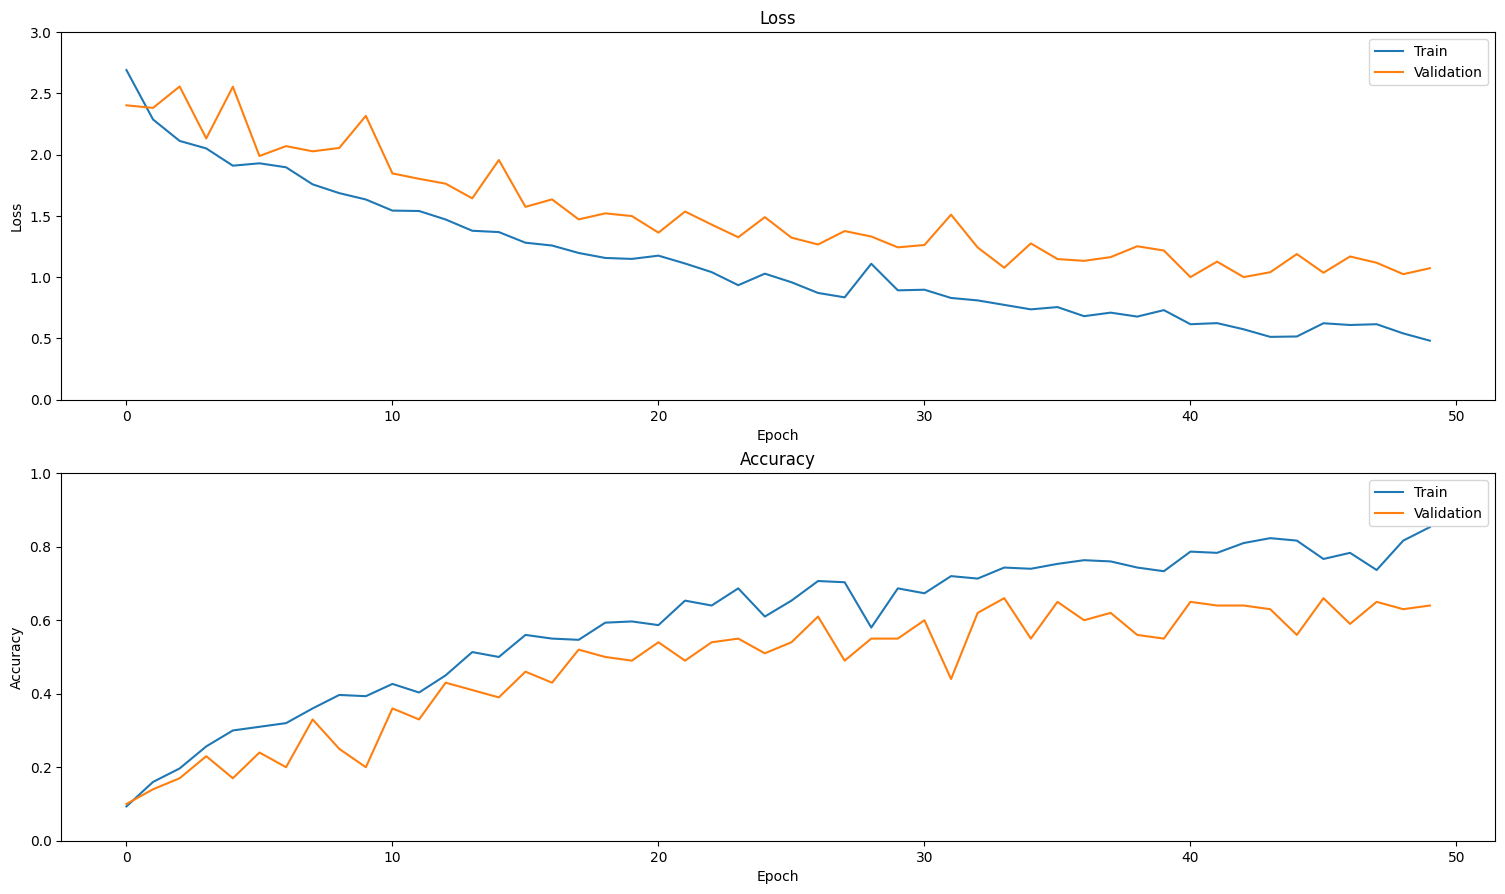

In [18]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluate the model

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset. 

Note: The example model in this tutorial uses a subset of the UCF101 dataset to keep training time reasonable. The accuracy and loss can be improved with further hyperparameter tuning or more training data. 

In [19]:
model.evaluate(test_ds, return_dict=True)

      1/Unknown - 1s 799ms/step - loss: 1.6339 - accuracy: 0.7500

      2/Unknown - 2s 879ms/step - loss: 1.5240 - accuracy: 0.6875

      3/Unknown - 3s 939ms/step - loss: 1.3539 - accuracy: 0.6667

      4/Unknown - 4s 961ms/step - loss: 1.3146 - accuracy: 0.6250

      5/Unknown - 5s 993ms/step - loss: 1.3147 - accuracy: 0.5500

      6/Unknown - 6s 952ms/step - loss: 1.2582 - accuracy: 0.6042

      7/Unknown - 7s 958ms/step - loss: 1.1834 - accuracy: 0.6250

      8/Unknown - 8s 983ms/step - loss: 1.2216 - accuracy: 0.6250

      9/Unknown - 9s 983ms/step - loss: 1.1442 - accuracy: 0.6528

     10/Unknown - 9s 957ms/step - loss: 1.1510 - accuracy: 0.6500

     11/Unknown - 11s 973ms/step - loss: 1.0898 - accuracy: 0.6705

     12/Unknown - 12s 993ms/step - loss: 1.0528 - accuracy: 0.6771

     13/Unknown - 12s 952ms/step - loss: 1.0331 - accuracy: 0.6800

13/13 [==============================] - 12s 954ms/step - loss: 1.0331 - accuracy: 0.6800


{'loss': 1.0330904722213745, 'accuracy': 0.6800000071525574}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values. 

In [20]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [21]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [22]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

      1/Unknown - 2s 2s/step

      2/Unknown - 3s 1s/step

      3/Unknown - 4s 966ms/step

      4/Unknown - 5s 966ms/step

      5/Unknown - 6s 969ms/step

      6/Unknown - 7s 1s/step   

      7/Unknown - 8s 1s/step

      8/Unknown - 9s 994ms/step

      9/Unknown - 10s 993ms/step

     10/Unknown - 11s 1s/step   

     11/Unknown - 12s 1s/step

     12/Unknown - 13s 1s/step

     13/Unknown - 14s 1s/step

     14/Unknown - 15s 1s/step

     15/Unknown - 16s 1s/step

     16/Unknown - 17s 1s/step

     17/Unknown - 18s 1s/step

     18/Unknown - 19s 1s/step

     19/Unknown - 20s 1s/step

     20/Unknown - 21s 1s/step

     21/Unknown - 22s 996ms/step

     22/Unknown - 23s 992ms/step

     23/Unknown - 24s 995ms/step

     24/Unknown - 25s 995ms/step

     25/Unknown - 26s 992ms/step

     26/Unknown - 27s 988ms/step

     27/Unknown - 28s 987ms/step

     28/Unknown - 29s 988ms/step

     29/Unknown - 30s 985ms/step

     30/Unknown - 31s 985ms/step

     31/Unknown - 32s 985ms/step

     32/Unknown - 33s 987ms/step

     33/Unknown - 34s 983ms/step

     34/Unknown - 35s 984ms/step

     35/Unknown - 36s 984ms/step

     36/Unknown - 37s 986ms/step

     37/Unknown - 38s 982ms/step

     38/Unknown - 38s 968ms/step

38/38 [==============================] - 38s 969ms/step


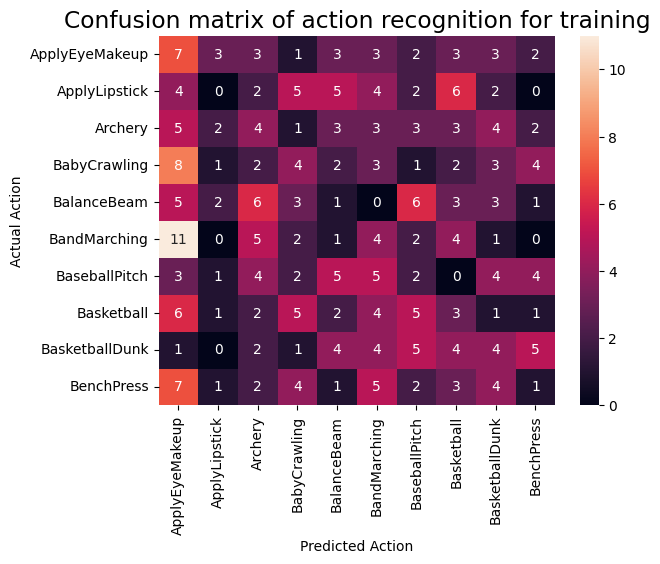

In [23]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

      1/Unknown - 1s 798ms/step

      2/Unknown - 2s 872ms/step

      3/Unknown - 3s 917ms/step

      4/Unknown - 4s 952ms/step

      5/Unknown - 5s 992ms/step

      6/Unknown - 6s 956ms/step

      7/Unknown - 7s 964ms/step

      8/Unknown - 8s 990ms/step

      9/Unknown - 9s 995ms/step

     10/Unknown - 10s 967ms/step

     11/Unknown - 11s 977ms/step

     12/Unknown - 12s 999ms/step

     13/Unknown - 12s 958ms/step

13/13 [==============================] - 12s 960ms/step


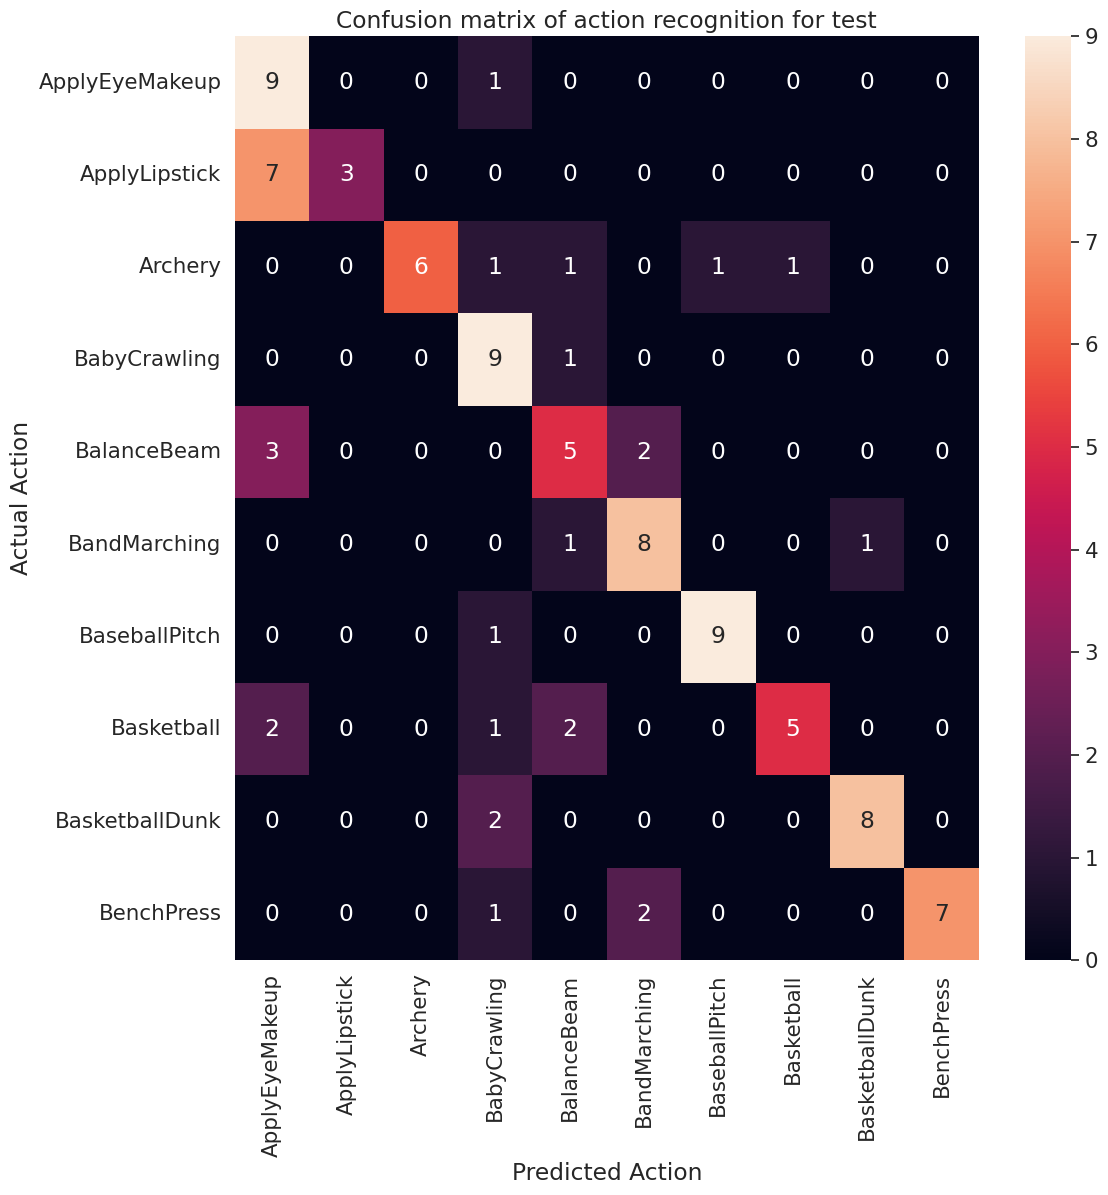

In [24]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

The precision and recall values for each class can also be calculated using a confusion matrix.

In [25]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [26]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [27]:
precision

{'ApplyEyeMakeup': 0.42857142857142855,
 'ApplyLipstick': 1.0,
 'Archery': 1.0,
 'BabyCrawling': 0.5625,
 'BalanceBeam': 0.5,
 'BandMarching': 0.6666666666666666,
 'BaseballPitch': 0.9,
 'Basketball': 0.8333333333333334,
 'BasketballDunk': 0.8888888888888888,
 'BenchPress': 1.0}

In [28]:
recall

{'ApplyEyeMakeup': 0.9,
 'ApplyLipstick': 0.3,
 'Archery': 0.6,
 'BabyCrawling': 0.9,
 'BalanceBeam': 0.5,
 'BandMarching': 0.8,
 'BaseballPitch': 0.9,
 'Basketball': 0.5,
 'BasketballDunk': 0.8,
 'BenchPress': 0.7}

## Next steps

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)